<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURUSD/EURUSD_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURUSD=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.3980  1.4054  1.3955  1.3999     1.3999       0
2009-01-02  1.4003  1.4023  1.3843  1.3923     1.3923       0
2009-01-05  1.3958  1.3958  1.3556  1.3646     1.3646       0
2009-01-06  1.3632  1.3632  1.3318  1.3510     1.3510       0
2009-01-07  1.3499  1.3742  1.3437  1.3611     1.3611       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.1413  1.1419  1.1376  1.1416     1.1416       0
2018-12-27  1.1364  1.1434  1.1359  1.1361     1.1361       0
2018-12-28  1.1431  1.1473  1.1431  1.1431     1.1431       0
2018-12-31  1.1439  1.1466  1.1422  1.1440     1.1440       0
2019-01-01  1.1494  1.1550  1.1465  1.1493     1.1493       0

[2605 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2605.000000  2605.000000  2605.000000  2605.000000  2605.000000  2605.0
mean      1.258565     1.263361     1.253492     1.258516     1.258516     0.0
std       0.118513     0.118918     0.118288     0.118428     0.118428     0.0
min       1.039400     1.042000     0.760600     1.039000     1.039000     0.0
25%       1.139700     1.143500     1.135900     1.139500     1.139500     0.0
50%       1.280900     1.287000     1.274700     1.281200     1.281200     0.0
75%       1.354800     1.359600     1.350000     1.354700     1.354700     0.0
max       1.512600     1.514500     1.504100     1.512800     1.512800     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.2806  1.2942  1.2736  1.2899     1.2899   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.265327  1.251267  1.247688  1.277964  1.273301  1.280127     1.27155     1.27055  1.252621  1.267512  1.284169  1.265785  1.272942  1.267512  1.280767  1.270181                1.291139                 1.267512                1.243886                1.302952                 1.267512                1.232073                1.314765                 1.267512                1.220260                1.326578                 1.267512                1.208447  1.273301  1.281785  1.268963                1.296927                 1.273301                1.249675                1.308740                 1.273301                1.237862                1.320553                 1.273301                1.226048                1.332366                 1.273301                1.214235   
2009-03-13  1.2900  1.2954  1.2871  1.2930     1.2930   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.279164  1.258241  1.249548  1.284710  1.277678  1.282820     1.27385     1.27115  1.255947  1.272487  1.291379  1.270775  1.278606  1.272487  1.291450  1.270284                1.298594                 1.272487                1.246381                1.311648                 1.272487                1.233327                1.324701                 1.272487                1.220274                1.337755                 1.272487                1.207220  1.277678  1.290492  1.269386                1.303785                 1.277678                1.251571                1.316839                 1.277678                1.238518                1.329892                 1.277678                1.225464                1.342946                 1.277678                1.212411   
2009-03-16  1.2886  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000    2555.000000   2555.000000     2555.000000     2555.000000       2555.000000  2555.000000  2555.000000  2555.000000  2555.000000   2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000  2555.000000  2555.000000  2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000   
mean      1.257738     1.262444     1.252787     1.257722     1.257722    15.765949     2.000783   185.797652      30.467319      0.033268        0.966732        0.010959          0.989041     6.611350     2.535812    26.990215     2.000783      1.998826    26.990215     1.257927     1.258339    -0.033930     1.257720     1.257895     1.258224     1.257894     1.257138     1.256004     1.257893     1.257726     1.257894     1.257837     1.257893     1.257745     1.258251                1.272786                 1.257893                1.242999                1.280233                 1.257893                1.235552                1.287680                 1.257893                1.228106                1.295127                 1.257893                1.220659     1.257895     1.257758     1.258195                1.272788                 1.257895                1.243001                1.280235                 1.257895                1.235554                1.287682   
std       0.119397     0.119783     0.119233     0.119342     0.119342     8.804321     1.415320   104.383262       0.781546      0.179371        0.179371        0.104130          0.104130     3.413495     1.107650    14.927084     1.415320      1.414351    14.927084     0.119297     0.118481     1.261276     0.119463     0.118822     0.119106     0.118781     0.119157     0.121340     0.118967     0.119409     0.119031     0.119039     0.118967     0.119271     0.118274                0.120986                 0.118967                0.117464                0.122182                 0.118967                0.116912                0.123497                 0.118967                0.116497                0.124928                 0.118967                0.116220     0.118822     0.119215     0.118377                0.120835                 0.118822                0.117325                0.122028                 0.118822                0.116778                0.123341   
min       1.039400     1.042000     0.760600     1.039000     1.039000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.509721  0.533757  0.689980  0.529548   0.529548   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.483748  0.448959  0.921018  0.508821  0.497783  0.516616    0.495675    0.503100  0.652634  0.486917  0.523864  0.484068  0.497327  0.486917  0.513593  0.493410                0.512923                 0.486917                0.462161                0.519130                 0.486917                0.458304                0.525021                 0.486917                0.461862                0.526243                 0.486917                0.465209  0.497783  0.516292  0.490569                0.528930                 0.497783                0.476602                0.534943                 0.497783                0.474082                0.540366                 0.497783                0.477144                0.543486                 0.497783   
2009-03-13  0.529586  0.536296  0.708137  0.536091   0.536091   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.513957  0.464683  0.921639  0.523254  0.507335  0.522661    0.500649    0.504406  0.657046  0.497709  0.539195  0.494884  0.509588  0.497709  0.536461  0.493641                0.528625                 0.497709                0.467544                0.536967                 0.497709                0.460962                0.544884                 0.497709                0.461889                0.547852                 0.497709                0.462762  0.507335  0.534997  0.491509                0.543625                 0.507335                0.480690                0.551850                 0.507335                0.475467                0.559366                 0.507335                0.475949                0.564396                 0.507335   
2009-03-16  0.526627  0.560212  0.708272  0.545800   0.545800   16          0         75

137816

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt4pwp6in
  JVM stdout: /tmp/tmpt4pwp6in/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt4pwp6in/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_w3b738
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.570159  0.720956              0.449510  0.509999  0.260099
1  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.555331  0.733566              0.485784  0.517318  0.267618
2  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.543260  0.851561              0.482108  0.545430  0.297493
3  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.536458  0.694009              0.477941  0.500430  0.250431
4  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.528983  2.492506              0.485294  0.650203  0.422764
5              DeepLearning_1_AutoML_20190725_012216  0.524326  0.843201              0.477941  0.561455  0.315231
6  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.489706  0.715655              0.492647  0.509477  0.259567
7  DeepLearning_grid_1_AutoML_20190725_012216_mod...  0.480515  0.692437              0.496324  0.499645  0.249645

variable  relative_importance  scaled_importance  percentage
0                          DIV             1.000000           1.000000    0.003180
1             CDLSTICKSANDWICH             0.980103           0.980103    0.003117
2                       TRANGE             0.955599           0.955599    0.003039
3           CDLMORNINGDOJISTAR             0.940502           0.940502    0.002991
4                          SUB             0.927647           0.927647    0.002950
...                        ...                  ...                ...         ...
1018                   DEMA_14             0.249850           0.249850    0.000794
1019  BBANDS_middleband_14_3_3             0.246803           0.246803    0.000785
1020       CDLXSIDEGAP3METHODS             0.243089           0.243089    0.000773
1021                   MA_14_0             0.242312           0.242312    0.000771
1022                CDL3INSIDE             0.241877           0.241877    0.000769

[1023 rows x 4 columns]

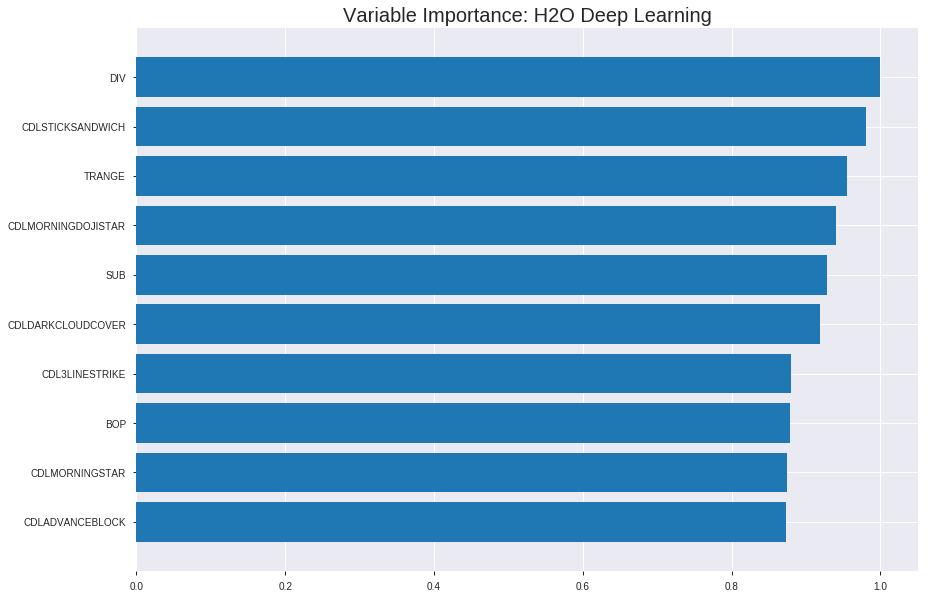

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_012216_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2238019822558207
RMSE: 0.4730771419713921
LogLoss: 0.6569910843112577
Mean Per-Class Error: 0.34925606989307956
AUC: 0.6880676619160431
pr_auc: 0.6505874624634683
Gini: 0.37613532383208614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41839810566325586: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      435  482   0.5256   (482.0/917.0)
1      153  717   0.1759   (153.0/870.0)
Total  588  1199  0.3553   (635.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418398     0.693088  244
max f2                       0.134741     0.831563  364
max f0point5                 0.433838     0.634383  236
max accuracy                 0.433838     0.646335  236
max precision                0.999215     1         0
max recall                   0.000717134  1         399
max specificity              0.999215     1         0
max absolute_mcc             0.422491     0.318959  242
max min_per_class_accuracy   0.515924     0.631407  191
max mean_per_class_accuracy  0.422491     0.650744  242

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 50.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.940106           2.05402   2.05402            1                0.965021  1                           0.965021            0.0206897       0.0206897                  105.402   105.402
    2        0.0201455                   0.893013           1.59757   1.8258             0.777778         0.912471  0.888889                    0.938746            0.016092        0.0367816                  59.7573   82.5798
    3        0.0302182                   0.859012           1.48346   1.71169            0.722222         0.876422  0.833333                    0.917972            0.0149425       0.0517241                  48.3461   71.1686
    4        0.040291                    0.844166           1.48346   1.65463            0.722222         0.850754  0.805556                    0.901167            0.0149425       0.0666667                  48.3461   65.463
    5        0.0503637                   0.823094           1.25524   1.57475            0.611111         0.833859  0.766667                    0.887705            0.0126437       0.0793103                  25.5236   57.4751
    6        0.100168                    0.755371           1.3155    1.44585            0.640449         0.78567   0.703911                    0.836973            0.0655172       0.144828                   31.5498   44.5849
    7        0.149972                    0.713961           1.26934   1.38723            0.617978         0.73407   0.675373                    0.8028              0.0632184       0.208046                   26.934    38.7232
    8        0.200336                    0.6702             1.39217   1.38847            0.677778         0.688783  0.675978                    0.774136            0.0701149       0.278161                   39.2171   38.8474
    9        0.299944                    0.614636           1.36166   1.37957            0.662921         0.641183  0.671642                    0.729984            0.135632        0.413793                   36.1656   37.9568
    10       0.400112                    0.560842           1.02127   1.28987            0.497207         0.587397  0.627972                    0.694287            0.102299        0.516092                   2.1274    28.9869
    11       0.50028                     0.514005           1.20487   1.27285            0.586592         0.536975  0.619687                    0.66279             0.12069         0.636782                   20.4874   27.2851
    12       0.599888                    0.457579           1.10779   1.24544            0.539326         0.488744  0.606343                    0.63389             0.110345        0.747126                   10.7788   24.5443
    13       0.700056                    0.400058           0.940949  1.20187            0.458101         0.42956   0.585132                    0.604654            0.0942529       0.841379                   -5.90509  20.1874
    14       0.799664                    0.332395           0.646209  1.13266            0.314607         0.371054  0.551435                    0.575556            0.0643678       0.905747                   -35.3791  13.2659
    15       0.899832                    0.223778           0.654074  1.07938            0.318436         0.27968   0.525498                    0.542619            0.0655172       0.971264                   -34.5926  7.9384
    16       1                           3.29771e-26        0.286875  1                  0.139665         0.124395  0.486849                    0.500727           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24734544137764486
RMSE: 0.49733835703436835
LogLoss: 0.6965922283227414
Mean Per-Class Error: 0.4051011029411764
AUC: 0.6100719975490196
pr_auc: 0.5870828918312645
Gini: 0.22014399509803928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3039371796867845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   218  0.8549   (218.0/255.0)
1      11   245  0.043    (11.0/256.0)
Total  48   463  0.4481   (229.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303937     0.681502  356
max f2                       0.034376     0.83442   398
max f0point5                 0.463731     0.597426  262
max accuracy                 0.549091     0.594912  199
max precision                0.996272     1         0
max recall                   0.034376     1         398
max specificity              0.996272     1         0
max absolute_mcc             0.549091     0.189815  199
max min_per_class_accuracy   0.551989     0.589844  196
max mean_per_class_accuracy  0.549091     0.594899  199

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 54.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.863829           1.66341   1.66341            0.833333         0.919236  0.833333                    0.919236            0.0195312       0.0195312                  66.3411   66.3411
    2        0.0215264                   0.834821           0.798438  1.27024            0.4              0.845542  0.636364                    0.885739            0.0078125       0.0273438                  -20.1562  27.0241
    3        0.0313112                   0.816755           1.99609   1.49707            1                0.826926  0.75                        0.86736             0.0195312       0.046875                   99.6094   49.707
    4        0.0410959                   0.806674           1.19766   1.42578            0.6              0.81233   0.714286                    0.854257            0.0117188       0.0585938                  19.7656   42.5781
    5        0.0508806                   0.802291           1.19766   1.38191            0.6              0.804238  0.692308                    0.844638            0.0117188       0.0703125                  19.7656   38.1911
    6        0.101761                    0.758402           1.22837   1.30514            0.615385         0.781584  0.653846                    0.813111            0.0625          0.132812                   22.8365   30.5138
    7        0.150685                    0.722762           0.958125  1.19247            0.48             0.739568  0.597403                    0.789233            0.046875        0.179688                   -4.1875   19.2472
    8        0.201566                    0.690936           1.15159   1.18215            0.576923         0.705858  0.592233                    0.768187            0.0585938       0.238281                   15.1593   18.2153
    9        0.30137                     0.639566           1.17417   1.17951            0.588235         0.662755  0.590909                    0.733271            0.117188        0.355469                   17.4173   17.951
    10       0.401174                    0.602491           1.13503   1.16845            0.568627         0.623343  0.585366                    0.705923            0.113281        0.46875                    13.5034   16.8445
    11       0.500978                    0.551577           1.21331   1.17738            0.607843         0.577401  0.589844                    0.680319            0.121094        0.589844                   21.3312   17.7383
    12       0.600783                    0.496868           0.939338  1.13784            0.470588         0.524515  0.570033                    0.654436            0.09375         0.683594                   -6.06618  13.7838
    13       0.700587                    0.448518           0.939338  1.10956            0.470588         0.472995  0.555866                    0.628589            0.09375         0.777344                   -6.06618  10.956
    14       0.800391                    0.397769           0.900199  1.08345            0.45098          0.423575  0.542787                    0.603025            0.0898438       0.867188                   -9.98009  8.34543
    15       0.900196                    0.309115           0.821921  1.05446            0.411765         0.356652  0.528261                    0.575709            0.0820312       0.949219                   -17.8079  5.44582
    16       1                           0.0191665          0.508808  1                  0.254902         0.218093  0.500978                    0.540018            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:25:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:25:36  3 min 13.984 sec  344 obs/sec       0.392278  1             701        0.624904         1.87067             -0.563102      0.572332        0.505498           0.912899         0.493565                         0.664288           2.379                 -0.765123        0.512102          0.493056             1.33073            0.485323
    2019-07-25 01:25:49  3 min 27.540 sec  506 obs/sec       4.02518   10            7193       0.586592         3.26962             -0.377315      0.602392        0.419705           1.25892          0.429211                         0.70441            12.9106               -0.984783        0.533502          0.0358674            1.07985            0.489237
    2019-07-25 01:26:03  3 min 41.461 sec  533 obs/sec       7.99888   20            14294      0.588429         1.95868             -0.385953      0.607645        0.459925           1.8258           0.466144                         0.682724           4.02201               -0.864455        0.592134          0.529445             1.99609            0.491194
    2019-07-25 01:26:17  3 min 55.424 sec  541 obs/sec       11.9261   30            21312      0.55638          1.25034             -0.239091      0.654173        0.551501           1.8258           0.409625                         0.624218           1.81363               -0.5586          0.60062           0.570508             1.99609            0.481409
    2019-07-25 01:26:32  4 min  9.977 sec  541 obs/sec       15.9239   40            28456      0.486471         0.772824            0.0527288      0.694901        0.668607           1.8258           0.369334                         0.605594           1.33628               -0.466981        0.575115          0.567421             1.66341            0.46771
    2019-07-25 01:26:46  4 min 24.377 sec  551 obs/sec       20.2669   51            36217      0.473077         0.656991            0.104172       0.688068        0.650587           2.05402          0.355344                         0.497338           0.696592              0.0106144        0.610072          0.587083             1.66341            0.448141
    2019-07-25 01:26:59  4 min 37.783 sec  556 obs/sec       24.2054   61            43255      0.475687         0.663519            0.0942613      0.682774        0.639321           1.8258           0.372132                         0.521025           0.752761              -0.0858744       0.566085          0.554197             1.66341            0.440313
    2019-07-25 01:27:14  4 min 52.240 sec  562 obs/sec       28.6027   72            51113      0.485543         0.688093            0.0563388      0.678045        0.632897           1.8258           0.391158                         0.534029           0.795958              -0.140751        0.563274          0.559706             1.66341            0.475538
    2019-07-25 01:27:27 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
DIV                       1.0                    1.0                  0.00317989684475326
CDLSTICKSANDWICH          0.9801030158996582     0.9801030158996582   0.0031166264877924774
TRANGE                    0.9555988907814026     0.9555988907814026   0.003038705897645497
CDLMORNINGDOJISTAR        0.9405022859573364     0.9405022859573364   0.0029907002515989624
SUB                       0.927647054195404      0.927647054195404    0.002949821940680622
---                       ---                    ---                  ---
DEMA_14                   0.24985040724277496    0.24985040724277496  0.0007944985216516172
BBANDS_middleband_14_3_3  0.24680264294147491    0.24680264294147491  0.0007848069455663615
CDLXSIDEGAP3METHODS       0.24308942258358002    0.24308942258358002  0.000772999287866418
MA_14_0                   0.24231208860874176    0.24231208860874176  0.0007705274460125103
CDL3INSIDE                0.24187739193439484    0.24187739193439484  0.0007691451554293297


See the whole table with table.as_data_frame()


('accuracy', 0.5703125)

('F1', 0.659217877094972)

('auc', 0.5701593137254902)

('logloss', 0.7209557098499446)

('mean_per_class_error', 0.42156862745098034)

('rmse', 0.5099991219889723)

('mse', 0.2600991044295227)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


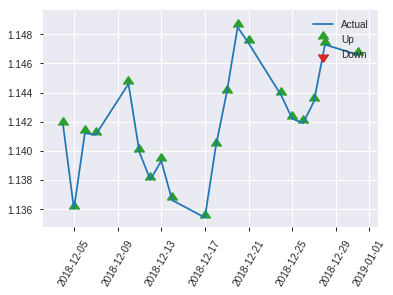


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2600991044295227
RMSE: 0.5099991219889723
LogLoss: 0.7209557098499446
Mean Per-Class Error: 0.42156862745098034
AUC: 0.5701593137254902
pr_auc: 0.5018344183298804
Gini: 0.14031862745098045
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24825892589377793: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   120  0.8824   (120.0/136.0)
1      2    118  0.0167   (2.0/120.0)
Total  18   238  0.4766   (122.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248259     0.659218  237
max f2                       0.224838     0.821823  243
max f0point5                 0.463917     0.559211  159
max accuracy                 0.537247     0.570312  123
max precision                0.771918     0.555556  17
max recall                   0.0785474    1         255
max specificity              0.913955     0.992647  0
max absolute_mcc             0.248259     0.197094  237
max min_per_class_accuracy   0.533308     0.566667  125
max mean_per_class_accuracy  0.463917     0.578431  159

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.83223            0.711111  0.711111           0.333333         0.862633  0.333333                    0.862633            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.823959           1.42222   1.06667            0.666667         0.827969  0.5                         0.845301            0.0166667       0.025                      42.2222   6.66667
    3        0.03125                     0.804071           1.06667   1.06667            0.5              0.809188  0.5                         0.836273            0.00833333      0.0333333                  6.66667   6.66667
    4        0.0429688                   0.790806           0.711111  0.969697           0.333333         0.795818  0.454545                    0.82524             0.00833333      0.0416667                  -28.8889  -3.0303
    5        0.0507812                   0.783911           1.06667   0.984615           0.5              0.78665   0.461538                    0.819303            0.00833333      0.05                       6.66667   -1.53846
    6        0.101562                    0.737706           1.31282   1.14872            0.615385         0.763753  0.538462                    0.791528            0.0666667       0.116667                   31.2821   14.8718
    7        0.152344                    0.693344           0.65641   0.984615           0.307692         0.715301  0.461538                    0.766119            0.0333333       0.15                       -34.359   -1.53846
    8        0.203125                    0.664914           0.984615  0.984615           0.461538         0.681633  0.461538                    0.744998            0.05            0.2                        -1.53846  -1.53846
    9        0.300781                    0.618569           1.19467   1.05281            0.56             0.645643  0.493506                    0.712739            0.116667        0.316667                   19.4667   5.28139
    10       0.402344                    0.578442           1.39487   1.13916            0.653846         0.596751  0.533981                    0.683461            0.141667        0.458333                   39.4872   13.9159
    11       0.5                         0.530351           1.10933   1.13333            0.52             0.554845  0.53125                     0.658341            0.108333        0.566667                   10.9333   13.3333
    12       0.601562                    0.472265           0.984615  1.10823            0.461538         0.502333  0.519481                    0.632002            0.1             0.666667                   -1.53846  10.8225
    13       0.699219                    0.437204           0.853333  1.07263            0.4              0.452631  0.502793                    0.60695             0.0833333       0.75                       -14.6667  7.26257
    14       0.800781                    0.36259            0.984615  1.06146            0.461538         0.407854  0.497561                    0.581699            0.1             0.85                       -1.53846  6.14634
    15       0.898438                    0.269027           0.768     1.02957            0.36             0.307479  0.482609                    0.551892            0.075           0.925                      -23.2     2.95652
    16       1                           0.0785474          0.738462  1                  0.346154         0.205331  0.46875                     0.516695     

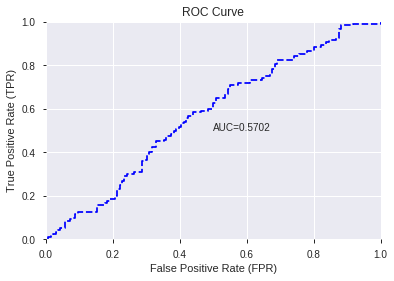

This function is available for GLM models only


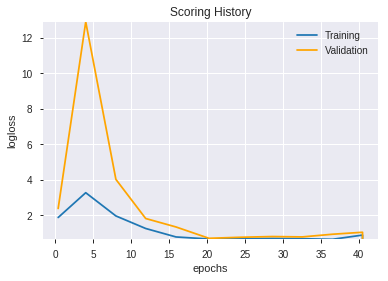

--2019-07-25 01:45:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_012216_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_012216_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_014513_model_9  0.558027  0.694330              0.489461  0.500573  0.250573
1  DeepLearning_grid_1_AutoML_20190725_014513_model_5  0.555270  0.704499              0.472059  0.504735  0.254758
2  DeepLearning_grid_1_AutoML_20190725_014513_model_8  0.550061  0.704808              0.485294  0.505896  0.255931
3  DeepLearning_grid_1_AutoML_20190725_014513_model_6  0.546324  0.698759              0.486275  0.502159  0.252163
4               DeepLearning_1_AutoML_20190725_014513  0.527022  0.721889              0.458333  0.512331  0.262483
5  DeepLearning_grid_1_AutoML_20190725_014513_model_3  0.515441  0.888140              0.469853  0.523214  0.273753
6  DeepLearning_grid_1_AutoML_20190725_014513_model_7  0.513021  0.769753              0.500000  0.529075  0.279921
7  DeepLearning_grid_1_AutoML_20190725_014513_model_1  0.507659  0.936531              0.482598  0.558742  0.312193
8  DeepLearning_grid_1_AutoML_20190725_014513_model_2  0.501716  0.870442              0.465686  0.544452  0.296428
9  DeepLearning_grid_1_AutoML_20190725_014513_model_4  0.501042  0.895718              0.483578  0.559653  0.313212

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.034554
1               TRANGE             0.863643           0.863643    0.029842
2                  DIV             0.854929           0.854929    0.029541
3                  SUB             0.846013           0.846013    0.029233
4               SAREXT             0.626755           0.626755    0.021657
5           MINUS_DM_8             0.619990           0.619990    0.021423
6       CDLRICKSHAWMAN             0.617684           0.617684    0.021343
7           aroonup_24             0.592627           0.592627    0.020477
8            CDLTAKURI             0.589795           0.589795    0.020380
9       CDLSPINNINGTOP             0.582891           0.582891    0.020141
10     CDLADVANCEBLOCK             0.581598           0.581598    0.020096
11             weekday             0.577501           0.577501    0.019955
12        CDLTASUKIGAP             0.575652           0.575652    0.019891
13      CDL3LINESTRIKE             0.572352           0.572352    0.019777
14  CDLSEPARATINGLINES             0.571886           0.571886    0.019761
15  CDLMORNINGDOJISTAR             0.571198           0.571198    0.019737
16           dayofweek             0.570946           0.570946    0.019728
17      CDLMORNINGSTAR             0.569740           0.569740    0.019687
18   CDLSTALLEDPATTERN             0.569531           0.569531    0.019679
19       days_in_month             0.567720           0.567720    0.019617
20   CDLDARKCLOUDCOVER             0.565587           0.565587    0.019543
21      CDLEVENINGSTAR             0.564335           0.564335    0.019500
22      CDLMATCHINGLOW             0.562238           0.562238    0.019427
23           CORREL_24             0.560026           0.560026    0.019351
24  CDLEVENINGDOJISTAR             0.558177           0.558177    0.019287
25         CDL3OUTSIDE             0.555531           0.555531    0.019196
26             BETA_12             0.552807           0.552807    0.019101
27     CDLLADDERBOTTOM             0.551458           0.551458    0.019055
28    CDLDRAGONFLYDOJI             0.550927           0.550927    0.019036
29     CDLHOMINGPIGEON             0.546973           0.546973    0.018900
30   CDLINVERTEDHAMMER             0.541611           0.541611    0.018715
31      STOCHRSI_fastk             0.540952           0.540952    0.018692
32             CDLDOJI             0.539897           0.539897    0.018655
33    CDLSTICKSANDWICH             0.539173           0.539173    0.018630
34   CDLLONGLEGGEDDOJI             0.537754           0.537754    0.018581
35              VAR_30             0.533414           0.533414    0.018431
36     CDLSHOOTINGSTAR             0.530554           0.530554    0.018333
37    is_quarter_start             0.528608           0.528608    0.018265
38      is_quarter_end             0.528463           0.528463    0.018260
39       CDLHANGINGMAN             0.528177           0.528177    0.018250
40       CDLHIKKAKEMOD             0.526352           0.526352    0.018187
41                week             0.524698           0.524698    0.018130
42        HT_TRENDMODE             0.524006           0.524006    0.018106
43        is_month_end             0.519678           0.519678    0.017957
44         CDLMARUBOZU             0.517683           0.517683    0.017888
45        CDLENGULFING             0.516566           0.516566    0.017849
46      CDLHARAMICROSS             0.510284           0.510284    0.017632
47      is_month_start             0.503911           0.503911    0.017412
48                 day             0.492863           0.492863    0.017030
49           CDLHAMMER             0.465388           0.465388    0.016081

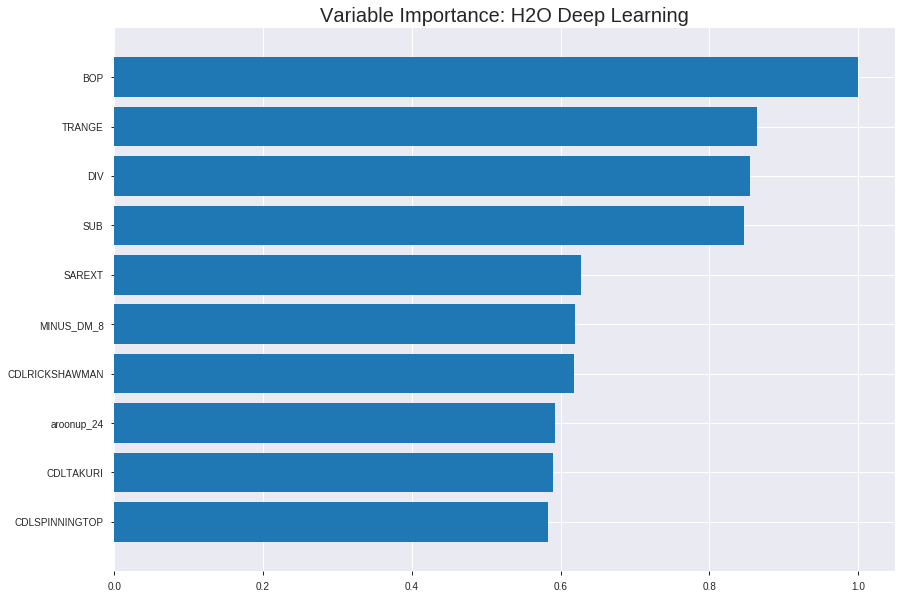

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_014513_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22951923127724605
RMSE: 0.4790816540812704
LogLoss: 0.6551315540985456
Mean Per-Class Error: 0.38612730167086573
AUC: 0.6489433309517542
pr_auc: 0.6016930449104158
Gini: 0.2978866619035083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4103330831523372: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      254  663   0.723    (663.0/917.0)
1      58   812   0.0667   (58.0/870.0)
Total  312  1475  0.4035   (721.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410333     0.692537  252
max f2                       0.210746     0.833333  348
max f0point5                 0.465276     0.605015  204
max accuracy                 0.494129     0.609401  176
max precision                0.754351     1         0
max recall                   1.26113e-06  1         399
max specificity              0.754351     1         0
max absolute_mcc             0.410333     0.276923  252
max min_per_class_accuracy   0.531414     0.593103  135
max mean_per_class_accuracy  0.465276     0.613873  204

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 49.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.649787           1.71169   1.71169            0.833333         0.669868  0.833333                    0.669868            0.0172414       0.0172414                  71.1686   71.1686
    2        0.0201455                   0.641074           0.912899  1.31229            0.444444         0.645166  0.638889                    0.657517            0.0091954       0.0264368                  -8.71009  31.2292
    3        0.0302182                   0.631766           1.59757   1.40739            0.777778         0.635488  0.685185                    0.650174            0.016092        0.0425287                  59.7573   40.7386
    4        0.040291                    0.625044           1.36935   1.39788            0.666667         0.628073  0.680556                    0.644649            0.0137931       0.0563218                  36.9349   39.7877
    5        0.0503637                   0.620606           1.59757   1.43782            0.777778         0.622798  0.7                         0.640279            0.016092        0.0724138                  59.7573   43.7816
    6        0.100168                    0.600385           1.24626   1.34257            0.606742         0.609927  0.653631                    0.625188            0.062069        0.134483                   24.6261   34.2574
    7        0.149972                    0.590433           1.29242   1.32592            0.629213         0.595364  0.645522                    0.615283            0.0643678       0.198851                   29.2419   32.5918
    8        0.200336                    0.580376           1.20959   1.29667            0.588889         0.584762  0.631285                    0.60761             0.0609195       0.25977                    20.9591   29.6674
    9        0.299944                    0.562627           1.15395   1.24928            0.561798         0.571584  0.608209                    0.595646            0.114943        0.374713                   15.3945   24.9275
    10       0.400112                    0.547872           1.04422   1.19794            0.50838          0.555211  0.583217                    0.585523            0.104598        0.47931                    4.4224    19.7941
    11       0.50028                     0.530593           1.15897   1.19014            0.564246         0.539351  0.579418                    0.576279            0.116092        0.595402                   15.8974   19.0139
    12       0.599888                    0.505552           1.18856   1.18988            0.578652         0.519604  0.579291                    0.566868            0.118391        0.713793                   18.8564   18.9877
    13       0.700056                    0.467932           1.02127   1.16575            0.497207         0.487567  0.567546                    0.555521            0.102299        0.816092                   2.1274    16.5752
    14       0.799664                    0.429407           0.934696  1.13697            0.455056         0.449564  0.553534                    0.542323            0.0931034       0.909195                   -6.53041  13.6971
    15       0.899832                    0.316969           0.619649  1.07938            0.301676         0.380386  0.525498                    0.524296            0.062069        0.971264                   -38.0351  7.9384
    16       1                           1.26113e-06        0.286875  1                  0.139665         0.212286  0.486849                    0.493043          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2426443825701964
RMSE: 0.49258946656439623
LogLoss: 0.677943478996864
Mean Per-Class Error: 0.4188265931372549
AUC: 0.6004672181372549
pr_auc: 0.5897989996755251
Gini: 0.2009344362745098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37499139453432: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   237  0.9294   (237.0/255.0)
1      3    253  0.0117   (3.0/256.0)
Total  21   490  0.4697   (240.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374991     0.678284  378
max f2                       0.27103      0.837696  392
max f0point5                 0.53         0.586806  223
max accuracy                 0.538613     0.581213  204
max precision                0.610767     0.764706  32
max recall                   0.27103      1         392
max specificity              0.655837     0.996078  0
max absolute_mcc             0.53         0.164193  223
max min_per_class_accuracy   0.541248     0.576471  196
max mean_per_class_accuracy  0.538613     0.581173  204

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 52.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.633778           0.998047  0.998047           0.5              0.64398   0.5                         0.64398             0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.628167           1.99609   1.4517             1                0.631243  0.727273                    0.638191            0.0195312       0.03125                    99.6094    45.1705
    3        0.0313112                   0.624985           1.19766   1.37231            0.6              0.62669   0.6875                      0.634597            0.0117188       0.0429688                  19.7656    37.2314
    4        0.0410959                   0.620319           1.59688   1.42578            0.8              0.622818  0.714286                    0.631792            0.015625        0.0585938                  59.6875    42.5781
    5        0.0508806                   0.617557           1.59688   1.45868            0.8              0.6189    0.730769                    0.629313            0.015625        0.0742188                  59.6875    45.8684
    6        0.101761                    0.60414            1.45868   1.45868            0.730769         0.609193  0.730769                    0.619253            0.0742188       0.148438                   45.8684    45.8684
    7        0.150685                    0.593116           1.03797   1.32209            0.52             0.599199  0.662338                    0.612742            0.0507812       0.199219                   3.79688    32.2088
    8        0.201566                    0.582944           0.998047  1.24029            0.5              0.588641  0.621359                    0.606658            0.0507812       0.25                       -0.195312  24.0291
    9        0.30137                     0.568356           1.09589   1.19247            0.54902          0.574544  0.597403                    0.596023            0.109375        0.359375                   9.58946    19.2472
    10       0.401174                    0.554554           1.01762   1.14897            0.509804         0.561279  0.57561                     0.587379            0.101562        0.460938                   1.76164    14.8971
    11       0.500978                    0.541211           1.17417   1.15399            0.588235         0.547367  0.578125                    0.579408            0.117188        0.578125                   17.4173    15.3992
    12       0.600783                    0.528249           0.939338  1.11833            0.470588         0.533851  0.560261                    0.57184             0.09375         0.671875                   -6.06618   11.8333
    13       0.700587                    0.508942           0.86106   1.08168            0.431373         0.518562  0.541899                    0.56425             0.0859375       0.757812                   -13.894    8.16821
    14       0.800391                    0.484619           0.939338  1.06393            0.470588         0.497389  0.533007                    0.555913            0.09375         0.851562                   -6.06618   6.39326
    15       0.900196                    0.436858           0.821921  1.0371             0.411765         0.464111  0.519565                    0.545735            0.0820312       0.933594                   -17.8079   3.71009
    16       1                           0.228161           0.665365  1                  0.333333         0.368115  0.500978                  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:52:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:52:28  2 min 26.870 sec  538 obs/sec       0.813654  1             1454       0.508489         0.716258            -0.0349593     0.615697        0.569307           1.25524          0.439843                         0.516644           0.733705              -0.0676865       0.573859          0.559344             1.33073            0.471624
    2019-07-25 01:52:42  2 min 40.496 sec  870 obs/sec       7.34191   9             13120      0.479082         0.655132            0.0812876      0.648943        0.601693           1.71169          0.40347                          0.492589           0.677943              0.0294188        0.600467          0.589799             0.998047           0.469667
    2019-07-25 01:52:55  2 min 53.647 sec  972 obs/sec       14.6928   18            26256      0.473778         0.640229            0.101517       0.670652        0.634912           1.93991          0.392278                         0.492395           0.678018              0.0301856        0.600942          0.590935             1.66341            0.48728
    2019-07-25 01:53:08  3 min  7.102 sec  1040 obs/sec      22.826    28            40790      0.4734           0.638116            0.102948       0.683505        0.651806           1.93991          0.38892                          0.495711           0.684222              0.0170774        0.60046           0.566421             0.998047           0.483366
    2019-07-25 01:53:22  3 min 20.465 sec  1106 obs/sec      31.7885   39            56806      0.468504         0.629491            0.121408       0.690362        0.659534           1.93991          0.382764                         0.495792           0.685427              0.0167578        0.599992          0.569892             0.665365           0.471624
    2019-07-25 01:53:34  3 min 33.194 sec  1158 obs/sec      40.7202   50            72767      0.469008         0.630774            0.119518       0.691005        0.661261           1.93991          0.368774                         0.495219           0.683922              0.0190296        0.585026          0.550116             0.998047           0.473581
    2019-07-25 01:53:48  3 min 46.386 sec  1207 obs/sec      50.5367   62            90309      0.468337         0.628615            0.122033       0.710496        0.682354           2.05402          0.38892                          0.497177           0.688187              0.0112579        0.598238          0.561377             0.998047           0.469667
    2019-07-25 01:53:49  3 min 47.644 sec  1207 obs/sec      50.5367   62            90309      0.479082         0.655132            0.0812876      0.648943        0.601693           1.71169          0.40347                          0.492589           0.677943              0.0294188        0.600467          0.589799             0.998047           0.469667

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.03455360348665241
TRANGE          0.8636434078216553     0.8636434078216553   0.029841991867730715
DIV             0.8549293875694275     0.8549293875694275   0.02954089106716058
SUB             0.8460132479667664     0.8460132479667664   0.029232806314698587
SAREXT          0.6267549395561218     0.6267549395561218   0.02165664166472303
---             ---                    ---                  ---
CDLENGULFING    0.5165656805038452     0.5165656805038452   0.01784920569894264
CDLHARAMICROSS  0.5102844834327698     0.5102844834327698   0.017632167705927175
is_month_start  0.5039107203483582     0.5039107203483582   0.017411931223590554
day             0.4928627908229828     0.4928627908229828   0.017030185447422255
CDLHAMMER       0.4653879702091217     0.4653879702091217   0.016080831390063995


See the whole table with table.as_data_frame()


('accuracy', 0.5546875)

('F1', 0.6415094339622642)

('auc', 0.5580269607843137)

('logloss', 0.6943295945272927)

('mean_per_class_error', 0.44019607843137254)

('rmse', 0.500572966737857)

('mse', 0.25057329502873965)

deeplearning prediction progress: |███████████████████████████████████████| 100%


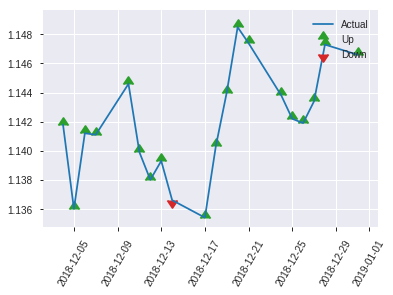


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25057329502873965
RMSE: 0.500572966737857
LogLoss: 0.6943295945272927
Mean Per-Class Error: 0.44019607843137254
AUC: 0.5580269607843137
pr_auc: 0.5071509933954688
Gini: 0.11605392156862737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3614218735437041: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    132  0.9706   (132.0/136.0)
1      1    119  0.0083   (1.0/120.0)
Total  5    251  0.5195   (133.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361422     0.641509  250
max f2                       0.328981     0.816327  254
max f0point5                 0.521422     0.547619  179
max accuracy                 0.590315     0.554688  39
max precision                0.620244     0.625     7
max recall                   0.328981     1         254
max specificity              0.645425     0.992647  0
max absolute_mcc             0.521422     0.13064   179
max min_per_class_accuracy   0.551548     0.536765  127
max mean_per_class_accuracy  0.521422     0.559804  179

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 53.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.636658           0.711111  0.711111           0.333333         0.642314  0.333333                    0.642314            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.624554           1.42222   1.06667            0.666667         0.62866   0.5                         0.635487            0.0166667       0.025                      42.2222   6.66667
    3        0.03125                     0.617198           2.13333   1.33333            1                0.620519  0.625                       0.631745            0.0166667       0.0416667                  113.333   33.3333
    4        0.0429688                   0.614037           0.711111  1.16364            0.333333         0.615122  0.545455                    0.627212            0.00833333      0.05                       -28.8889  16.3636
    5        0.0507812                   0.612818           2.13333   1.31282            1                0.612902  0.615385                    0.62501             0.0166667       0.0666667                  113.333   31.2821
    6        0.101562                    0.60279            1.14872   1.23077            0.538462         0.606471  0.576923                    0.615741            0.0583333       0.125                      14.8718   23.0769
    7        0.152344                    0.590633           1.14872   1.20342            0.538462         0.597671  0.564103                    0.609717            0.0583333       0.183333                   14.8718   20.3419
    8        0.203125                    0.584223           0.820513  1.10769            0.384615         0.587685  0.519231                    0.604209            0.0416667       0.225                      -17.9487  10.7692
    9        0.300781                    0.572836           1.19467   1.13593            0.56             0.578169  0.532468                    0.595755            0.116667        0.341667                   19.4667   13.5931
    10       0.402344                    0.560701           0.820513  1.05631            0.384615         0.566959  0.495146                    0.588486            0.0833333       0.425                      -17.9487  5.63107
    11       0.5                         0.551542           1.19467   1.08333            0.56             0.556361  0.507812                    0.582212            0.116667        0.541667                   19.4667   8.33333
    12       0.601562                    0.536888           0.984615  1.06667            0.461538         0.544965  0.5                         0.575923            0.1             0.641667                   -1.53846  6.66667
    13       0.699219                    0.52158            1.19467   1.08454            0.56             0.529808  0.50838                     0.569482            0.116667        0.758333                   19.4667   8.45438
    14       0.800781                    0.501181           0.820513  1.05106            0.384615         0.51142   0.492683                    0.562118            0.0833333       0.841667                   -17.9487  5.10569
    15       0.898438                    0.441191           0.853333  1.02957            0.4              0.470224  0.482609                    0.55213             0.0833333       0.925                      -14.6667  2.95652
    16       1                           0.303792           0.738462  1                  0.346154         0.390525  0.46875                     0.535717        

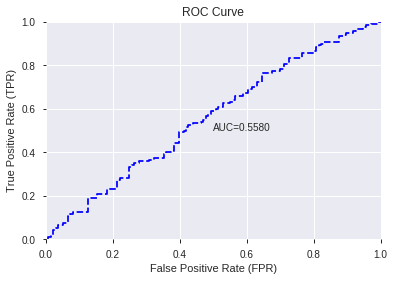

This function is available for GLM models only


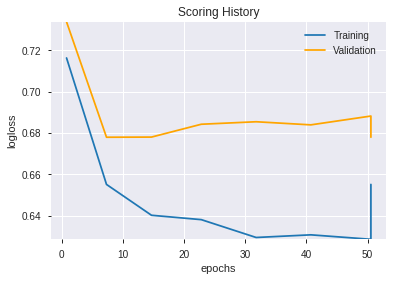

--2019-07-25 01:53:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_014513_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_014513_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'DIV',
 'SUB',
 'SAREXT',
 'MINUS_DM_8',
 'CDLRICKSHAWMAN',
 'aroonup_24',
 'CDLTAKURI',
 'CDLSPINNINGTOP',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLTASUKIGAP',
 'CDL3LINESTRIKE',
 'CDLSEPARATINGLINES',
 'CDLMORNINGDOJISTAR',
 'dayofweek',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'CDLEVENINGDOJISTAR',
 'CDL3OUTSIDE',
 'BETA_12',
 'CDLLADDERBOTTOM',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'CDLSTICKSANDWICH',
 'CDLLONGLEGGEDDOJI',
 'VAR_30',
 'CDLSHOOTINGSTAR',
 'is_quarter_start',
 'is_quarter_end',
 'CDLHANGINGMAN',
 'CDLHIKKAKEMOD',
 'week',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'CDLHARAMICROSS',
 'is_month_start',
 'day',
 'CDLHAMMER']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_015405_model_1  0.513787  0.694501                   0.5  0.500646  0.250646

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.110034           1.000000    0.102452
1       CDLRICKSHAWMAN             0.060004           0.545324    0.055870
2            dayofweek             0.048272           0.438703    0.044946
3              weekday             0.048251           0.438511    0.044926
4     CDLDRAGONFLYDOJI             0.047336           0.430197    0.044074
5            CDLTAKURI             0.045887           0.417030    0.042726
6     is_quarter_start             0.044517           0.404575    0.041449
7          CDLMARUBOZU             0.038778           0.352423    0.036106
8       CDLSPINNINGTOP             0.032542           0.295748    0.030300
9    CDLINVERTEDHAMMER             0.032450           0.294910    0.030214
10    CDLSTICKSANDWICH             0.031566           0.286872    0.029391
11  CDLMORNINGDOJISTAR             0.029253           0.265852    0.027237
12      is_quarter_end             0.027436           0.249342    0.025546
13        CDLENGULFING             0.026513           0.240950    0.024686
14  CDLSEPARATINGLINES             0.025996           0.236255    0.024205
15              SAREXT             0.025316           0.230072    0.023571
16     CDLADVANCEBLOCK             0.024751           0.224944    0.023046
17              TRANGE             0.023342           0.212136    0.021734
18       days_in_month             0.020445           0.185806    0.019036
19       CDLHANGINGMAN             0.020255           0.184083    0.018860
20             BETA_12             0.019373           0.176068    0.018039
21        CDLTASUKIGAP             0.019294           0.175347    0.017965
22          aroonup_24             0.019280           0.175222    0.017952
23         CDL3OUTSIDE             0.018972           0.172423    0.017665
24      CDLEVENINGSTAR             0.018254           0.165895    0.016996
25              VAR_30             0.018237           0.165736    0.016980
26                week             0.017776           0.161549    0.016551
27     CDLHOMINGPIGEON             0.017579           0.159756    0.016367
28   CDLDARKCLOUDCOVER             0.016864           0.153263    0.015702
29   CDLSTALLEDPATTERN             0.015813           0.143711    0.014723
30                 SUB             0.014659           0.133227    0.013649
31      CDLMATCHINGLOW             0.011496           0.104476    0.010704
32       CDLHIKKAKEMOD             0.011301           0.102704    0.010522
33      STOCHRSI_fastk             0.010381           0.094342    0.009666
34      CDL3LINESTRIKE             0.009588           0.087141    0.008928
35      CDLHARAMICROSS             0.008718           0.079229    0.008117
36        HT_TRENDMODE             0.008276           0.075211    0.007706
37                 DIV             0.008030           0.072974    0.007476
38                 day             0.007603           0.069093    0.007079
39           CDLHAMMER             0.006834           0.062107    0.006363
40     CDLSHOOTINGSTAR             0.006517           0.059224    0.006068
41             CDLDOJI             0.006066           0.055133    0.005648
42          MINUS_DM_8             0.005769           0.052433    0.005372
43  CDLEVENINGDOJISTAR             0.003270           0.029717    0.003045
44   CDLLONGLEGGEDDOJI             0.002785           0.025312    0.002593
45        is_month_end             0.002752           0.025008    0.002562
46           CORREL_24             0.002182           0.019828    0.002031
47      CDLMORNINGSTAR             0.002053           0.018655    0.001911
48      is_month_start             0.001161           0.010554    0.001081
49     CDLLADDERBOTTOM             0.000176           0.001598    0.000164

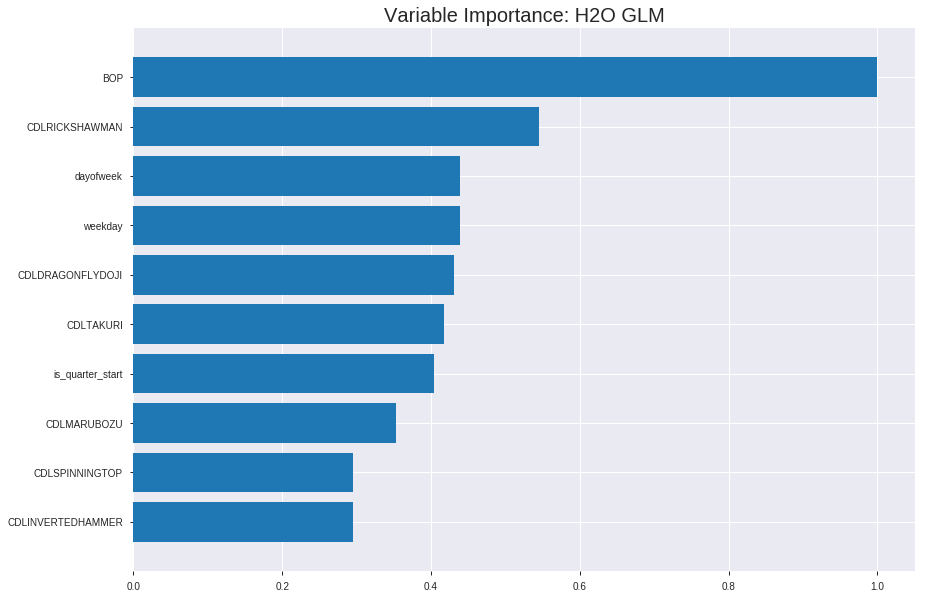

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_015405_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23753549042034466
RMSE: 0.487376128283223
LogLoss: 0.6676893322855147
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2476.0717307928226
Residual deviance: 2386.3216735884303
AIC: 2488.3216735884303
AUC: 0.642894120006518
pr_auc: 0.6077548001127607
Gini: 0.28578824001303604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4256402896365256: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      189  728   0.7939   (728.0/917.0)
1      46   824   0.0529   (46.0/870.0)
Total  235  1552  0.4331   (774.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42564      0.680429  305
max f2                       0.397662     0.830571  336
max f0point5                 0.460259     0.601712  251
max accuracy                 0.460834     0.603805  250
max precision                0.932682     1         0
max recall                   0.214074     1         399
max specificity              0.932682     1         0
max absolute_mcc             0.448819     0.245327  273
max min_per_class_accuracy   0.49226      0.595402  191
max mean_per_class_accuracy  0.460259     0.609452  251

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.639841           1.8258    1.8258             0.888889         0.692599  0.888889                    0.692599            0.0183908       0.0183908                  82.5798   82.5798
    2        0.0201455                   0.589895           1.48346   1.65463            0.722222         0.612662  0.805556                    0.652631            0.0149425       0.0333333                  48.3461   65.463
    3        0.0302182                   0.577102           1.59757   1.63561            0.777778         0.58344   0.796296                    0.629567            0.016092        0.0494253                  59.7573   63.5611
    4        0.040291                    0.569523           1.02701   1.48346            0.5              0.572823  0.722222                    0.615381            0.0103448       0.0597701                  2.70115   48.3461
    5        0.0503637                   0.562791           1.36935   1.46064            0.666667         0.565426  0.711111                    0.60539             0.0137931       0.0735632                  36.9349   46.0639
    6        0.100168                    0.54945            1.24626   1.35405            0.606742         0.555999  0.659218                    0.580832            0.062069        0.135632                   24.6261   35.4049
    7        0.149972                    0.54               1.17702   1.29526            0.573034         0.544782  0.630597                    0.568861            0.0586207       0.194253                   17.7024   29.5261
    8        0.200336                    0.531839           1.3237    1.30241            0.644444         0.535762  0.634078                    0.56054             0.0666667       0.26092                    32.3704   30.2411
    9        0.299944                    0.519573           1.14241   1.24928            0.55618          0.525575  0.608209                    0.548928            0.113793        0.374713                   14.2406   24.9275
    10       0.400112                    0.505571           1.13602   1.22092            0.553073         0.512273  0.594406                    0.539752            0.113793        0.488506                   13.6024   22.0923
    11       0.50028                     0.491811           1.1016    1.19703            0.536313         0.498544  0.582774                    0.531501            0.110345        0.598851                   10.1599   19.7031
    12       0.599888                    0.478358           1.01547   1.16688            0.494382         0.485816  0.568097                    0.523915            0.101149        0.7                        1.5472    16.6884
    13       0.700056                    0.461659           1.09012   1.1559             0.530726         0.470432  0.56275                     0.516263            0.109195        0.809195                   9.01239   15.5901
    14       0.799664                    0.443239           0.888538  1.1226             0.432584         0.452793  0.546536                    0.508357            0.0885057       0.897701                   -11.1462  12.2598
    15       0.899832                    0.407502           0.677024  1.073              0.329609         0.428914  0.522388                    0.499513            0.0678161       0.965517                   -32.2976  7.29971
    16       1                           0.214074           0.34425   1                  0.167598         0.373088  0.486849                    0.486849          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24752083121853743
RMSE: 0.4975146542751655
LogLoss: 0.688187685358487
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.8026372780396
Residual deviance: 703.3278144363736
AIC: 805.3278144363736
AUC: 0.5647365196078431
pr_auc: 0.5444453536729202
Gini: 0.1294730392156862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3732796227906688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    246  0.9647   (246.0/255.0)
1      4    252  0.0156   (4.0/256.0)
Total  13   498  0.4892   (250.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37328      0.668435  387
max f2                       0.327925     0.833876  399
max f0point5                 0.47339      0.580467  256
max accuracy                 0.474721     0.567515  252
max precision                0.725736     1         0
max recall                   0.327925     1         399
max specificity              0.725736     1         0
max absolute_mcc             0.47339      0.143007  256
max min_per_class_accuracy   0.492628     0.542969  195
max mean_per_class_accuracy  0.474721     0.56721   252

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.582204           0.998047  0.998047           0.5              0.631041  0.5                         0.631041            0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.567244           0.798438  0.907315           0.4              0.574507  0.454545                    0.605344            0.0078125       0.0195312                  -20.1562   -9.26847
    3        0.0313112                   0.562001           1.59688   1.1228             0.8              0.563614  0.5625                      0.592303            0.015625        0.0351562                  59.6875    12.2803
    4        0.0410959                   0.560342           1.19766   1.14062            0.6              0.560938  0.571429                    0.584835            0.0117188       0.046875                   19.7656    14.0625
    5        0.0508806                   0.557348           0.798438  1.07482            0.4              0.559669  0.538462                    0.579996            0.0078125       0.0546875                  -20.1562   7.48197
    6        0.101761                    0.5466             1.45868   1.26675            0.730769         0.551193  0.634615                    0.565594            0.0742188       0.128906                   45.8684    26.6752
    7        0.150685                    0.53891            0.798438  1.1147             0.4              0.542564  0.558442                    0.558117            0.0390625       0.167969                   -20.1562   11.4702
    8        0.201566                    0.533118           1.15159   1.12401            0.576923         0.535668  0.563107                    0.55245             0.0585938       0.226562                   15.1593    12.4014
    9        0.30137                     0.51441            1.13503   1.12766            0.568627         0.523225  0.564935                    0.542772            0.113281        0.339844                   13.5034    12.7663
    10       0.401174                    0.503316           1.09589   1.11976            0.54902          0.508724  0.560976                    0.534301            0.109375        0.449219                   9.58946    11.976
    11       0.500978                    0.491958           0.939338  1.08382            0.470588         0.497457  0.542969                    0.526961            0.09375         0.542969                   -6.06618   8.38165
    12       0.600783                    0.480773           1.09589   1.08582            0.54902          0.486426  0.543974                    0.520227            0.109375        0.652344                   9.58946    8.5823
    13       0.700587                    0.467588           1.05676   1.08168            0.529412         0.474978  0.541899                    0.513781            0.105469        0.757812                   5.67555    8.16821
    14       0.800391                    0.452562           0.782782  1.04441            0.392157         0.461261  0.523227                    0.507232            0.078125        0.835938                   -21.7218   4.44109
    15       0.900196                    0.426456           0.782782  1.0154             0.392157         0.441416  0.508696                    0.499935            0.078125        0.914062                   -21.7218   1.54042
    16       1                           0.327925           0.86106   1                  0.431373         0.39009   0.500978                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:54:06  0.000 sec   2            7.6       51            1.379             1.38461
    2019-07-25 01:54:06  0.024 sec   4            4.7       51            1.37549           1.38339
    2019-07-25 01:54:06  0.054 sec   6            2.9       51            1.3705            1.38178
    2019-07-25 01:54:06  0.081 sec   8            1.8       51            1.36379           1.37987
    2019-07-25 01:54:06  0.105 sec   10           1.1       51            1.35538           1.37797
    2019-07-25 01:54:06  0.126 sec   12           0.7       51            1.34567           1.3766
    2019-07-25 01:54:06  0.143 sec   14           0.43      51            1.33538           1.37638
    2019-07-25 01:54:06  0.159 sec   16           0.27      51            1.32531           1.37781
    2019-07-25 01:54:06  0.176 sec   18           0.17      51            1.31616           1.38115
    2019-07-25 01:54:06  0.194 sec   20           0.1       51            1.3084            1.38635
    2019-07-25 01:54:06  0.210 sec   22           0.065     51            1.30217           1.39311
    2019-07-25 01:54:06  0.234 sec   24           0.04      51            1.2973            1.40091

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.546875)

('F1', 0.6382978723404256)

('auc', 0.5137867647058824)

('logloss', 0.6945012104039979)

('mean_per_class_error', 0.45833333333333337)

('rmse', 0.500645592369203)

('mse', 0.25064600915871016)

glm prediction progress: |████████████████████████████████████████████████| 100%


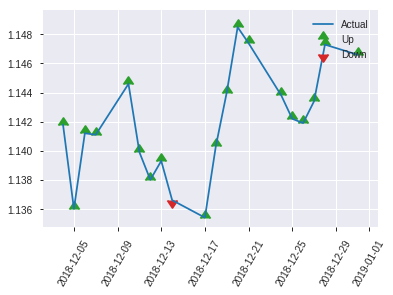


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25064600915871016
RMSE: 0.500645592369203
LogLoss: 0.6945012104039979
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.2266765121979
Residual deviance: 355.58461972684694
AIC: 457.58461972684694
AUC: 0.5137867647058824
pr_auc: 0.45877413702230746
Gini: 0.02757352941176472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3381275886774832: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    136  1        (136.0/136.0)
1      0    120  0        (0.0/120.0)
Total  0    256  0.5312   (136.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338128     0.638298  255
max f2                       0.338128     0.815217  255
max f0point5                 0.455822     0.534979  212
max accuracy                 0.508222     0.546875  103
max precision                0.508222     0.519231  103
max recall                   0.338128     1         255
max specificity              0.62321      0.992647  0
max absolute_mcc             0.565805     0.109497  6
max min_per_class_accuracy   0.501037     0.508333  125
max mean_per_class_accuracy  0.507865     0.541667  105

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.570958           0         0                  0                0.58941   0                           0.58941             0               0                          -100      -100
    2        0.0234375                   0.566969           0.711111  0.355556           0.333333         0.568191  0.166667                    0.5788              0.00833333      0.00833333                 -28.8889  -64.4444
    3        0.03125                     0.563058           1.06667   0.533333           0.5              0.565562  0.25                        0.575491            0.00833333      0.0166667                  6.66667   -46.6667
    4        0.0429688                   0.560108           2.13333   0.969697           1                0.561243  0.454545                    0.571605            0.025           0.0416667                  113.333   -3.0303
    5        0.0507812                   0.553902           1.06667   0.984615           0.5              0.557275  0.461538                    0.5694              0.00833333      0.05                       6.66667   -1.53846
    6        0.101562                    0.540871           0.65641   0.820513           0.307692         0.547318  0.384615                    0.558359            0.0333333       0.0833333                  -34.359   -17.9487
    7        0.152344                    0.53489            1.14872   0.929915           0.538462         0.538412  0.435897                    0.55171             0.0583333       0.141667                   14.8718   -7.00855
    8        0.203125                    0.530215           0.65641   0.861538           0.307692         0.532865  0.403846                    0.546999            0.0333333       0.175                      -34.359   -13.8462
    9        0.300781                    0.516264           1.19467   0.969697           0.56             0.522696  0.454545                    0.539108            0.116667        0.291667                   19.4667   -3.0303
    10       0.402344                    0.508228           1.47692   1.09773            0.692308         0.512004  0.514563                    0.532266            0.15            0.441667                   47.6923   9.77346
    11       0.5                         0.498949           0.682667  1.01667            0.32             0.503984  0.476562                    0.526742            0.0666667       0.508333                   -31.7333  1.66667
    12       0.601562                    0.489187           0.984615  1.01126            0.461538         0.493351  0.474026                    0.521105            0.1             0.608333                   -1.53846  1.12554
    13       0.699219                    0.474084           1.10933   1.02495            0.52             0.481677  0.480447                    0.515598            0.108333        0.716667                   10.9333   2.49534
    14       0.800781                    0.461955           1.14872   1.04065            0.538462         0.468704  0.487805                    0.509651            0.116667        0.833333                   14.8718   4.06504
    15       0.898438                    0.432212           0.853333  1.02029            0.4              0.448189  0.478261                    0.50297             0.0833333       0.916667                   -14.6667  2.02899
    16       1                           0.338128           0.820513  1                  0.384615         0.403105  0.46875                     0.492828      

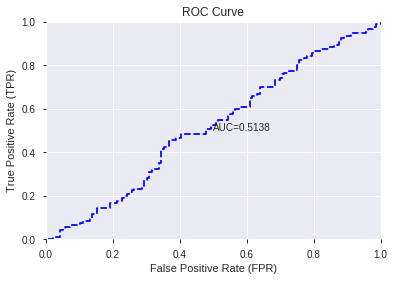

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


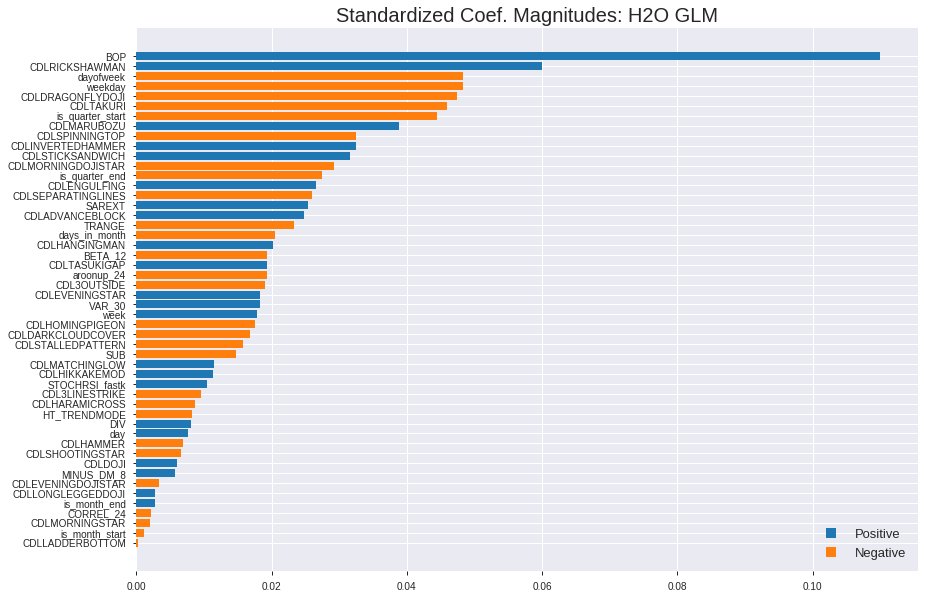

'log_likelihood'
--2019-07-25 01:54:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_015405_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_015405_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_quarter_start',
 'CDLMARUBOZU',
 'CDLSPINNINGTOP',
 'CDLINVERTEDHAMMER',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'is_quarter_end',
 'CDLENGULFING',
 'CDLSEPARATINGLINES',
 'SAREXT',
 'CDLADVANCEBLOCK',
 'TRANGE',
 'days_in_month',
 'CDLHANGINGMAN',
 'BETA_12',
 'CDLTASUKIGAP',
 'aroonup_24',
 'CDL3OUTSIDE',
 'CDLEVENINGSTAR',
 'VAR_30',
 'week',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'CDL3LINESTRIKE',
 'CDLHARAMICROSS',
 'HT_TRENDMODE',
 'DIV',
 'day',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLDOJI',
 'MINUS_DM_8',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'is_month_start',
 'CDLLADDERBOTTOM']

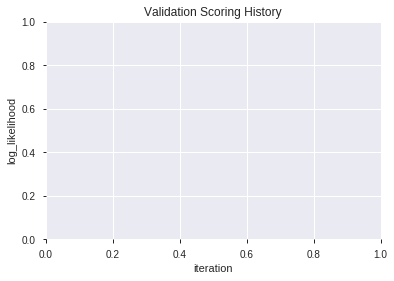

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_015419_model_5  0.638480  0.665005              0.401961  0.486205  0.236396
1               XGBoost_3_AutoML_20190725_015419  0.624326  0.669114              0.436275  0.488028  0.238171
2  XGBoost_grid_1_AutoML_20190725_015419_model_3  0.623775  0.671275              0.407598  0.489066  0.239185
3  XGBoost_grid_1_AutoML_20190725_015419_model_2  0.623713  0.670005              0.457353  0.488538  0.238670
4  XGBoost_grid_1_AutoML_20190725_015419_model_1  0.618199  0.674084              0.413480  0.490455  0.240547
5  XGBoost_grid_1_AutoML_20190725_015419_model_4  0.616850  0.673273              0.399755  0.490133  0.240231
6               XGBoost_2_AutoML_20190725_015419  0.611152  0.678661              0.387500  0.492477  0.242534
7  XGBoost_grid_1_AutoML_20190725_015419_model_6  0.599939  0.677619              0.485294  0.492269  0.242328
8               XGBoost_1_AutoML_20190725_015419  0.593444  0.685439              0.404902  0.495874  0.245891
9  XGBoost_grid_1_AutoML_20190725_015419_model_7  0.593321  0.680097              0.427941  0.493676  0.243716

variable  relative_importance  scaled_importance  percentage
0                  BOP          2325.722412           1.000000    0.094562
1               SAREXT          2172.297607           0.934031    0.088324
2            CORREL_24          1961.895752           0.843564    0.079769
3               TRANGE          1893.610352           0.814203    0.076993
4           MINUS_DM_8          1880.887573           0.808733    0.076475
5                  day          1826.986206           0.785556    0.074284
6                  DIV          1825.569946           0.784947    0.074226
7               VAR_30          1663.242798           0.715151    0.067626
8                 week          1636.876099           0.703814    0.066554
9              BETA_12          1284.345459           0.552235    0.052220
10          aroonup_24          1135.248413           0.488127    0.046158
11                 SUB          1094.847900           0.470756    0.044516
12      STOCHRSI_fastk          1021.880798           0.439382    0.041549
13           dayofweek           786.949036           0.338368    0.031997
14             weekday           339.295074           0.145888    0.013795
15       days_in_month           273.186890           0.117463    0.011108
16      CDLSPINNINGTOP           254.336060           0.109358    0.010341
17      CDLRICKSHAWMAN           199.709427           0.085870    0.008120
18        HT_TRENDMODE           179.085800           0.077002    0.007281
19    CDLDRAGONFLYDOJI           130.111588           0.055945    0.005290
20           CDLTAKURI            86.934891           0.037380    0.003535
21        is_month_end            78.864639           0.033910    0.003207
22     CDLSHOOTINGSTAR            67.023018           0.028818    0.002725
23   CDLINVERTEDHAMMER            61.683289           0.026522    0.002508
24       CDLHANGINGMAN            56.605217           0.024339    0.002302
25             CDLDOJI            50.350151           0.021649    0.002047
26    is_quarter_start            39.463085           0.016968    0.001605
27      is_quarter_end            38.758274           0.016665    0.001576
28      is_month_start            33.421898           0.014371    0.001359
29   CDLLONGLEGGEDDOJI            31.526264           0.013555    0.001282
30           CDLHAMMER            30.407473           0.013074    0.001236
31         CDL3OUTSIDE            24.052794           0.010342    0.000978
32        CDLENGULFING            20.441177           0.008789    0.000831
33         CDLMARUBOZU            16.566668           0.007123    0.000674
34      CDLMATCHINGLOW            13.798520           0.005933    0.000561
35     CDLADVANCEBLOCK            12.140246           0.005220    0.000494
36  CDLEVENINGDOJISTAR            10.840153           0.004661    0.000441
37  CDLSEPARATINGLINES            10.582182           0.004550    0.000430
38      CDLHARAMICROSS             6.268926           0.002695    0.000255
39      CDLEVENINGSTAR             3.872048           0.001665    0.000157
40  CDLMORNINGDOJISTAR             3.832623           0.001648    0.000156
41      CDLMORNINGSTAR             2.995962           0.001288    0.000122
42    CDLSTICKSANDWICH             2.335491           0.001004    0.000095
43       CDLHIKKAKEMOD             2.334439           0.001004    0.000095
44      CDL3LINESTRIKE             1.824176           0.000784    0.000074
45     CDLLADDERBOTTOM             1.678004           0.000721    0.000068

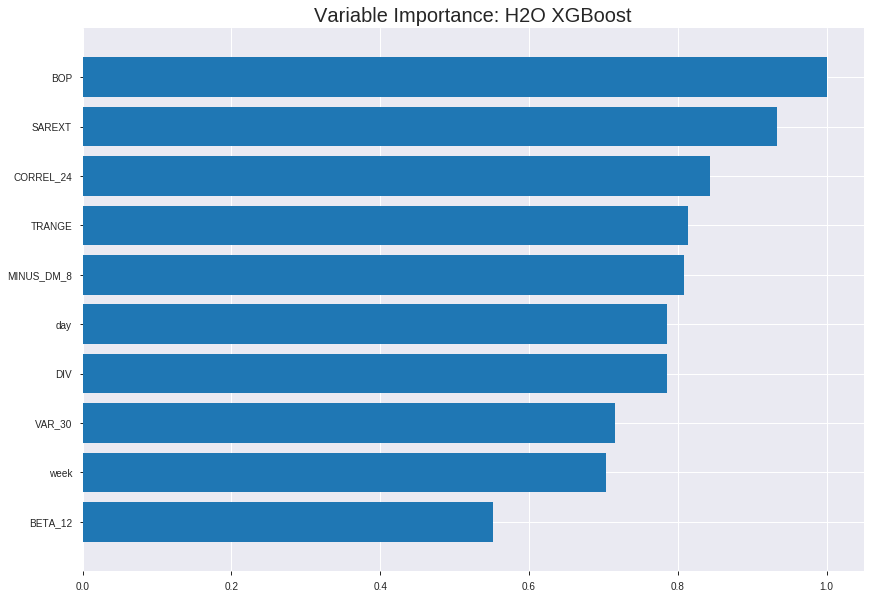

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_015419_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04543791603859915
RMSE: 0.21316171335068396
LogLoss: 0.22886371675652648
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988505747126437
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49776655435562134: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      917  0    0        (0.0/917.0)
1      0    870  0        (0.0/870.0)
Total  917  870  0        (0.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.497767     1        193
max f2                       0.497767     1        193
max f0point5                 0.497767     1        193
max accuracy                 0.497767     1        193
max precision                0.922888     1        0
max recall                   0.497767     1        193
max specificity              0.922888     1        0
max absolute_mcc             0.497767     1        193
max min_per_class_accuracy   0.497767     1        193
max mean_per_class_accuracy  0.497767     1        193

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.79 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100727                   0.898059           2.05402  2.05402            1                0.909197   1                           0.909197            0.0206897       0.0206897                  105.402  105.402
    2        0.0201455                   0.88656            2.05402  2.05402            1                0.891095   1                           0.900146            0.0206897       0.0413793                  105.402  105.402
    3        0.0302182                   0.877978           2.05402  2.05402            1                0.881879   1                           0.894057            0.0206897       0.062069                   105.402  105.402
    4        0.040291                    0.872771           2.05402  2.05402            1                0.875111   1                           0.88932             0.0206897       0.0827586                  105.402  105.402
    5        0.0503637                   0.868333           2.05402  2.05402            1                0.870342   1                           0.885525            0.0206897       0.103448                   105.402  105.402
    6        0.100168                    0.849645           2.05402  2.05402            1                0.858329   1                           0.872003            0.102299        0.205747                   105.402  105.402
    7        0.149972                    0.834804           2.05402  2.05402            1                0.842085   1                           0.862067            0.102299        0.308046                   105.402  105.402
    8        0.200336                    0.817307           2.05402  2.05402            1                0.825691   1                           0.852923            0.103448        0.411494                   105.402  105.402
    9        0.299944                    0.781829           2.05402  2.05402            1                0.801401   1                           0.835813            0.204598        0.616092                   105.402  105.402
    10       0.400112                    0.736619           2.05402  2.05402            1                0.762245   1                           0.817395            0.205747        0.821839                   105.402  105.402
    11       0.50028                     0.35161            1.77862  1.99888            0.865922         0.647239   0.973154                    0.783326            0.178161        1                          77.8623  99.8881
    12       0.599888                    0.252827           0        1.66698            0                0.290642   0.811567                    0.701518            0               1                          -100     66.6978
    13       0.700056                    0.207696           0        1.42846            0                0.228396   0.695444                    0.633821            0               1                          -100     42.8457
    14       0.799664                    0.173621           0        1.25052            0                0.190453   0.608817                    0.578594            0               1                          -100     25.0525
    15       0.899832                    0.12873            0        1.11132            0                0.152731   0.541045                    0.531188            0               1                          -100     11.1318
    16       1                           0.053072           0        1                  0                0.0991285  0.486849                    0.487909            0             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2500791726353568
RMSE: 0.500079166368043
LogLoss: 0.6949541756254042
Mean Per-Class Error: 0.430453431372549
AUC: 0.5825444240196078
pr_auc: 0.5660038182498459
Gini: 0.16508884803921564
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34745609760284424: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   204  0.8      (204.0/255.0)
1      21   235  0.082    (21.0/256.0)
Total  72   439  0.4403   (225.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347456     0.676259  334
max f2                       0.205032     0.836066  389
max f0point5                 0.347456     0.583996  334
max accuracy                 0.523856     0.569472  192
max precision                0.889581     1         0
max recall                   0.145607     1         396
max specificity              0.889581     1         0
max absolute_mcc             0.347456     0.169535  334
max min_per_class_accuracy   0.514471     0.552941  203
max mean_per_class_accuracy  0.523856     0.569547  192

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.832178           1.33073   1.33073            0.666667         0.855038  0.666667                    0.855038            0.015625        0.015625                   33.0729   33.0729
    2        0.0215264                   0.806387           1.19766   1.27024            0.6              0.814762  0.636364                    0.836731            0.0117188       0.0273438                  19.7656   27.0241
    3        0.0313112                   0.799098           1.59688   1.37231            0.8              0.803456  0.6875                      0.826333            0.015625        0.0429688                  59.6875   37.2314
    4        0.0410959                   0.775891           1.99609   1.52083            1                0.786038  0.761905                    0.816739            0.0195312       0.0625                     99.6094   52.0833
    5        0.0508806                   0.760421           0.798438  1.38191            0.4              0.768137  0.692308                    0.807392            0.0078125       0.0703125                  -20.1562  38.1911
    6        0.101761                    0.709687           0.844501  1.11321            0.423077         0.729513  0.557692                    0.768452            0.0429688       0.113281                   -15.5499  11.3206
    7        0.150685                    0.675465           1.19766   1.14062            0.6              0.69225   0.571429                    0.743711            0.0585938       0.171875                   19.7656   14.0625
    8        0.201566                    0.650392           1.30514   1.18215            0.653846         0.660342  0.592233                    0.722667            0.0664062       0.238281                   30.5138   18.2153
    9        0.30137                     0.597233           1.17417   1.17951            0.588235         0.622575  0.590909                    0.68952             0.117188        0.355469                   17.4173   17.951
    10       0.401174                    0.555668           0.978477  1.1295             0.490196         0.575945  0.565854                    0.661264            0.0976562       0.453125                   -2.15227  12.9497
    11       0.500978                    0.514493           1.05676   1.11501            0.529412         0.53243   0.558594                    0.635598            0.105469        0.558594                   5.67555   11.5005
    12       0.600783                    0.476589           0.900199  1.07932            0.45098          0.496429  0.540717                    0.612479            0.0898438       0.648438                   -9.98009  7.93211
    13       0.700587                    0.437062           1.01762   1.07053            0.509804         0.454861  0.536313                    0.590025            0.101562        0.75                       1.76164   7.05307
    14       0.800391                    0.382796           1.05676   1.06881            0.529412         0.409092  0.535452                    0.567464            0.105469        0.855469                   5.67555   6.8813
    15       0.900196                    0.319311           0.900199  1.05012            0.45098          0.349678  0.526087                    0.543318            0.0898438       0.945312                   -9.98009  5.01189
    16       1                           0.114726           0.547947  1                  0.27451          0.253302  0.500978                    0.514373           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:54:27  3.074 sec   0                  0.5              0.693147            0.5             0                  1                0.513151                         0.5                0.693147              0.5               0                    1                  0.499022
    2019-07-25 01:54:27  3.404 sec   5                  0.448112         0.593943            0.966838        0.963111           2.05402          0.0867375                        0.499831           0.692841              0.532177          0.517795             1.33073            0.479452
    2019-07-25 01:54:27  3.649 sec   10                 0.408889         0.524171            0.99234         0.991252           2.05402          0.0408506                        0.496025           0.685186              0.574249          0.561426             1.33073            0.489237
    2019-07-25 01:54:27  3.901 sec   15                 0.370394         0.459572            0.998323        0.996072           2.05402          0.0173475                        0.494264           0.681584              0.586972          0.571389             1.66341            0.46184
    2019-07-25 01:54:28  4.149 sec   20                 0.338374         0.408427            0.999495        0.997189           2.05402          0.0100727                        0.495495           0.684194              0.581824          0.560865             1.33073            0.483366
    2019-07-25 01:54:28  4.413 sec   25                 0.310101         0.36501             0.99991         0.998757           2.05402          0.00447678                       0.495771           0.684635              0.581886          0.57194              1.99609            0.485323
    2019-07-25 01:54:28  4.695 sec   30                 0.28481          0.327592            0.999974        0.998824           2.05402          0.00279799                       0.494605           0.682244              0.589851          0.5751               1.99609            0.481409
    2019-07-25 01:54:28  5.006 sec   35                 0.263048         0.29654             0.999999        0.9977             2.05402          0.000559597                      0.495647           0.684663              0.590786          0.573068             1.66341            0.469667
    2019-07-25 01:54:29  5.317 sec   40                 0.245835         0.272403            0.999999        0.99885            2.05402          0.000559597                      0.496283           0.686391              0.592295          0.571815             1.33073            0.454012
    2019-07-25 01:54:29  5.638 sec   45                 0.228759         0.249259            0.999999        0.99885            2.05402          0.000559597                      0.498012           0.690196              0.587048          0.568254             1.66341            0.455969
    2019-07-25 01:54:29  5.959 sec   50                 0.213162         0.228864            1               0.998851           2.05402          0                                0.500079           0.694954              0.582544          0.566004             1.33073            0.440313

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               2325.722412109375      1.0                    0.09456198532916812
SAREXT            2172.297607421875      0.9340313341400244     0.08832385731593231
CORREL_24         1961.895751953125      0.8435640219735993     0.07976908867008155
TRANGE            1893.6103515625        0.8142030801711372     0.07699265972210657
MINUS_DM_8        1880.8875732421875     0.8087326172069981     0.07647536188354791
---               ---                    ---                    ---
CDLMORNINGSTAR    2.995962381362915      0.0012881857120023402  0.00012181339839960929
CDLSTICKSANDWICH  2.335491418838501      0.0010042004181918967  9.495918521260663e-05
CDLHIKKAKEMOD     2.334439277648926      0.0010037480249122442  9.491640600593313e-05
CDL3LINESTRIKE    1.82417631149292       0.0007843482532545384  7.41695280172143e-05
CDLLADDERBOTTOM   1.6780035495758057     0.0007214977767075377  6.82262621760456e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.61328125)

('F1', 0.6707317073170732)

('auc', 0.6384803921568627)

('logloss', 0.6650048876855239)

('mean_per_class_error', 0.37745098039215685)

('rmse', 0.4862052934889507)

('mse', 0.23639558741667668)

xgboost prediction progress: |████████████████████████████████████████████| 100%


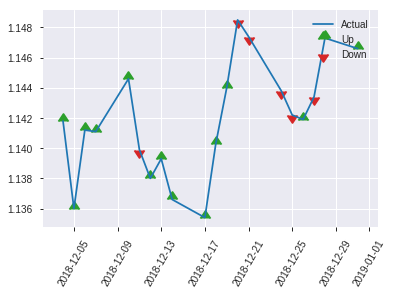


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23639558741667668
RMSE: 0.4862052934889507
LogLoss: 0.6650048876855239
Mean Per-Class Error: 0.37745098039215685
AUC: 0.6384803921568627
pr_auc: 0.5609469100065387
Gini: 0.2769607843137254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3374643623828888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   98   0.7206   (98.0/136.0)
1      10   110  0.0833   (10.0/120.0)
Total  48   208  0.4219   (108.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337464     0.670732  207
max f2                       0.245413     0.826446  245
max f0point5                 0.396549     0.595238  179
max accuracy                 0.476159     0.613281  142
max precision                0.815117     1         0
max recall                   0.245413     1         245
max specificity              0.815117     1         0
max absolute_mcc             0.396549     0.267705  179
max min_per_class_accuracy   0.497274     0.588235  126
max mean_per_class_accuracy  0.396549     0.622549  179

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.802142           0.711111  0.711111           0.333333         0.807892  0.333333                    0.807892            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.790458           0.711111  0.711111           0.333333         0.795367  0.333333                    0.801629            0.00833333      0.0166667                  -28.8889  -28.8889
    3        0.03125                     0.783008           2.13333   1.06667            1                0.785352  0.5                         0.79756             0.0166667       0.0333333                  113.333   6.66667
    4        0.0429688                   0.763686           1.42222   1.16364            0.666667         0.773438  0.545455                    0.790981            0.0166667       0.05                       42.2222   16.3636
    5        0.0507812                   0.751121           2.13333   1.31282            1                0.751615  0.615385                    0.784925            0.0166667       0.0666667                  113.333   31.2821
    6        0.101562                    0.705554           1.47692   1.39487            0.692308         0.725462  0.653846                    0.755193            0.075           0.141667                   47.6923   39.4872
    7        0.152344                    0.668879           1.14872   1.31282            0.538462         0.68512   0.615385                    0.731836            0.0583333       0.2                        14.8718   31.2821
    8        0.203125                    0.641834           1.31282   1.31282            0.615385         0.651856  0.615385                    0.711841            0.0666667       0.266667                   31.2821   31.2821
    9        0.300781                    0.607159           1.10933   1.24675            0.52             0.626839  0.584416                    0.684243            0.108333        0.375                      10.9333   24.6753
    10       0.402344                    0.540958           0.902564  1.15987            0.423077         0.576113  0.543689                    0.656948            0.0916667       0.466667                   -9.74359  15.9871
    11       0.5                         0.496498           1.36533   1.2                0.64             0.517286  0.5625                      0.62967             0.133333        0.6                        36.5333   20
    12       0.601562                    0.459129           1.06667   1.17749            0.5              0.478469  0.551948                    0.604143            0.108333        0.708333                   6.66667   17.7489
    13       0.699219                    0.397351           1.19467   1.17989            0.56             0.434114  0.553073                    0.580395            0.116667        0.825                      19.4667   17.9888
    14       0.800781                    0.34204            0.65641   1.1135             0.307692         0.373084  0.521951                    0.554102            0.0666667       0.891667                   -34.359   11.3496
    15       0.898438                    0.288901           0.597333  1.05739            0.28             0.318389  0.495652                    0.528481            0.0583333       0.95                       -40.2667  5.73913
    16       1                           0.154016           0.492308  1                  0.230769         0.240829  0.46875                     0.499267            

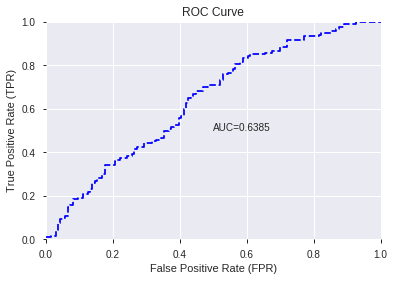

This function is available for GLM models only


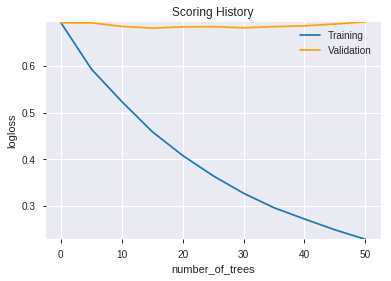

--2019-07-25 01:54:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_015419_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_015419_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SAREXT',
 'CORREL_24',
 'TRANGE',
 'MINUS_DM_8',
 'day',
 'DIV',
 'VAR_30',
 'week',
 'BETA_12',
 'aroonup_24',
 'SUB',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday',
 'days_in_month',
 'CDLSPINNINGTOP',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_end',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDOJI',
 'is_quarter_start',
 'is_quarter_end',
 'is_month_start',
 'CDLLONGLEGGEDDOJI',
 'CDLHAMMER',
 'CDL3OUTSIDE',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_015444_model_1  0.552083  0.68671               0.46152  0.496826  0.246836

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.098096           1.000000    0.034872
1               CDLRICKSHAWMAN             0.062317           0.635266    0.022153
2                 CDLSHORTLINE             0.047371           0.482902    0.016840
3                    dayofweek             0.046230           0.471268    0.016434
4                      weekday             0.046214           0.471103    0.016428
...                        ...                  ...                ...         ...
1018   BBANDS_upperband_20_5_3             0.000016           0.000159    0.000006
1019                   TEMA_14             0.000012           0.000127    0.000004
1020  BBANDS_middleband_20_6_2             0.000009           0.000094    0.000003
1021               MIDPOINT_20             0.000008           0.000081    0.000003
1022   BBANDS_upperband_12_6_2             0.000004           0.000036    0.000001

[1023 rows x 4 columns]

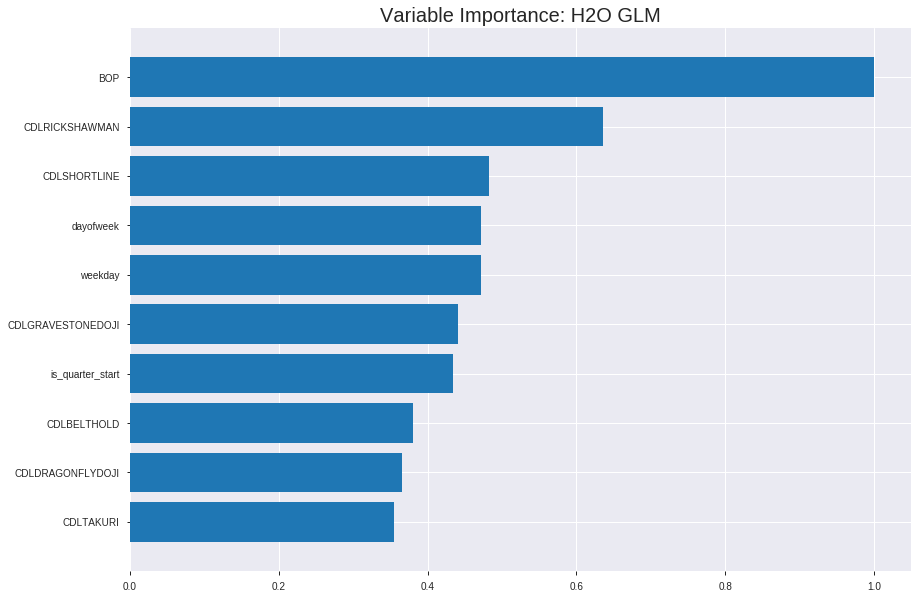

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_015444_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23192583107240017
RMSE: 0.4815867845699259
LogLoss: 0.656056984976983
Null degrees of freedom: 1786
Residual degrees of freedom: 763
Null deviance: 2476.0717307928226
Residual deviance: 2344.747664307737
AIC: 4392.747664307737
AUC: 0.6702565838127827
pr_auc: 0.6317203300164065
Gini: 0.3405131676255655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41122053545137977: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      238  679   0.7405   (679.0/917.0)
1      57   813   0.0655   (57.0/870.0)
Total  295  1492  0.4119   (736.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411221     0.6884    302
max f2                       0.380972     0.833333  333
max f0point5                 0.482206     0.619561  208
max accuracy                 0.48586      0.628987  202
max precision                0.920495     1         0
max recall                   0.16234      1         399
max specificity              0.920495     1         0
max absolute_mcc             0.459262     0.271564  243
max min_per_class_accuracy   0.491321     0.620502  195
max mean_per_class_accuracy  0.482206     0.630483  208

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.673349           1.93991   1.93991            0.944444         0.725595  0.944444                    0.725595            0.0195402       0.0195402                  93.9911   93.9911
    2        0.0201455                   0.641305           1.48346   1.71169            0.722222         0.656761  0.833333                    0.691178            0.0149425       0.0344828                  48.3461   71.1686
    3        0.0302182                   0.622565           1.71169   1.71169            0.833333         0.630142  0.833333                    0.670833            0.0172414       0.0517241                  71.1686   71.1686
    4        0.040291                    0.612873           1.36935   1.6261             0.666667         0.618213  0.791667                    0.657678            0.0137931       0.0655172                  36.9349   62.6102
    5        0.0503637                   0.605086           1.36935   1.57475            0.666667         0.608714  0.766667                    0.647885            0.0137931       0.0793103                  36.9349   57.4751
    6        0.100168                    0.57855            1.2001    1.38847            0.58427          0.589936  0.675978                    0.619072            0.0597701       0.13908                    20.0103   38.8474
    7        0.149972                    0.563722           1.24626   1.34125            0.606742         0.571902  0.652985                    0.603408            0.062069        0.201149                   24.6261   34.1246
    8        0.200336                    0.549918           1.20959   1.30815            0.588889         0.556119  0.636872                    0.591519            0.0609195       0.262069                   20.9591   30.8149
    9        0.299944                    0.528165           1.32704   1.31442            0.646067         0.539146  0.639925                    0.574127            0.132184        0.394253                   32.7037   31.4421
    10       0.400112                    0.508544           1.12455   1.26689            0.547486         0.518265  0.616783                    0.560142            0.112644        0.506897                   12.4549   26.6887
    11       0.50028                     0.490594           1.1475    1.24298            0.558659         0.499313  0.605145                    0.547962            0.114943        0.621839                   14.7499   24.2983
    12       0.599888                    0.473273           1.07317   1.21479            0.522472         0.482154  0.591418                    0.537035            0.106897        0.728736                   7.31693   21.4786
    13       0.700056                    0.45086            0.975374  1.18053            0.47486          0.462695  0.57474                     0.526398            0.0977011       0.826437                   -2.4626   18.053
    14       0.799664                    0.423035           0.773143  1.12978            0.376404         0.437543  0.550035                    0.51533             0.0770115       0.903448                   -22.6857  12.9785
    15       0.899832                    0.382372           0.677024  1.07938            0.329609         0.40415   0.525498                    0.502954            0.0678161       0.971264                   -32.2976  7.9384
    16       1                           0.16234            0.286875  1                  0.139665         0.34218   0.486849                    0.486849           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24747554795139828
RMSE: 0.4974691427127901
LogLoss: 0.6880306594083805
Null degrees of freedom: 510
Residual degrees of freedom: -513
Null deviance: 708.8026372780396
Residual deviance: 703.1673339153649
AIC: 2751.167333915365
AUC: 0.5639859068627451
pr_auc: 0.562517746521592
Gini: 0.12797181372549016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34109010979666526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   245  0.9608   (245.0/255.0)
1      3    253  0.0117   (3.0/256.0)
Total  13   498  0.4853   (248.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34109      0.671088  386
max f2                       0.304933     0.836055  395
max f0point5                 0.445761     0.576923  248
max accuracy                 0.445761     0.565558  248
max precision                0.685081     1         0
max recall                   0.304933     1         395
max specificity              0.685081     1         0
max absolute_mcc             0.445761     0.13585   248
max min_per_class_accuracy   0.470703     0.537255  198
max mean_per_class_accuracy  0.445761     0.565288  248

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 46.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.597652           1.33073   1.33073            0.666667         0.629048  0.666667                    0.629048            0.015625        0.015625                   33.0729    33.0729
    2        0.0215264                   0.588538           1.99609   1.63317            1                0.591019  0.818182                    0.611762            0.0195312       0.0351562                  99.6094    63.3168
    3        0.0313112                   0.581102           1.19766   1.49707            0.6              0.584544  0.75                        0.603256            0.0117188       0.046875                   19.7656    49.707
    4        0.0410959                   0.575412           1.59688   1.52083            0.8              0.577519  0.761905                    0.597128            0.015625        0.0625                     59.6875    52.0833
    5        0.0508806                   0.571053           1.19766   1.45868            0.6              0.573507  0.730769                    0.592586            0.0117188       0.0742188                  19.7656    45.8684
    6        0.101761                    0.544897           1.22837   1.34352            0.615385         0.554857  0.673077                    0.573722            0.0625          0.136719                   22.8365    34.3525
    7        0.150685                    0.53177            0.878281  1.19247            0.44             0.537658  0.597403                    0.562013            0.0429688       0.179688                   -12.1719   19.2472
    8        0.201566                    0.520091           0.998047  1.14339            0.5              0.524969  0.572816                    0.552662            0.0507812       0.230469                   -0.195312  14.3394
    9        0.30137                     0.504275           0.978477  1.08878            0.490196         0.5124    0.545455                    0.539328            0.0976562       0.328125                   -2.15227   8.87784
    10       0.401174                    0.484944           1.09589   1.09055            0.54902          0.494203  0.546341                    0.528102            0.109375        0.4375                     9.58946    9.05488
    11       0.500978                    0.470758           1.01762   1.07602            0.509804         0.47857   0.539062                    0.518234            0.101562        0.539062                   1.76164    7.60193
    12       0.600783                    0.452954           1.13503   1.08582            0.568627         0.461335  0.543974                    0.508782            0.113281        0.652344                   13.5034    8.5823
    13       0.700587                    0.433589           0.900199  1.05938            0.45098          0.443345  0.530726                    0.49946             0.0898438       0.742188                   -9.98009   5.93794
    14       0.800391                    0.415711           0.978477  1.04929            0.490196         0.424679  0.525672                    0.490135            0.0976562       0.839844                   -2.15227   4.92913
    15       0.900196                    0.386036           0.743643  1.0154             0.372549         0.40203   0.508696                    0.480367            0.0742188       0.914062                   -25.6357   1.54042
    16       1                           0.272501           0.86106   1                  0.431373         0.352723  0.500978                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:54:48  0.000 sec   2            7.6       976           1.37292           1.3865
    2019-07-25 01:54:50  1.974 sec   4            5.5       978           1.36929           1.38586
    2019-07-25 01:54:52  3.948 sec   6            4         984           1.36485           1.38493
    2019-07-25 01:54:54  5.947 sec   8            2.9       997           1.35952           1.38369
    2019-07-25 01:54:56  7.892 sec   10           2.1       1002          1.35329           1.38218
    2019-07-25 01:54:58  9.824 sec   12           1.5       1009          1.34619           1.38053
    2019-07-25 01:55:00  11.823 sec  14           1.1       1024          1.33833           1.37891
    2019-07-25 01:55:02  13.861 sec  16           0.82      1024          1.3299            1.37744
    2019-07-25 01:55:04  15.868 sec  18           0.6       1024          1.32109           1.37641
    2019-07-25 01:55:06  17.836 sec  20           0.43      1024          1.31211           1.37606
    2019-07-25 01:55:08  19.999 sec  22           0.32      1024          1.30316           1.37653
    2019-07-25 01:55:10  22.007 sec  24           0.23      1024          1.29433           1.37788
    2019-07-25 01:55:12  23.987 sec  26           0.17      1024          1.28573           1.38009
    2019-07-25 01:55:14  25.938 sec  28           0.12      1024          1.27739           1.38304
    2019-07-25 01:55:16  27.855 sec  30           0.089     1024          1.26932           1.38655

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55078125)

('F1', 0.6498599439775912)

('auc', 0.5520833333333333)

('logloss', 0.6867099164071773)

('mean_per_class_error', 0.4375)

('rmse', 0.49682623806426784)

('mse', 0.24683631082909252)

glm prediction progress: |████████████████████████████████████████████████| 100%


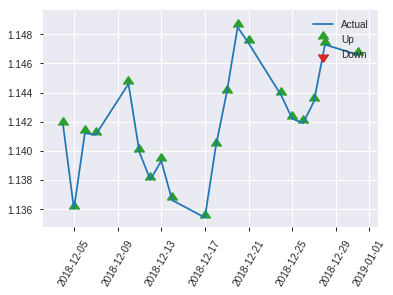


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24683631082909252
RMSE: 0.49682623806426784
LogLoss: 0.6867099164071773
Null degrees of freedom: 255
Residual degrees of freedom: -768
Null deviance: 354.2266765121979
Residual deviance: 351.59547720047476
AIC: 2399.5954772004748
AUC: 0.5520833333333333
pr_auc: 0.48911074340321464
Gini: 0.10416666666666652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3799264720734038: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   121  0.8897   (121.0/136.0)
1      4    116  0.0333   (4.0/120.0)
Total  19   237  0.4883   (125.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379926     0.64986   236
max f2                       0.299612     0.815217  255
max f0point5                 0.42152      0.553797  206
max accuracy                 0.450763     0.550781  168
max precision                0.558608     0.529412  16
max recall                   0.299612     1         255
max specificity              0.61146      0.992647  0
max absolute_mcc             0.42152      0.158558  206
max min_per_class_accuracy   0.474403     0.529412  127
max mean_per_class_accuracy  0.42152      0.5625    206

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 47.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.581621           0.711111  0.711111           0.333333         0.598728  0.333333                    0.598728            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.577035           1.42222   1.06667            0.666667         0.579307  0.5                         0.589017            0.0166667       0.025                      42.2222   6.66667
    3        0.03125                     0.573792           0         0.8                0                0.575631  0.375                       0.585671            0               0.025                      -100      -20
    4        0.0429688                   0.568471           1.42222   0.969697           0.666667         0.57113   0.454545                    0.581705            0.0166667       0.0416667                  42.2222   -3.0303
    5        0.0507812                   0.562433           0         0.820513           0                0.564805  0.384615                    0.579105            0               0.0416667                  -100      -17.9487
    6        0.101562                    0.540546           1.14872   0.984615           0.538462         0.554426  0.461538                    0.566766            0.0583333       0.1                        14.8718   -1.53846
    7        0.152344                    0.53249            0.984615  0.984615           0.461538         0.53622   0.461538                    0.556584            0.05            0.15                       -1.53846  -1.53846
    8        0.203125                    0.52317            0.984615  0.984615           0.461538         0.526673  0.461538                    0.549106            0.05            0.2                        -1.53846  -1.53846
    9        0.300781                    0.502548           1.36533   1.10823            0.64             0.51342   0.519481                    0.53752             0.133333        0.333333                   36.5333   10.8225
    10       0.402344                    0.487586           1.06667   1.09773            0.5              0.495286  0.514563                    0.526859            0.108333        0.441667                   6.66667   9.77346
    11       0.5                         0.473525           0.938667  1.06667            0.44             0.480468  0.5                         0.517798            0.0916667       0.533333                   -6.13333  6.66667
    12       0.601562                    0.458623           1.06667   1.06667            0.5              0.465243  0.5                         0.508925            0.108333        0.641667                   6.66667   6.66667
    13       0.699219                    0.444169           1.024     1.06071            0.48             0.45089   0.497207                    0.50082             0.1             0.741667                   2.4       6.07076
    14       0.800781                    0.423457           1.23077   1.08228            0.576923         0.435115  0.507317                    0.492487            0.125           0.866667                   23.0769   8.22764
    15       0.898438                    0.39351            0.682667  1.03884            0.32             0.411982  0.486957                    0.483736            0.0666667       0.933333                   -31.7333  3.88406
    16       1                           0.299612           0.65641   1                  0.307692         0.36087   0.46875                     0.471257        

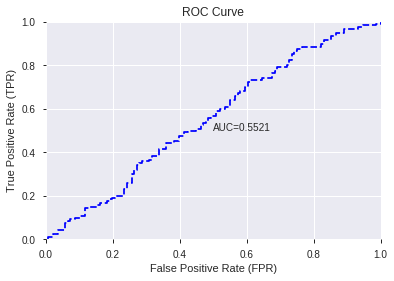

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


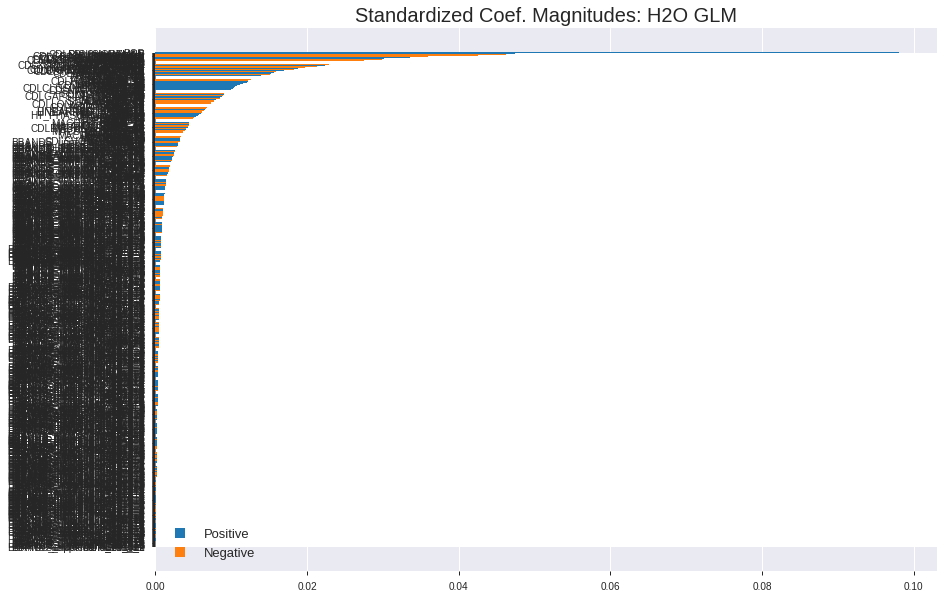

'log_likelihood'
--2019-07-25 01:55:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_015444_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_015444_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

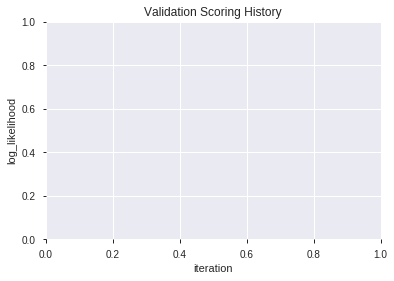

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_015546_model_4  0.666605  0.653355              0.377206  0.480309  0.230697
1               XGBoost_2_AutoML_20190725_015546  0.660600  0.658323              0.347059  0.482879  0.233173
2  XGBoost_grid_1_AutoML_20190725_015546_model_6  0.647059  0.658725              0.392157  0.483224  0.233505
3               XGBoost_3_AutoML_20190725_015546  0.633640  0.665349              0.386275  0.487063  0.237231
4  XGBoost_grid_1_AutoML_20190725_015546_model_7  0.629473  0.666717              0.408824  0.487483  0.237640
5  XGBoost_grid_1_AutoML_20190725_015546_model_2  0.624387  0.665005              0.414706  0.486508  0.236690
6  XGBoost_grid_1_AutoML_20190725_015546_model_3  0.619761  0.665409              0.423039  0.486763  0.236938
7               XGBoost_1_AutoML_20190725_015546  0.607475  0.676087              0.428922  0.491981  0.242046
8  XGBoost_grid_1_AutoML_20190725_015546_model_5  0.595037  0.699394              0.400980  0.503692  0.253706
9  XGBoost_grid_1_AutoML_20190725_015546_model_1  0.591789  0.687131              0.393137  0.497658  0.247663

variable  relative_importance  scaled_importance  percentage
0                        BOP           419.695435           1.000000    0.102333
1                        SUB           248.228287           0.591449    0.060525
2                        DIV           202.837708           0.483297    0.049457
3                     TRANGE           194.155991           0.462612    0.047340
4                aroondown_8           114.431808           0.272654    0.027901
..                       ...                  ...                ...         ...
151  BBANDS_lowerband_24_3_4             5.568120           0.013267    0.001358
152               aroonup_24             5.186991           0.012359    0.001265
153                   MAX_24             4.644510           0.011066    0.001132
154              STOCH_slowk             3.532546           0.008417    0.000861
155  BBANDS_upperband_14_3_5             2.230059           0.005314    0.000544

[156 rows x 4 columns]

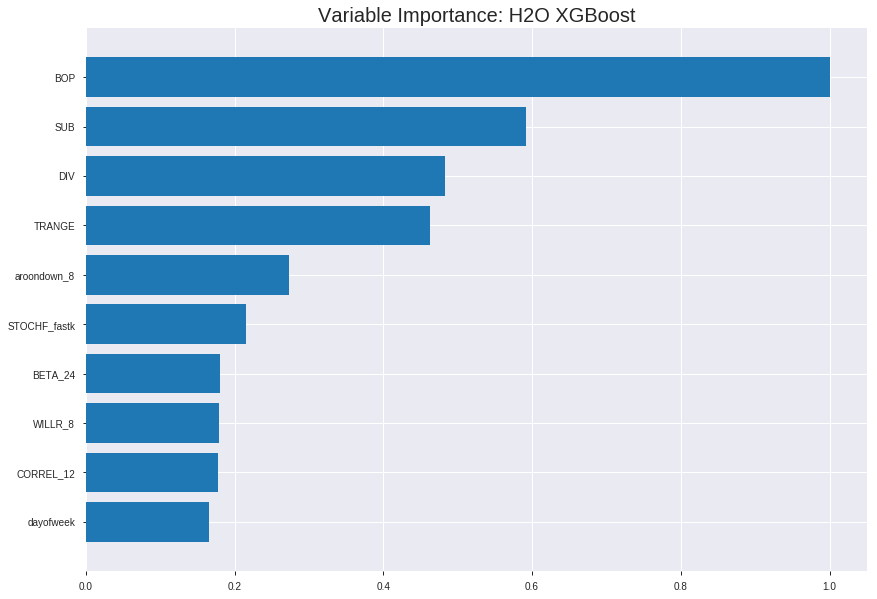

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_015546_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1973947456639574
RMSE: 0.44429128470402995
LogLoss: 0.5837018451679992
Mean Per-Class Error: 0.24757204276814704
AUC: 0.8309855977136841
pr_auc: 0.8101489282158979
Gini: 0.6619711954273682
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44769181311130524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      524  393   0.4286   (393.0/917.0)
1      87   783   0.1      (87.0/870.0)
Total  611  1176  0.2686   (480.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447692     0.765396  227
max f2                       0.391439     0.861151  277
max f0point5                 0.549376     0.750152  128
max accuracy                 0.508585     0.752658  170
max precision                0.748307     1         0
max recall                   0.279994     1         352
max specificity              0.748307     1         0
max absolute_mcc             0.508585     0.50492   170
max min_per_class_accuracy   0.504793     0.750575  173
max mean_per_class_accuracy  0.508585     0.752428  170

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.70773            2.05402    2.05402            1                0.721584  1                           0.721584            0.0206897       0.0206897                  105.402   105.402
    2        0.0201455                   0.691894           1.8258     1.93991            0.888889         0.700434  0.944444                    0.711009            0.0183908       0.0390805                  82.5798   93.9911
    3        0.0302182                   0.68177            2.05402    1.97795            1                0.687053  0.962963                    0.703024            0.0206897       0.0597701                  105.402   97.7948
    4        0.040291                    0.670881           1.8258     1.93991            0.888889         0.67614   0.944444                    0.696303            0.0183908       0.0781609                  82.5798   93.9911
    5        0.0503637                   0.663982           2.05402    1.96273            1                0.667017  0.955556                    0.690446            0.0206897       0.0988506                  105.402   96.2733
    6        0.100168                    0.634973           1.82323    1.89337            0.88764          0.647888  0.921788                    0.669286            0.0908046       0.189655                   82.3234   89.3373
    7        0.149972                    0.609508           1.66168    1.81643            0.808989         0.620553  0.884328                    0.653102            0.0827586       0.272414                   66.1682   81.6431
    8        0.200336                    0.592431           1.64322    1.77289            0.8              0.601028  0.863128                    0.640011            0.0827586       0.355172                   64.3218   77.2886
    9        0.299944                    0.560341           1.54629    1.69763            0.752809         0.575742  0.826493                    0.618668            0.154023        0.509195                   54.6287   69.7635
    10       0.400112                    0.530861           1.2852     1.59438            0.625698         0.54453   0.776224                    0.600108            0.128736        0.637931                   28.5199   59.4381
    11       0.50028                     0.502443           1.1934     1.5141             0.581006         0.517794  0.737136                    0.583626            0.11954         0.757471                   19.3399   51.4095
    12       0.599888                    0.468821           0.865459   1.40639            0.421348         0.485549  0.684701                    0.567341            0.0862069       0.843678                   -13.4541  40.6393
    13       0.700056                    0.431024           0.803249   1.32009            0.391061         0.450222  0.642686                    0.550583            0.0804598       0.924138                   -19.6751  32.0092
    14       0.799664                    0.383586           0.450039   1.21172            0.219101         0.408783  0.589923                    0.53292             0.0448276       0.968966                   -54.9961  21.1715
    15       0.899832                    0.316296           0.218025   1.1011             0.106145         0.356952  0.53607                     0.513332            0.0218391       0.990805                   -78.1975  10.1099
    16       1                           0.151789           0.0917999  1                  0.0446927        0.265263  0.486849                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23782558921852537
RMSE: 0.4876736503221446
LogLoss: 0.6679360193804013
Mean Per-Class Error: 0.3895756740196079
AUC: 0.6219286151960784
pr_auc: 0.5713442585861672
Gini: 0.2438572303921569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3641480505466461: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   208  0.8157   (208.0/255.0)
1      10   246  0.0391   (10.0/256.0)
Total  57   454  0.4266   (218.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364148     0.692958  347
max f2                       0.326807     0.846052  371
max f0point5                 0.483449     0.612745  220
max accuracy                 0.483449     0.610568  220
max precision                0.643397     0.615385  34
max recall                   0.30904      1         380
max specificity              0.718874     0.996078  0
max absolute_mcc             0.364148     0.230698  347
max min_per_class_accuracy   0.507436     0.588235  195
max mean_per_class_accuracy  0.483449     0.610424  220

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.68763            0.998047  0.998047           0.5              0.700123  0.5                         0.700123            0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.673372           0.798438  0.907315           0.4              0.680644  0.454545                    0.691269            0.0078125       0.0195312                  -20.1562   -9.26847
    3        0.0313112                   0.669337           1.19766   0.998047           0.6              0.671203  0.5                         0.684998            0.0117188       0.03125                    19.7656    -0.195312
    4        0.0410959                   0.664692           1.59688   1.14062            0.8              0.667522  0.571429                    0.680837            0.015625        0.046875                   59.6875    14.0625
    5        0.0508806                   0.659847           1.19766   1.15159            0.6              0.661148  0.576923                    0.677051            0.0117188       0.0585938                  19.7656    15.1593
    6        0.101761                    0.629397           0.998047  1.07482            0.5              0.643752  0.538462                    0.660401            0.0507812       0.109375                   -0.195312  7.48197
    7        0.150685                    0.609554           1.2775    1.14062            0.64             0.617931  0.571429                    0.646612            0.0625          0.171875                   27.75      14.0625
    8        0.201566                    0.588086           1.07482   1.12401            0.538462         0.598147  0.563107                    0.634378            0.0546875       0.226562                   7.48197    12.4014
    9        0.30137                     0.557632           1.33073   1.19247            0.666667         0.571883  0.597403                    0.613682            0.132812        0.359375                   33.0729    19.2472
    10       0.401174                    0.529419           1.25245   1.20739            0.627451         0.543062  0.604878                    0.596113            0.125           0.484375                   25.2451    20.7393
    11       0.500978                    0.507423           1.05676   1.17738            0.529412         0.517373  0.589844                    0.580427            0.105469        0.589844                   5.67555    17.7383
    12       0.600783                    0.476701           1.13503   1.17035            0.568627         0.490334  0.586319                    0.56546             0.113281        0.703125                   13.5034    17.0348
    13       0.700587                    0.443648           0.900199  1.13186            0.45098          0.458504  0.567039                    0.550223            0.0898438       0.792969                   -9.98009   13.1863
    14       0.800391                    0.404072           0.704504  1.07857            0.352941         0.425331  0.540342                    0.53465             0.0703125       0.863281                   -29.5496   7.85739
    15       0.900196                    0.355843           0.978477  1.06748            0.490196         0.379509  0.534783                    0.517449            0.0976562       0.960938                   -2.15227   6.74762
    16       1                           0.184945           0.391391  1                  0.196078         0.30844   0.500978               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:56:10  9.793 sec   0                  0.5              0.693147            0.5             0                  1                0.513151                         0.5                0.693147              0.5               0                    1                  0.499022
    2019-07-25 01:56:11  10.526 sec  5                  0.490822         0.674915            0.710335        0.674747           1.8258           0.365976                         0.497625           0.688404              0.585846          0.552207             0.748535           0.483366
    2019-07-25 01:56:11  10.824 sec  10                 0.484428         0.662284            0.730791        0.706641           1.83781          0.363179                         0.496              0.685144              0.586267          0.555545             1.33073            0.446184
    2019-07-25 01:56:12  11.151 sec  15                 0.477188         0.648062            0.757451        0.727233           1.93991          0.351987                         0.494179           0.681473              0.596385          0.550681             1.33073            0.452055
    2019-07-25 01:56:12  11.472 sec  20                 0.471443         0.636725            0.771875        0.740466           1.71169          0.315053                         0.492907           0.678883              0.600628          0.551354             0.998047           0.455969
    2019-07-25 01:56:12  11.784 sec  25                 0.465789         0.625675            0.787855        0.757173           1.8258           0.3061                           0.492062           0.677119              0.60491           0.561161             0.998047           0.459883
    2019-07-25 01:56:13  12.115 sec  30                 0.460325         0.614858            0.794003        0.76264            1.71169          0.29099                          0.490083           0.673011              0.613503          0.562352             0.998047           0.446184
    2019-07-25 01:56:13  12.448 sec  35                 0.455921         0.606241            0.803651        0.775319           1.8258           0.282597                         0.48908            0.670917              0.618459          0.565955             0.665365           0.438356
    2019-07-25 01:56:13  12.831 sec  40                 0.451918         0.598258            0.810046        0.786561           1.93991          0.287073                         0.487655           0.667896              0.623797          0.568353             0.665365           0.438356
    2019-07-25 01:56:14  13.160 sec  45                 0.448205         0.59112             0.820579        0.797871           1.93991          0.278679                         0.487906           0.668364              0.621193          0.565812             0.665365           0.432485
    2019-07-25 01:56:14  13.511 sec  50                 0.444291         0.583702            0.830986        0.810149           2.05402          0.268607                         0.487674           0.667936              0.621929          0.571344             0.998047           0.426614

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      419.6954345703125      1.0                   0.10233267132322615
SUB                      248.22828674316406     0.591448622731153     0.06052451751452186
DIV                      202.83770751953125     0.48329738856272786   0.04945711281516315
TRANGE                   194.15599060058594     0.462611633598932     0.04734028425138023
aroondown_8              114.43180847167969     0.27265440375551353   0.027901453484343162
---                      ---                    ---                   ---
BBANDS_lowerband_24_3_4  5.568120002746582      0.013267049255485153  0.0013576525908906144
aroonup_24               5.186990737915039      0.012358940104329514  0.0012647233555997906
MAX_24                   4.644510269165039      0.01106638263511283   0.0011324524969360584
STOCH_slowk              3.532545566558838      0.008416926360362929  0.0008613265587868176
BBANDS_upperband_14_3_5  2.2300586700439453     0.005313516627425545  0.0005437463506048354


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6484375)

('F1', 0.6813880126182965)

('auc', 0.6666053921568628)

('logloss', 0.6533548102710025)

('mean_per_class_error', 0.3463235294117647)

('rmse', 0.48030926507111565)

('mse', 0.23069699011315525)

xgboost prediction progress: |████████████████████████████████████████████| 100%


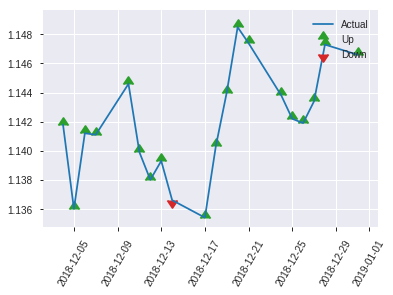


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23069699011315525
RMSE: 0.48030926507111565
LogLoss: 0.6533548102710025
Mean Per-Class Error: 0.3463235294117647
AUC: 0.6666053921568628
pr_auc: 0.5644296370999162
Gini: 0.3332107843137255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3949727416038513: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   89   0.6544   (89.0/136.0)
1      12   108  0.1      (12.0/120.0)
Total  59   197  0.3945   (101.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394973     0.681388  196
max f2                       0.309449     0.82296   242
max f0point5                 0.490334     0.625     123
max accuracy                 0.490334     0.648438  123
max precision                0.697596     1         0
max recall                   0.202678     1         254
max specificity              0.697596     1         0
max absolute_mcc             0.447221     0.318906  162
max min_per_class_accuracy   0.490334     0.641667  123
max mean_per_class_accuracy  0.447221     0.653676  162

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.680296           1.42222   1.42222            0.666667         0.690748  0.666667                    0.690748            0.0166667       0.0166667                  42.2222   42.2222
    2        0.0234375                   0.66094            0.711111  1.06667            0.333333         0.66835   0.5                         0.679549            0.00833333      0.025                      -28.8889  6.66667
    3        0.03125                     0.641233           0         0.8                0                0.652594  0.375                       0.67281             0               0.025                      -100      -20
    4        0.0429688                   0.632473           1.42222   0.969697           0.666667         0.635789  0.454545                    0.662713            0.0166667       0.0416667                  42.2222   -3.0303
    5        0.0507812                   0.624031           1.06667   0.984615           0.5              0.627258  0.461538                    0.657259            0.00833333      0.05                       6.66667   -1.53846
    6        0.101562                    0.597226           1.14872   1.06667            0.538462         0.610344  0.5                         0.633801            0.0583333       0.108333                   14.8718   6.66667
    7        0.152344                    0.580994           1.47692   1.20342            0.692308         0.58882   0.564103                    0.618808            0.075           0.183333                   47.6923   20.3419
    8        0.203125                    0.560813           1.47692   1.27179            0.692308         0.571333  0.596154                    0.606939            0.075           0.258333                   47.6923   27.1795
    9        0.300781                    0.533461           1.28      1.27446            0.6              0.546645  0.597403                    0.587363            0.125           0.383333                   28        27.4459
    10       0.402344                    0.507763           1.31282   1.28414            0.615385         0.51739   0.601942                    0.5697              0.133333        0.516667                   31.2821   28.4142
    11       0.5                         0.482527           1.28      1.28333            0.6              0.496903  0.601562                    0.555482            0.125           0.641667                   28        28.3333
    12       0.601562                    0.460958           1.14872   1.26061            0.538462         0.471752  0.590909                    0.541346            0.116667        0.758333                   14.8718   26.0606
    13       0.699219                    0.422451           0.768     1.19181            0.36             0.438888  0.558659                    0.527036            0.075           0.833333                   -23.2     19.1806
    14       0.800781                    0.383672           0.820513  1.14472            0.384615         0.402895  0.536585                    0.511291            0.0833333       0.916667                   -17.9487  14.4715
    15       0.898438                    0.348242           0.512     1.07594            0.24             0.365868  0.504348                    0.495484            0.05            0.966667                   -48.8     7.5942
    16       1                           0.170057           0.328205  1                  0.153846         0.290941  0.46875                     0.47471             0

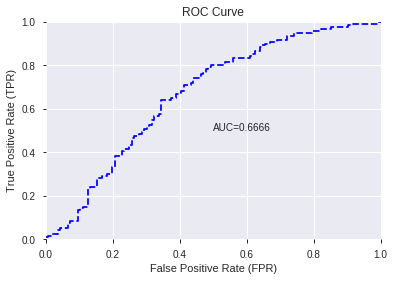

This function is available for GLM models only


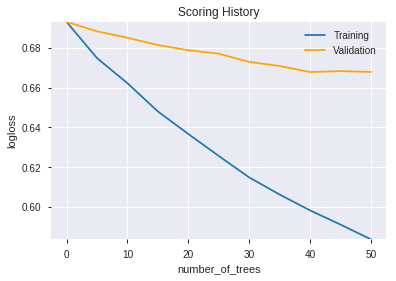

--2019-07-25 01:56:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_015546_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_015546_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_015641_model_3  0.564583  0.779207              0.467892  0.512611  0.262770
1  DeepLearning_grid_1_AutoML_20190725_015641_model_8  0.562010  0.697962              0.471569  0.502065  0.252069
2  DeepLearning_grid_1_AutoML_20190725_015641_model_6  0.561397  0.706073              0.483088  0.500776  0.250777
3  DeepLearning_grid_1_AutoML_20190725_015641_model_5  0.550306  0.697910              0.466667  0.501317  0.251319
4  DeepLearning_grid_1_AutoML_20190725_015641_model_9  0.545466  0.692006              0.469363  0.498575  0.248577
5  DeepLearning_grid_1_AutoML_20190725_015641_model_1  0.518199  1.074700              0.500000  0.563440  0.317464
6  DeepLearning_grid_1_AutoML_20190725_015641_model_2  0.511765  0.886845              0.489951  0.529530  0.280402
7               DeepLearning_1_AutoML_20190725_015641  0.510355  0.735793              0.469853  0.515540  0.265782
8  DeepLearning_grid_1_AutoML_20190725_015641_model_7  0.504412  0.784233              0.500000  0.532547  0.283607
9  DeepLearning_grid_1_AutoML_20190725_015641_model_4  0.485049  0.904375              0.486275  0.561288  0.315045

variable  relative_importance  scaled_importance  percentage
0      CDLADVANCEBLOCK             1.000000           1.000000    0.028358
1       CDL3LINESTRIKE             0.982085           0.982085    0.027850
2     CDLSTICKSANDWICH             0.961619           0.961619    0.027270
3         CDLTASUKIGAP             0.952304           0.952304    0.027006
4    CDLSTALLEDPATTERN             0.932563           0.932563    0.026446
5      CDLLADDERBOTTOM             0.922502           0.922502    0.026161
6    CDLDARKCLOUDCOVER             0.915255           0.915255    0.025955
7   CDLMORNINGDOJISTAR             0.909376           0.909376    0.025788
8      CDLHOMINGPIGEON             0.906305           0.906305    0.025701
9   CDLSEPARATINGLINES             0.905462           0.905462    0.025677
10       CDLHIKKAKEMOD             0.898028           0.898028    0.025467
11         CDL3OUTSIDE             0.854813           0.854813    0.024241
12         CDLMARUBOZU             0.846426           0.846426    0.024003
13      CDLMATCHINGLOW             0.833981           0.833981    0.023650
14      CDLHARAMICROSS             0.810692           0.810692    0.022990
15      CDLMORNINGSTAR             0.795062           0.795062    0.022547
16        CDLENGULFING             0.748744           0.748744    0.021233
17      CDLEVENINGSTAR             0.740374           0.740374    0.020996
18  CDLEVENINGDOJISTAR             0.736315           0.736315    0.020881
19             CDLDOJI             0.698730           0.698730    0.019815
20   CDLLONGLEGGEDDOJI             0.695281           0.695281    0.019717
21              TRANGE             0.676453           0.676453    0.019183
22             BETA_12             0.653075           0.653075    0.018520
23    is_quarter_start             0.652750           0.652750    0.018511
24      is_quarter_end             0.643776           0.643776    0.018256
25        HT_TRENDMODE             0.643131           0.643131    0.018238
26                 DIV             0.638816           0.638816    0.018116
27                week             0.636858           0.636858    0.018060
28      CDLRICKSHAWMAN             0.636008           0.636008    0.018036
29                 SUB             0.617157           0.617157    0.017502
30       days_in_month             0.614934           0.614934    0.017439
31              SAREXT             0.601590           0.601590    0.017060
32          MINUS_DM_8             0.600492           0.600492    0.017029
33           CORREL_24             0.598100           0.598100    0.016961
34      STOCHRSI_fastk             0.597627           0.597627    0.016948
35           dayofweek             0.593945           0.593945    0.016843
36           CDLHAMMER             0.589248           0.589248    0.016710
37          aroonup_24             0.582170           0.582170    0.016509
38      is_month_start             0.578578           0.578578    0.016408
39       CDLHANGINGMAN             0.576072           0.576072    0.016336
40              VAR_30             0.572214           0.572214    0.016227
41                 BOP             0.571505           0.571505    0.016207
42             weekday             0.560521           0.560521    0.015895
43                 day             0.557532           0.557532    0.015811
44    CDLDRAGONFLYDOJI             0.550188           0.550188    0.015602
45     CDLSHOOTINGSTAR             0.544988           0.544988    0.015455
46           CDLTAKURI             0.540623           0.540623    0.015331
47        is_month_end             0.532870           0.532870    0.015111
48   CDLINVERTEDHAMMER             0.529324           0.529324    0.015011
49      CDLSPINNINGTOP             0.526536           0.526536    0.014932

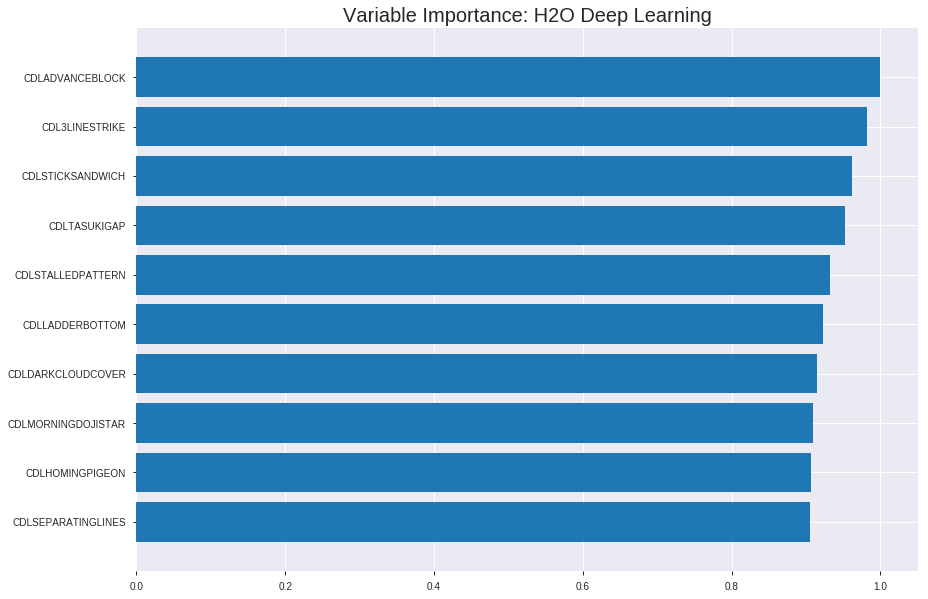

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_015641_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24167582160773085
RMSE: 0.49160535148402407
LogLoss: 0.7872822298734276
Mean Per-Class Error: 0.38109715589315485
AUC: 0.6661997518143873
pr_auc: 0.6219402498383882
Gini: 0.3323995036287746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20036613372603246: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      250  667   0.7274   (667.0/917.0)
1      84   786   0.0966   (84.0/870.0)
Total  334  1453  0.4203   (751.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.200366     0.676711  322
max f2                       0.000196277  0.825897  399
max f0point5                 0.511438     0.608956  172
max accuracy                 0.511438     0.622272  172
max precision                0.999771     0.888889  0
max recall                   0.000196277  1         399
max specificity              0.999771     0.997819  0
max absolute_mcc             0.332147     0.24655   262
max min_per_class_accuracy   0.427864     0.611778  215
max mean_per_class_accuracy  0.511438     0.618903  172

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 43.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.998441           1.8258    1.8258             0.888889         0.999771   0.888889                    0.999771            0.0183908       0.0183908                  82.5798    82.5798
    2        0.0201455                   0.980292           1.71169   1.76874            0.833333         0.991542   0.861111                    0.995657            0.0172414       0.0356322                  71.1686    76.8742
    3        0.0302182                   0.924604           1.59757   1.71169            0.777778         0.950601   0.833333                    0.980638            0.016092        0.0517241                  59.7573    71.1686
    4        0.040291                    0.886914           1.25524   1.59757            0.611111         0.905899   0.777778                    0.961953            0.0126437       0.0643678                  25.5236    59.7573
    5        0.0503637                   0.848103           1.59757   1.59757            0.777778         0.865966   0.777778                    0.942756            0.016092        0.0804598                  59.7573    59.7573
    6        0.100168                    0.758937           1.22318   1.41142            0.595506         0.795839   0.687151                    0.869708            0.0609195       0.141379                   22.3182    41.1424
    7        0.149972                    0.701134           1.40781   1.41022            0.685393         0.728482   0.686567                    0.822808            0.0701149       0.211494                   40.7814    41.0225
    8        0.200336                    0.650259           1.34653   1.39421            0.655556         0.679361   0.678771                    0.786746            0.0678161       0.27931                    34.6526    39.4211
    9        0.299944                    0.562278           1.35012   1.37957            0.657303         0.607247   0.671642                    0.727136            0.134483        0.413793                   35.0116    37.9568
    10       0.400112                    0.492383           0.986849  1.28125            0.480447         0.524794   0.623776                    0.67648             0.0988506       0.512644                   -1.3151    28.1251
    11       0.50028                     0.426275           1.0557    1.23609            0.513966         0.458354   0.60179                     0.632806            0.105747        0.618391                   5.5699     23.609
    12       0.599888                    0.360263           0.992393  1.19563            0.483146         0.393138   0.58209                     0.59301             0.0988506       0.717241                   -0.760687  19.5625
    13       0.700056                    0.285312           0.929474  1.15754            0.452514         0.324203   0.563549                    0.554548            0.0931034       0.810345                   -7.05259   15.7543
    14       0.799664                    0.208051           0.830841  1.11685            0.404494         0.247327   0.543737                    0.51628             0.0827586       0.893103                   -16.9159   11.6848
    15       0.899832                    0.103157           0.608174  1.06022            0.296089         0.16179    0.516169                    0.476818            0.0609195       0.954023                   -39.1826   6.02233
    16       1                           2.36824e-24        0.459     1                  0.223464         0.0358837  0.486849   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2674263285705639
RMSE: 0.5171327958760341
LogLoss: 0.8159209104189609
Mean Per-Class Error: 0.41259957107843137
AUC: 0.5792356004901961
pr_auc: 0.5511005324296969
Gini: 0.15847120098039214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0010233368088420924: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    252  0.9882   (252.0/255.0)
1      0    256  0        (0.0/256.0)
Total  3    508  0.4932   (252.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00102334   0.670157  397
max f2                       0.00102334   0.835509  397
max f0point5                 0.461574     0.582562  205
max accuracy                 0.562961     0.587084  144
max precision                0.995524     0.666667  1
max recall                   0.00102334   1         397
max specificity              1            0.996078  0
max absolute_mcc             0.562961     0.184694  144
max min_per_class_accuracy   0.465029     0.574219  202
max mean_per_class_accuracy  0.562961     0.5874    144

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 47.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.954845           0.998047  0.998047           0.5              0.98279   0.5                         0.98279             0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.869582           0.798438  0.907315           0.4              0.897298  0.454545                    0.94393             0.0078125       0.0195312                  -20.1562   -9.26847
    3        0.0313112                   0.850636           1.19766   0.998047           0.6              0.858659  0.5                         0.917283            0.0117188       0.03125                    19.7656    -0.195312
    4        0.0410959                   0.836416           0.798438  0.950521           0.4              0.841798  0.47619                     0.89931             0.0078125       0.0390625                  -20.1562   -4.94792
    5        0.0508806                   0.819704           0.798438  0.921274           0.4              0.829078  0.461538                    0.885804            0.0078125       0.046875                   -20.1562   -7.8726
    6        0.101761                    0.756842           1.15159   1.03643            0.576923         0.783153  0.519231                    0.834479            0.0585938       0.105469                   15.1593    3.64333
    7        0.150685                    0.712053           1.19766   1.08878            0.6              0.733829  0.545455                    0.8018              0.0585938       0.164062                   19.7656    8.87784
    8        0.201566                    0.665457           1.30514   1.14339            0.653846         0.687371  0.572816                    0.772915            0.0664062       0.230469                   30.5138    14.3394
    9        0.30137                     0.592643           1.48729   1.25728            0.745098         0.627557  0.62987                     0.724777            0.148438        0.378906                   48.7286    25.728
    10       0.401174                    0.519403           1.09589   1.21713            0.54902          0.554621  0.609756                    0.682445            0.109375        0.488281                   9.58946    21.713
    11       0.500978                    0.46383            0.900199  1.15399            0.45098          0.490182  0.578125                    0.644143            0.0898438       0.578125                   -9.98009   15.3992
    12       0.600783                    0.417236           0.665365  1.07282            0.333333         0.438177  0.537459                    0.609927            0.0664062       0.644531                   -33.4635   7.28191
    13       0.700587                    0.375902           0.86106   1.04265            0.431373         0.396905  0.522346                    0.57958             0.0859375       0.730469                   -13.894    4.26523
    14       0.800391                    0.308331           1.01762   1.03953            0.509804         0.343368  0.520782                    0.550126            0.101562        0.832031                   1.76164    3.95305
    15       0.900196                    0.23462            0.939338  1.02842            0.470588         0.267599  0.515217                    0.518802            0.09375         0.925781                   -6.06618   2.84222
    16       1                           1.03437e-06        0.743643  1                  0.372549         0.118997  0.500978                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:57:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:57:54  1 min 12.054 sec  6292 obs/sec      10        1             17870      0.491605         0.787282            0.0326275      0.6662          0.62194            1.8258           0.420257                         0.517133           0.815921              -0.0697094       0.579236          0.551101             0.998047           0.493151
    2019-07-25 01:58:00  1 min 18.442 sec  7817 obs/sec      40        4             71480      0.467428         0.693709            0.12544        0.714491        0.684191           1.93991          0.378847                         0.510734           0.849401              -0.0434019       0.589254          0.561308             1.33073            0.499022
    2019-07-25 01:58:06  1 min 23.742 sec  8709 obs/sec      70        7             125090     0.463569         0.70362             0.13982        0.729759        0.707433           1.71169          0.344712                         0.507127           0.828488              -0.028716        0.598667          0.576838             1.33073            0.499022
    2019-07-25 01:58:12  1 min 30.104 sec  9524 obs/sec      110       11            196570     0.449259         0.645428            0.192106       0.760402        0.729419           2.05402          0.302182                         0.512485           0.865491              -0.0505662       0.58557           0.561229             1.33073            0.426614
    2019-07-25 01:58:18  1 min 36.113 sec  10090 obs/sec     150       15            268050     0.44712          0.666897            0.199781       0.770515        0.748269           1.93991          0.309457                         0.51377            0.908218              -0.0558419       0.575146          0.56299              1.33073            0.499022
    2019-07-25 01:58:24  1 min 41.874 sec  10530 obs/sec     190       19            339530     0.435379         0.619943            0.241257       0.792921        0.763409           1.93991          0.274762                         0.514559           0.913374              -0.0590888       0.58259           0.560881             0.998047           0.432485
    2019-07-25 01:58:24  1 min 41.961 sec  10528 obs/sec     190       19            339530     0.491605         0.787282            0.0326275      0.6662          0.62194            1.8258           0.420257                         0.517133           0.815921              -0.0697094       0.579236          0.551101             0.998047           0.493151

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLADVANCEBLOCK    1.0                    1.0                  0.02835833697818716
CDL3LINESTRIKE     0.9820845723152161     0.9820845723152161   0.027850285242793715
CDLSTICKSANDWICH   0.9616191387176514     0.9616191387176514   0.02726991958042926
CDLTASUKIGAP       0.9523043036460876     0.9523043036460876   0.027005766348573622
CDLSTALLEDPATTERN  0.9325634241104126     0.9325634241104126   0.026445947834455148
---                ---                    ---                  ---
CDLSHOOTINGSTAR    0.5449883341789246     0.5449883341789246   0.015454962829826818
CDLTAKURI          0.5406226515769958     0.5406226515769958   0.015331159331461515
is_month_end       0.5328704118728638     0.5328704118728638   0.015111318705596056
CDLINVERTEDHAMMER  0.5293236970901489     0.5293236970901489   0.01501073977262231
CDLSPINNINGTOP     0.52653568983078       0.52653568983078     0.014931676523263495


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.61328125)

('F1', 0.650137741046832)

('auc', 0.5645833333333333)

('logloss', 0.7792070974461753)

('mean_per_class_error', 0.39632352941176474)

('rmse', 0.5126105623104796)

('mse', 0.26276958859226607)

deeplearning prediction progress: |███████████████████████████████████████| 100%


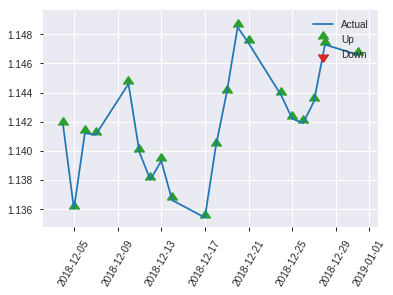


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26276958859226607
RMSE: 0.5126105623104796
LogLoss: 0.7792070974461753
Mean Per-Class Error: 0.39632352941176474
AUC: 0.5645833333333333
pr_auc: 0.5254573159545816
Gini: 0.12916666666666665
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22791007424509377: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   125  0.9191   (125.0/136.0)
1      2    118  0.0167   (2.0/120.0)
Total  13   243  0.4961   (127.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.22791      0.650138  242
max f2                       1.70475e-05  0.816327  254
max f0point5                 0.583003     0.576923  86
max accuracy                 0.59903      0.613281  80
max precision                0.887843     0.666667  5
max recall                   1.70475e-05  1         254
max specificity              0.992883     0.992647  0
max absolute_mcc             0.59903      0.219333  80
max min_per_class_accuracy   0.498315     0.516667  124
max mean_per_class_accuracy  0.583003     0.603676  86

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.934508           0.711111  0.711111           0.333333         0.981099  0.333333                    0.981099            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.887056           2.13333   1.42222            1                0.895031  0.666667                    0.938065            0.025           0.0333333                  113.333   42.2222
    3        0.03125                     0.869535           1.06667   1.33333            0.5              0.875485  0.625                       0.92242             0.00833333      0.0416667                  6.66667   33.3333
    4        0.0429688                   0.812829           0.711111  1.16364            0.333333         0.841307  0.545455                    0.900298            0.00833333      0.05                       -28.8889  16.3636
    5        0.0507812                   0.79826            2.13333   1.31282            1                0.809859  0.615385                    0.886385            0.0166667       0.0666667                  113.333   31.2821
    6        0.101562                    0.744938           0.984615  1.14872            0.461538         0.770118  0.538462                    0.828251            0.05            0.116667                   -1.53846  14.8718
    7        0.152344                    0.718015           1.31282   1.20342            0.615385         0.733294  0.564103                    0.796599            0.0666667       0.183333                   31.2821   20.3419
    8        0.203125                    0.666943           1.47692   1.27179            0.692308         0.691808  0.596154                    0.770401            0.075           0.258333                   47.6923   27.1795
    9        0.300781                    0.609267           1.36533   1.30216            0.64             0.639609  0.61039                     0.727936            0.133333        0.391667                   36.5333   30.2165
    10       0.402344                    0.536469           0.820513  1.18058            0.384615         0.571381  0.553398                    0.688417            0.0833333       0.475                      -17.9487  18.0583
    11       0.5                         0.491254           0.426667  1.03333            0.2              0.513142  0.484375                    0.654184            0.0416667       0.516667                   -57.3333  3.33333
    12       0.601562                    0.442052           0.984615  1.02511            0.461538         0.460673  0.480519                    0.621513            0.1             0.616667                   -1.53846  2.51082
    13       0.699219                    0.404934           1.024     1.02495            0.48             0.422889  0.480447                    0.593772            0.1             0.716667                   2.4       2.49534
    14       0.800781                    0.34214            0.984615  1.01984            0.461538         0.377315  0.478049                    0.566319            0.1             0.816667                   -1.53846  1.98374
    15       0.898438                    0.270669           1.024     1.02029            0.48             0.30852   0.478261                    0.538298            0.1             0.916667                   2.4       2.02899
    16       1                           4.72544e-07        0.820513  1                  0.384615         0.190271  0.46875                     0.502951        

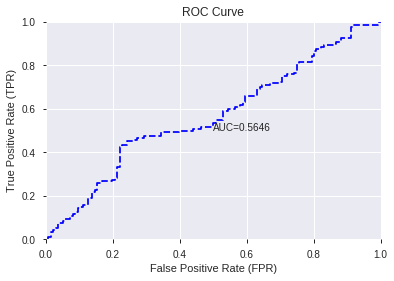

This function is available for GLM models only


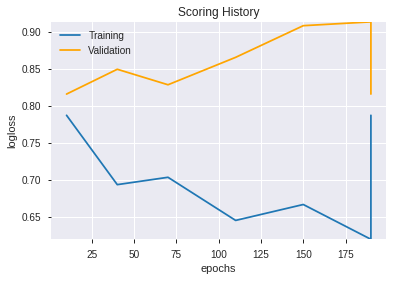

--2019-07-25 02:04:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_015641_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_015641_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'CDLSTICKSANDWICH',
 'CDLTASUKIGAP',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'CDLSEPARATINGLINES',
 'CDLHIKKAKEMOD',
 'CDL3OUTSIDE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLHARAMICROSS',
 'CDLMORNINGSTAR',
 'CDLENGULFING',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'BETA_12',
 'is_quarter_start',
 'is_quarter_end',
 'HT_TRENDMODE',
 'DIV',
 'week',
 'CDLRICKSHAWMAN',
 'SUB',
 'days_in_month',
 'SAREXT',
 'MINUS_DM_8',
 'CORREL_24',
 'STOCHRSI_fastk',
 'dayofweek',
 'CDLHAMMER',
 'aroonup_24',
 'is_month_start',
 'CDLHANGINGMAN',
 'VAR_30',
 'BOP',
 'weekday',
 'day',
 'CDLDRAGONFLYDOJI',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'is_month_end',
 'CDLINVERTEDHAMMER',
 'CDLSPINNINGTOP']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_020502_model_1  0.513787  0.694501                   0.5  0.500646  0.250646

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.110034           1.000000    0.102452
1       CDLRICKSHAWMAN             0.060004           0.545324    0.055870
2            dayofweek             0.048272           0.438703    0.044946
3              weekday             0.048251           0.438511    0.044926
4     CDLDRAGONFLYDOJI             0.047336           0.430197    0.044074
5            CDLTAKURI             0.045887           0.417030    0.042726
6     is_quarter_start             0.044517           0.404575    0.041449
7          CDLMARUBOZU             0.038778           0.352423    0.036106
8       CDLSPINNINGTOP             0.032542           0.295748    0.030300
9    CDLINVERTEDHAMMER             0.032450           0.294910    0.030214
10    CDLSTICKSANDWICH             0.031566           0.286872    0.029391
11  CDLMORNINGDOJISTAR             0.029253           0.265852    0.027237
12      is_quarter_end             0.027436           0.249342    0.025546
13        CDLENGULFING             0.026513           0.240950    0.024686
14  CDLSEPARATINGLINES             0.025996           0.236255    0.024205
15              SAREXT             0.025316           0.230072    0.023571
16     CDLADVANCEBLOCK             0.024751           0.224944    0.023046
17              TRANGE             0.023342           0.212136    0.021734
18       days_in_month             0.020445           0.185806    0.019036
19       CDLHANGINGMAN             0.020255           0.184083    0.018860
20             BETA_12             0.019373           0.176068    0.018039
21        CDLTASUKIGAP             0.019294           0.175347    0.017965
22          aroonup_24             0.019280           0.175222    0.017952
23         CDL3OUTSIDE             0.018972           0.172423    0.017665
24      CDLEVENINGSTAR             0.018254           0.165895    0.016996
25              VAR_30             0.018237           0.165736    0.016980
26                week             0.017776           0.161549    0.016551
27     CDLHOMINGPIGEON             0.017579           0.159756    0.016367
28   CDLDARKCLOUDCOVER             0.016864           0.153263    0.015702
29   CDLSTALLEDPATTERN             0.015813           0.143711    0.014723
30                 SUB             0.014659           0.133227    0.013649
31      CDLMATCHINGLOW             0.011496           0.104476    0.010704
32       CDLHIKKAKEMOD             0.011301           0.102704    0.010522
33      STOCHRSI_fastk             0.010381           0.094342    0.009666
34      CDL3LINESTRIKE             0.009588           0.087141    0.008928
35      CDLHARAMICROSS             0.008718           0.079229    0.008117
36        HT_TRENDMODE             0.008276           0.075211    0.007706
37                 DIV             0.008030           0.072974    0.007476
38                 day             0.007603           0.069093    0.007079
39           CDLHAMMER             0.006834           0.062107    0.006363
40     CDLSHOOTINGSTAR             0.006517           0.059224    0.006068
41             CDLDOJI             0.006066           0.055133    0.005648
42          MINUS_DM_8             0.005769           0.052433    0.005372
43  CDLEVENINGDOJISTAR             0.003270           0.029717    0.003045
44   CDLLONGLEGGEDDOJI             0.002785           0.025312    0.002593
45        is_month_end             0.002752           0.025008    0.002562
46           CORREL_24             0.002182           0.019828    0.002031
47      CDLMORNINGSTAR             0.002053           0.018655    0.001911
48      is_month_start             0.001161           0.010554    0.001081
49     CDLLADDERBOTTOM             0.000176           0.001598    0.000164

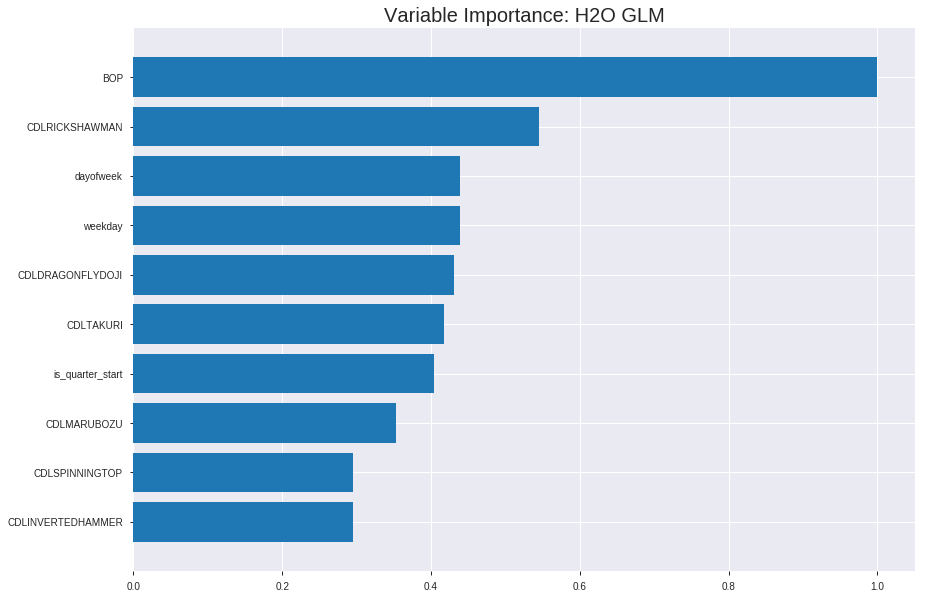

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_020502_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23753549042034466
RMSE: 0.487376128283223
LogLoss: 0.6676893322855147
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2476.0717307928226
Residual deviance: 2386.3216735884303
AIC: 2488.3216735884303
AUC: 0.642894120006518
pr_auc: 0.6077548001127607
Gini: 0.28578824001303604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4256402896365256: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      189  728   0.7939   (728.0/917.0)
1      46   824   0.0529   (46.0/870.0)
Total  235  1552  0.4331   (774.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42564      0.680429  305
max f2                       0.397662     0.830571  336
max f0point5                 0.460259     0.601712  251
max accuracy                 0.460834     0.603805  250
max precision                0.932682     1         0
max recall                   0.214074     1         399
max specificity              0.932682     1         0
max absolute_mcc             0.448819     0.245327  273
max min_per_class_accuracy   0.49226      0.595402  191
max mean_per_class_accuracy  0.460259     0.609452  251

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.639841           1.8258    1.8258             0.888889         0.692599  0.888889                    0.692599            0.0183908       0.0183908                  82.5798   82.5798
    2        0.0201455                   0.589895           1.48346   1.65463            0.722222         0.612662  0.805556                    0.652631            0.0149425       0.0333333                  48.3461   65.463
    3        0.0302182                   0.577102           1.59757   1.63561            0.777778         0.58344   0.796296                    0.629567            0.016092        0.0494253                  59.7573   63.5611
    4        0.040291                    0.569523           1.02701   1.48346            0.5              0.572823  0.722222                    0.615381            0.0103448       0.0597701                  2.70115   48.3461
    5        0.0503637                   0.562791           1.36935   1.46064            0.666667         0.565426  0.711111                    0.60539             0.0137931       0.0735632                  36.9349   46.0639
    6        0.100168                    0.54945            1.24626   1.35405            0.606742         0.555999  0.659218                    0.580832            0.062069        0.135632                   24.6261   35.4049
    7        0.149972                    0.54               1.17702   1.29526            0.573034         0.544782  0.630597                    0.568861            0.0586207       0.194253                   17.7024   29.5261
    8        0.200336                    0.531839           1.3237    1.30241            0.644444         0.535762  0.634078                    0.56054             0.0666667       0.26092                    32.3704   30.2411
    9        0.299944                    0.519573           1.14241   1.24928            0.55618          0.525575  0.608209                    0.548928            0.113793        0.374713                   14.2406   24.9275
    10       0.400112                    0.505571           1.13602   1.22092            0.553073         0.512273  0.594406                    0.539752            0.113793        0.488506                   13.6024   22.0923
    11       0.50028                     0.491811           1.1016    1.19703            0.536313         0.498544  0.582774                    0.531501            0.110345        0.598851                   10.1599   19.7031
    12       0.599888                    0.478358           1.01547   1.16688            0.494382         0.485816  0.568097                    0.523915            0.101149        0.7                        1.5472    16.6884
    13       0.700056                    0.461659           1.09012   1.1559             0.530726         0.470432  0.56275                     0.516263            0.109195        0.809195                   9.01239   15.5901
    14       0.799664                    0.443239           0.888538  1.1226             0.432584         0.452793  0.546536                    0.508357            0.0885057       0.897701                   -11.1462  12.2598
    15       0.899832                    0.407502           0.677024  1.073              0.329609         0.428914  0.522388                    0.499513            0.0678161       0.965517                   -32.2976  7.29971
    16       1                           0.214074           0.34425   1                  0.167598         0.373088  0.486849                    0.486849          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24752083121853743
RMSE: 0.4975146542751655
LogLoss: 0.688187685358487
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.8026372780396
Residual deviance: 703.3278144363736
AIC: 805.3278144363736
AUC: 0.5647365196078431
pr_auc: 0.5444453536729202
Gini: 0.1294730392156862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3732796227906688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    246  0.9647   (246.0/255.0)
1      4    252  0.0156   (4.0/256.0)
Total  13   498  0.4892   (250.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37328      0.668435  387
max f2                       0.327925     0.833876  399
max f0point5                 0.47339      0.580467  256
max accuracy                 0.474721     0.567515  252
max precision                0.725736     1         0
max recall                   0.327925     1         399
max specificity              0.725736     1         0
max absolute_mcc             0.47339      0.143007  256
max min_per_class_accuracy   0.492628     0.542969  195
max mean_per_class_accuracy  0.474721     0.56721   252

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.582204           0.998047  0.998047           0.5              0.631041  0.5                         0.631041            0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.567244           0.798438  0.907315           0.4              0.574507  0.454545                    0.605344            0.0078125       0.0195312                  -20.1562   -9.26847
    3        0.0313112                   0.562001           1.59688   1.1228             0.8              0.563614  0.5625                      0.592303            0.015625        0.0351562                  59.6875    12.2803
    4        0.0410959                   0.560342           1.19766   1.14062            0.6              0.560938  0.571429                    0.584835            0.0117188       0.046875                   19.7656    14.0625
    5        0.0508806                   0.557348           0.798438  1.07482            0.4              0.559669  0.538462                    0.579996            0.0078125       0.0546875                  -20.1562   7.48197
    6        0.101761                    0.5466             1.45868   1.26675            0.730769         0.551193  0.634615                    0.565594            0.0742188       0.128906                   45.8684    26.6752
    7        0.150685                    0.53891            0.798438  1.1147             0.4              0.542564  0.558442                    0.558117            0.0390625       0.167969                   -20.1562   11.4702
    8        0.201566                    0.533118           1.15159   1.12401            0.576923         0.535668  0.563107                    0.55245             0.0585938       0.226562                   15.1593    12.4014
    9        0.30137                     0.51441            1.13503   1.12766            0.568627         0.523225  0.564935                    0.542772            0.113281        0.339844                   13.5034    12.7663
    10       0.401174                    0.503316           1.09589   1.11976            0.54902          0.508724  0.560976                    0.534301            0.109375        0.449219                   9.58946    11.976
    11       0.500978                    0.491958           0.939338  1.08382            0.470588         0.497457  0.542969                    0.526961            0.09375         0.542969                   -6.06618   8.38165
    12       0.600783                    0.480773           1.09589   1.08582            0.54902          0.486426  0.543974                    0.520227            0.109375        0.652344                   9.58946    8.5823
    13       0.700587                    0.467588           1.05676   1.08168            0.529412         0.474978  0.541899                    0.513781            0.105469        0.757812                   5.67555    8.16821
    14       0.800391                    0.452562           0.782782  1.04441            0.392157         0.461261  0.523227                    0.507232            0.078125        0.835938                   -21.7218   4.44109
    15       0.900196                    0.426456           0.782782  1.0154             0.392157         0.441416  0.508696                    0.499935            0.078125        0.914062                   -21.7218   1.54042
    16       1                           0.327925           0.86106   1                  0.431373         0.39009   0.500978                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 02:05:03  0.000 sec   2            7.6       51            1.379             1.38461
    2019-07-25 02:05:03  0.015 sec   4            4.7       51            1.37549           1.38339
    2019-07-25 02:05:03  0.028 sec   6            2.9       51            1.3705            1.38178
    2019-07-25 02:05:03  0.042 sec   8            1.8       51            1.36379           1.37987
    2019-07-25 02:05:03  0.055 sec   10           1.1       51            1.35538           1.37797
    2019-07-25 02:05:03  0.068 sec   12           0.7       51            1.34567           1.3766
    2019-07-25 02:05:03  0.082 sec   14           0.43      51            1.33538           1.37638
    2019-07-25 02:05:03  0.095 sec   16           0.27      51            1.32531           1.37781
    2019-07-25 02:05:03  0.108 sec   18           0.17      51            1.31616           1.38115
    2019-07-25 02:05:03  0.121 sec   20           0.1       51            1.3084            1.38635
    2019-07-25 02:05:03  0.134 sec   22           0.065     51            1.30217           1.39311
    2019-07-25 02:05:03  0.147 sec   24           0.04      51            1.2973            1.40091

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.546875)

('F1', 0.6382978723404256)

('auc', 0.5137867647058824)

('logloss', 0.6945012104039979)

('mean_per_class_error', 0.45833333333333337)

('rmse', 0.500645592369203)

('mse', 0.25064600915871016)

glm prediction progress: |████████████████████████████████████████████████| 100%


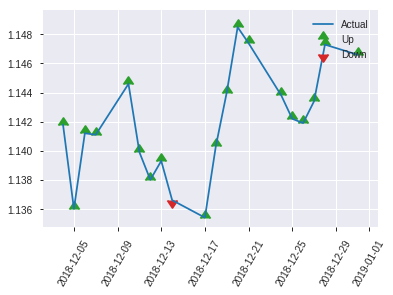


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25064600915871016
RMSE: 0.500645592369203
LogLoss: 0.6945012104039979
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.2266765121979
Residual deviance: 355.58461972684694
AIC: 457.58461972684694
AUC: 0.5137867647058824
pr_auc: 0.45877413702230746
Gini: 0.02757352941176472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3381275886774832: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    136  1        (136.0/136.0)
1      0    120  0        (0.0/120.0)
Total  0    256  0.5312   (136.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338128     0.638298  255
max f2                       0.338128     0.815217  255
max f0point5                 0.455822     0.534979  212
max accuracy                 0.508222     0.546875  103
max precision                0.508222     0.519231  103
max recall                   0.338128     1         255
max specificity              0.62321      0.992647  0
max absolute_mcc             0.565805     0.109497  6
max min_per_class_accuracy   0.501037     0.508333  125
max mean_per_class_accuracy  0.507865     0.541667  105

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.570958           0         0                  0                0.58941   0                           0.58941             0               0                          -100      -100
    2        0.0234375                   0.566969           0.711111  0.355556           0.333333         0.568191  0.166667                    0.5788              0.00833333      0.00833333                 -28.8889  -64.4444
    3        0.03125                     0.563058           1.06667   0.533333           0.5              0.565562  0.25                        0.575491            0.00833333      0.0166667                  6.66667   -46.6667
    4        0.0429688                   0.560108           2.13333   0.969697           1                0.561243  0.454545                    0.571605            0.025           0.0416667                  113.333   -3.0303
    5        0.0507812                   0.553902           1.06667   0.984615           0.5              0.557275  0.461538                    0.5694              0.00833333      0.05                       6.66667   -1.53846
    6        0.101562                    0.540871           0.65641   0.820513           0.307692         0.547318  0.384615                    0.558359            0.0333333       0.0833333                  -34.359   -17.9487
    7        0.152344                    0.53489            1.14872   0.929915           0.538462         0.538412  0.435897                    0.55171             0.0583333       0.141667                   14.8718   -7.00855
    8        0.203125                    0.530215           0.65641   0.861538           0.307692         0.532865  0.403846                    0.546999            0.0333333       0.175                      -34.359   -13.8462
    9        0.300781                    0.516264           1.19467   0.969697           0.56             0.522696  0.454545                    0.539108            0.116667        0.291667                   19.4667   -3.0303
    10       0.402344                    0.508228           1.47692   1.09773            0.692308         0.512004  0.514563                    0.532266            0.15            0.441667                   47.6923   9.77346
    11       0.5                         0.498949           0.682667  1.01667            0.32             0.503984  0.476562                    0.526742            0.0666667       0.508333                   -31.7333  1.66667
    12       0.601562                    0.489187           0.984615  1.01126            0.461538         0.493351  0.474026                    0.521105            0.1             0.608333                   -1.53846  1.12554
    13       0.699219                    0.474084           1.10933   1.02495            0.52             0.481677  0.480447                    0.515598            0.108333        0.716667                   10.9333   2.49534
    14       0.800781                    0.461955           1.14872   1.04065            0.538462         0.468704  0.487805                    0.509651            0.116667        0.833333                   14.8718   4.06504
    15       0.898438                    0.432212           0.853333  1.02029            0.4              0.448189  0.478261                    0.50297             0.0833333       0.916667                   -14.6667  2.02899
    16       1                           0.338128           0.820513  1                  0.384615         0.403105  0.46875                     0.492828      

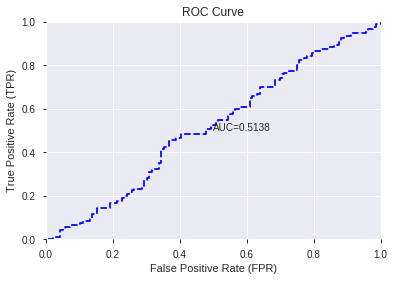

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


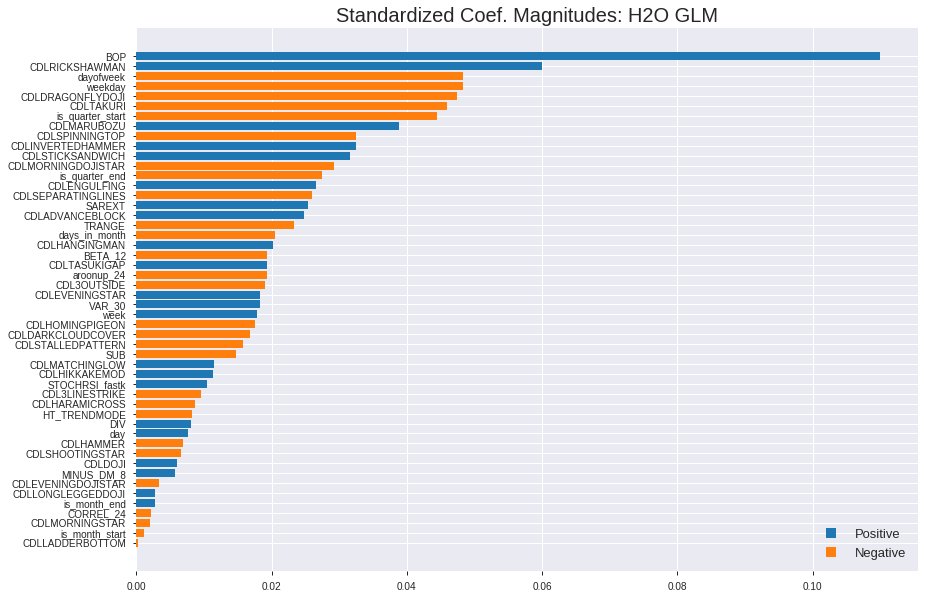

'log_likelihood'
--2019-07-25 02:05:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_020502_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_020502_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_quarter_start',
 'CDLMARUBOZU',
 'CDLSPINNINGTOP',
 'CDLINVERTEDHAMMER',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'is_quarter_end',
 'CDLENGULFING',
 'CDLSEPARATINGLINES',
 'SAREXT',
 'CDLADVANCEBLOCK',
 'TRANGE',
 'days_in_month',
 'CDLHANGINGMAN',
 'BETA_12',
 'CDLTASUKIGAP',
 'aroonup_24',
 'CDL3OUTSIDE',
 'CDLEVENINGSTAR',
 'VAR_30',
 'week',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'CDL3LINESTRIKE',
 'CDLHARAMICROSS',
 'HT_TRENDMODE',
 'DIV',
 'day',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLDOJI',
 'MINUS_DM_8',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'is_month_start',
 'CDLLADDERBOTTOM']

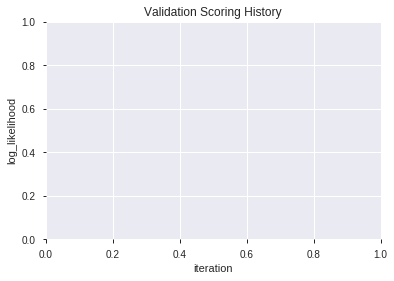

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_020517_model_5  0.638480  0.665005              0.401961  0.486205  0.236396
1               XGBoost_3_AutoML_20190725_020517  0.624326  0.669114              0.436275  0.488028  0.238171
2  XGBoost_grid_1_AutoML_20190725_020517_model_3  0.623775  0.671275              0.407598  0.489066  0.239185
3  XGBoost_grid_1_AutoML_20190725_020517_model_2  0.623713  0.670005              0.457353  0.488538  0.238670
4  XGBoost_grid_1_AutoML_20190725_020517_model_1  0.618199  0.674084              0.413480  0.490455  0.240547
5  XGBoost_grid_1_AutoML_20190725_020517_model_4  0.616850  0.673273              0.399755  0.490133  0.240231
6               XGBoost_2_AutoML_20190725_020517  0.611152  0.678661              0.387500  0.492477  0.242534
7  XGBoost_grid_1_AutoML_20190725_020517_model_6  0.599939  0.677619              0.485294  0.492269  0.242328
8               XGBoost_1_AutoML_20190725_020517  0.593444  0.685439              0.404902  0.495874  0.245891
9  XGBoost_grid_1_AutoML_20190725_020517_model_7  0.593321  0.680097              0.427941  0.493676  0.243716

variable  relative_importance  scaled_importance  percentage
0                  BOP          2325.722412           1.000000    0.094562
1               SAREXT          2172.297607           0.934031    0.088324
2            CORREL_24          1961.895752           0.843564    0.079769
3               TRANGE          1893.610352           0.814203    0.076993
4           MINUS_DM_8          1880.887573           0.808733    0.076475
5                  day          1826.986206           0.785556    0.074284
6                  DIV          1825.569946           0.784947    0.074226
7               VAR_30          1663.242798           0.715151    0.067626
8                 week          1636.876099           0.703814    0.066554
9              BETA_12          1284.345459           0.552235    0.052220
10          aroonup_24          1135.248413           0.488127    0.046158
11                 SUB          1094.847900           0.470756    0.044516
12      STOCHRSI_fastk          1021.880798           0.439382    0.041549
13           dayofweek           786.949036           0.338368    0.031997
14             weekday           339.295074           0.145888    0.013795
15       days_in_month           273.186890           0.117463    0.011108
16      CDLSPINNINGTOP           254.336060           0.109358    0.010341
17      CDLRICKSHAWMAN           199.709427           0.085870    0.008120
18        HT_TRENDMODE           179.085800           0.077002    0.007281
19    CDLDRAGONFLYDOJI           130.111588           0.055945    0.005290
20           CDLTAKURI            86.934891           0.037380    0.003535
21        is_month_end            78.864639           0.033910    0.003207
22     CDLSHOOTINGSTAR            67.023018           0.028818    0.002725
23   CDLINVERTEDHAMMER            61.683289           0.026522    0.002508
24       CDLHANGINGMAN            56.605217           0.024339    0.002302
25             CDLDOJI            50.350151           0.021649    0.002047
26    is_quarter_start            39.463085           0.016968    0.001605
27      is_quarter_end            38.758274           0.016665    0.001576
28      is_month_start            33.421898           0.014371    0.001359
29   CDLLONGLEGGEDDOJI            31.526264           0.013555    0.001282
30           CDLHAMMER            30.407473           0.013074    0.001236
31         CDL3OUTSIDE            24.052794           0.010342    0.000978
32        CDLENGULFING            20.441177           0.008789    0.000831
33         CDLMARUBOZU            16.566668           0.007123    0.000674
34      CDLMATCHINGLOW            13.798520           0.005933    0.000561
35     CDLADVANCEBLOCK            12.140246           0.005220    0.000494
36  CDLEVENINGDOJISTAR            10.840153           0.004661    0.000441
37  CDLSEPARATINGLINES            10.582182           0.004550    0.000430
38      CDLHARAMICROSS             6.268926           0.002695    0.000255
39      CDLEVENINGSTAR             3.872048           0.001665    0.000157
40  CDLMORNINGDOJISTAR             3.832623           0.001648    0.000156
41      CDLMORNINGSTAR             2.995962           0.001288    0.000122
42    CDLSTICKSANDWICH             2.335491           0.001004    0.000095
43       CDLHIKKAKEMOD             2.334439           0.001004    0.000095
44      CDL3LINESTRIKE             1.824176           0.000784    0.000074
45     CDLLADDERBOTTOM             1.678004           0.000721    0.000068

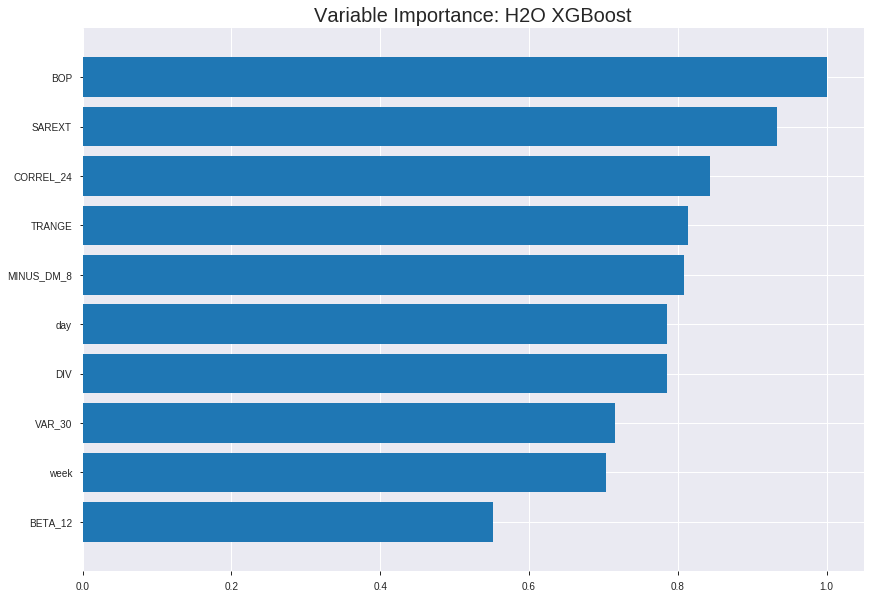

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_020517_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04543791603859915
RMSE: 0.21316171335068396
LogLoss: 0.22886371675652648
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988505747126437
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49776655435562134: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      917  0    0        (0.0/917.0)
1      0    870  0        (0.0/870.0)
Total  917  870  0        (0.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.497767     1        193
max f2                       0.497767     1        193
max f0point5                 0.497767     1        193
max accuracy                 0.497767     1        193
max precision                0.922888     1        0
max recall                   0.497767     1        193
max specificity              0.922888     1        0
max absolute_mcc             0.497767     1        193
max min_per_class_accuracy   0.497767     1        193
max mean_per_class_accuracy  0.497767     1        193

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.79 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100727                   0.898059           2.05402  2.05402            1                0.909197   1                           0.909197            0.0206897       0.0206897                  105.402  105.402
    2        0.0201455                   0.88656            2.05402  2.05402            1                0.891095   1                           0.900146            0.0206897       0.0413793                  105.402  105.402
    3        0.0302182                   0.877978           2.05402  2.05402            1                0.881879   1                           0.894057            0.0206897       0.062069                   105.402  105.402
    4        0.040291                    0.872771           2.05402  2.05402            1                0.875111   1                           0.88932             0.0206897       0.0827586                  105.402  105.402
    5        0.0503637                   0.868333           2.05402  2.05402            1                0.870342   1                           0.885525            0.0206897       0.103448                   105.402  105.402
    6        0.100168                    0.849645           2.05402  2.05402            1                0.858329   1                           0.872003            0.102299        0.205747                   105.402  105.402
    7        0.149972                    0.834804           2.05402  2.05402            1                0.842085   1                           0.862067            0.102299        0.308046                   105.402  105.402
    8        0.200336                    0.817307           2.05402  2.05402            1                0.825691   1                           0.852923            0.103448        0.411494                   105.402  105.402
    9        0.299944                    0.781829           2.05402  2.05402            1                0.801401   1                           0.835813            0.204598        0.616092                   105.402  105.402
    10       0.400112                    0.736619           2.05402  2.05402            1                0.762245   1                           0.817395            0.205747        0.821839                   105.402  105.402
    11       0.50028                     0.35161            1.77862  1.99888            0.865922         0.647239   0.973154                    0.783326            0.178161        1                          77.8623  99.8881
    12       0.599888                    0.252827           0        1.66698            0                0.290642   0.811567                    0.701518            0               1                          -100     66.6978
    13       0.700056                    0.207696           0        1.42846            0                0.228396   0.695444                    0.633821            0               1                          -100     42.8457
    14       0.799664                    0.173621           0        1.25052            0                0.190453   0.608817                    0.578594            0               1                          -100     25.0525
    15       0.899832                    0.12873            0        1.11132            0                0.152731   0.541045                    0.531188            0               1                          -100     11.1318
    16       1                           0.053072           0        1                  0                0.0991285  0.486849                    0.487909            0             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2500791726353568
RMSE: 0.500079166368043
LogLoss: 0.6949541756254042
Mean Per-Class Error: 0.430453431372549
AUC: 0.5825444240196078
pr_auc: 0.5660038182498459
Gini: 0.16508884803921564
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34745609760284424: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   204  0.8      (204.0/255.0)
1      21   235  0.082    (21.0/256.0)
Total  72   439  0.4403   (225.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347456     0.676259  334
max f2                       0.205032     0.836066  389
max f0point5                 0.347456     0.583996  334
max accuracy                 0.523856     0.569472  192
max precision                0.889581     1         0
max recall                   0.145607     1         396
max specificity              0.889581     1         0
max absolute_mcc             0.347456     0.169535  334
max min_per_class_accuracy   0.514471     0.552941  203
max mean_per_class_accuracy  0.523856     0.569547  192

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.832178           1.33073   1.33073            0.666667         0.855038  0.666667                    0.855038            0.015625        0.015625                   33.0729   33.0729
    2        0.0215264                   0.806387           1.19766   1.27024            0.6              0.814762  0.636364                    0.836731            0.0117188       0.0273438                  19.7656   27.0241
    3        0.0313112                   0.799098           1.59688   1.37231            0.8              0.803456  0.6875                      0.826333            0.015625        0.0429688                  59.6875   37.2314
    4        0.0410959                   0.775891           1.99609   1.52083            1                0.786038  0.761905                    0.816739            0.0195312       0.0625                     99.6094   52.0833
    5        0.0508806                   0.760421           0.798438  1.38191            0.4              0.768137  0.692308                    0.807392            0.0078125       0.0703125                  -20.1562  38.1911
    6        0.101761                    0.709687           0.844501  1.11321            0.423077         0.729513  0.557692                    0.768452            0.0429688       0.113281                   -15.5499  11.3206
    7        0.150685                    0.675465           1.19766   1.14062            0.6              0.69225   0.571429                    0.743711            0.0585938       0.171875                   19.7656   14.0625
    8        0.201566                    0.650392           1.30514   1.18215            0.653846         0.660342  0.592233                    0.722667            0.0664062       0.238281                   30.5138   18.2153
    9        0.30137                     0.597233           1.17417   1.17951            0.588235         0.622575  0.590909                    0.68952             0.117188        0.355469                   17.4173   17.951
    10       0.401174                    0.555668           0.978477  1.1295             0.490196         0.575945  0.565854                    0.661264            0.0976562       0.453125                   -2.15227  12.9497
    11       0.500978                    0.514493           1.05676   1.11501            0.529412         0.53243   0.558594                    0.635598            0.105469        0.558594                   5.67555   11.5005
    12       0.600783                    0.476589           0.900199  1.07932            0.45098          0.496429  0.540717                    0.612479            0.0898438       0.648438                   -9.98009  7.93211
    13       0.700587                    0.437062           1.01762   1.07053            0.509804         0.454861  0.536313                    0.590025            0.101562        0.75                       1.76164   7.05307
    14       0.800391                    0.382796           1.05676   1.06881            0.529412         0.409092  0.535452                    0.567464            0.105469        0.855469                   5.67555   6.8813
    15       0.900196                    0.319311           0.900199  1.05012            0.45098          0.349678  0.526087                    0.543318            0.0898438       0.945312                   -9.98009  5.01189
    16       1                           0.114726           0.547947  1                  0.27451          0.253302  0.500978                    0.514373           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:05:23  2.645 sec   0                  0.5              0.693147            0.5             0                  1                0.513151                         0.5                0.693147              0.5               0                    1                  0.499022
    2019-07-25 02:05:23  2.961 sec   5                  0.448112         0.593943            0.966838        0.963111           2.05402          0.0867375                        0.499831           0.692841              0.532177          0.517795             1.33073            0.479452
    2019-07-25 02:05:23  3.207 sec   10                 0.40576          0.518811            0.993194        0.992154           2.05402          0.0391718                        0.496064           0.685265              0.573912          0.561426             1.33073            0.489237
    2019-07-25 02:05:23  3.441 sec   15                 0.369664         0.458385            0.998471        0.996204           2.05402          0.0162283                        0.494264           0.681584              0.586972          0.571389             1.66341            0.46184
    2019-07-25 02:05:24  3.677 sec   20                 0.338374         0.408427            0.999495        0.997189           2.05402          0.0100727                        0.495495           0.684194              0.581824          0.560865             1.33073            0.483366
    2019-07-25 02:05:24  3.929 sec   25                 0.310101         0.36501             0.99991         0.998757           2.05402          0.00447678                       0.495771           0.684635              0.581886          0.57194              1.99609            0.485323
    2019-07-25 02:05:24  4.201 sec   30                 0.28481          0.327592            0.999974        0.998824           2.05402          0.00279799                       0.494605           0.682244              0.589851          0.5751               1.99609            0.481409
    2019-07-25 02:05:24  4.464 sec   35                 0.263048         0.29654             0.999999        0.9977             2.05402          0.000559597                      0.495647           0.684663              0.590786          0.573068             1.66341            0.469667
    2019-07-25 02:05:25  4.736 sec   40                 0.245835         0.272403            0.999999        0.99885            2.05402          0.000559597                      0.496283           0.686391              0.592295          0.571815             1.33073            0.454012
    2019-07-25 02:05:25  5.037 sec   45                 0.228759         0.249259            0.999999        0.99885            2.05402          0.000559597                      0.498012           0.690196              0.587048          0.568254             1.66341            0.455969
    2019-07-25 02:05:25  5.349 sec   50                 0.213162         0.228864            1               0.998851           2.05402          0                                0.500079           0.694954              0.582544          0.566004             1.33073            0.440313

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               2325.722412109375      1.0                    0.09456198532916812
SAREXT            2172.297607421875      0.9340313341400244     0.08832385731593231
CORREL_24         1961.895751953125      0.8435640219735993     0.07976908867008155
TRANGE            1893.6103515625        0.8142030801711372     0.07699265972210657
MINUS_DM_8        1880.8875732421875     0.8087326172069981     0.07647536188354791
---               ---                    ---                    ---
CDLMORNINGSTAR    2.995962381362915      0.0012881857120023402  0.00012181339839960929
CDLSTICKSANDWICH  2.335491418838501      0.0010042004181918967  9.495918521260663e-05
CDLHIKKAKEMOD     2.334439277648926      0.0010037480249122442  9.491640600593313e-05
CDL3LINESTRIKE    1.82417631149292       0.0007843482532545384  7.41695280172143e-05
CDLLADDERBOTTOM   1.6780035495758057     0.0007214977767075377  6.82262621760456e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.61328125)

('F1', 0.6707317073170732)

('auc', 0.6384803921568627)

('logloss', 0.6650048876855239)

('mean_per_class_error', 0.37745098039215685)

('rmse', 0.4862052934889507)

('mse', 0.23639558741667668)

xgboost prediction progress: |████████████████████████████████████████████| 100%


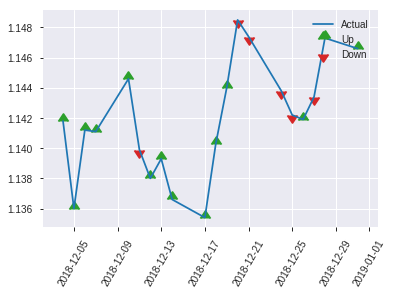


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23639558741667668
RMSE: 0.4862052934889507
LogLoss: 0.6650048876855239
Mean Per-Class Error: 0.37745098039215685
AUC: 0.6384803921568627
pr_auc: 0.5609469100065387
Gini: 0.2769607843137254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3374643623828888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   98   0.7206   (98.0/136.0)
1      10   110  0.0833   (10.0/120.0)
Total  48   208  0.4219   (108.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337464     0.670732  207
max f2                       0.245413     0.826446  245
max f0point5                 0.396549     0.595238  179
max accuracy                 0.476159     0.613281  142
max precision                0.815117     1         0
max recall                   0.245413     1         245
max specificity              0.815117     1         0
max absolute_mcc             0.396549     0.267705  179
max min_per_class_accuracy   0.497274     0.588235  126
max mean_per_class_accuracy  0.396549     0.622549  179

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.802142           0.711111  0.711111           0.333333         0.807892  0.333333                    0.807892            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.790458           0.711111  0.711111           0.333333         0.795367  0.333333                    0.801629            0.00833333      0.0166667                  -28.8889  -28.8889
    3        0.03125                     0.783008           2.13333   1.06667            1                0.785352  0.5                         0.79756             0.0166667       0.0333333                  113.333   6.66667
    4        0.0429688                   0.763686           1.42222   1.16364            0.666667         0.773438  0.545455                    0.790981            0.0166667       0.05                       42.2222   16.3636
    5        0.0507812                   0.751121           2.13333   1.31282            1                0.751615  0.615385                    0.784925            0.0166667       0.0666667                  113.333   31.2821
    6        0.101562                    0.705554           1.47692   1.39487            0.692308         0.725462  0.653846                    0.755193            0.075           0.141667                   47.6923   39.4872
    7        0.152344                    0.668879           1.14872   1.31282            0.538462         0.68512   0.615385                    0.731836            0.0583333       0.2                        14.8718   31.2821
    8        0.203125                    0.641834           1.31282   1.31282            0.615385         0.651856  0.615385                    0.711841            0.0666667       0.266667                   31.2821   31.2821
    9        0.300781                    0.607159           1.10933   1.24675            0.52             0.626839  0.584416                    0.684243            0.108333        0.375                      10.9333   24.6753
    10       0.402344                    0.540958           0.902564  1.15987            0.423077         0.576113  0.543689                    0.656948            0.0916667       0.466667                   -9.74359  15.9871
    11       0.5                         0.496498           1.36533   1.2                0.64             0.517286  0.5625                      0.62967             0.133333        0.6                        36.5333   20
    12       0.601562                    0.459129           1.06667   1.17749            0.5              0.478469  0.551948                    0.604143            0.108333        0.708333                   6.66667   17.7489
    13       0.699219                    0.397351           1.19467   1.17989            0.56             0.434114  0.553073                    0.580395            0.116667        0.825                      19.4667   17.9888
    14       0.800781                    0.34204            0.65641   1.1135             0.307692         0.373084  0.521951                    0.554102            0.0666667       0.891667                   -34.359   11.3496
    15       0.898438                    0.288901           0.597333  1.05739            0.28             0.318389  0.495652                    0.528481            0.0583333       0.95                       -40.2667  5.73913
    16       1                           0.154016           0.492308  1                  0.230769         0.240829  0.46875                     0.499267            

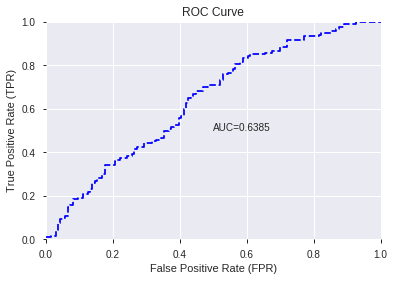

This function is available for GLM models only


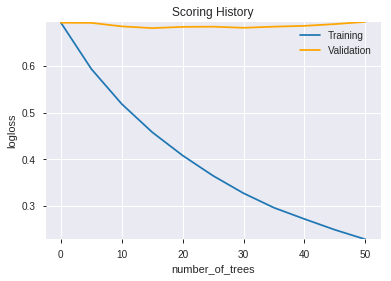

--2019-07-25 02:05:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_020517_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_020517_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SAREXT',
 'CORREL_24',
 'TRANGE',
 'MINUS_DM_8',
 'day',
 'DIV',
 'VAR_30',
 'week',
 'BETA_12',
 'aroonup_24',
 'SUB',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday',
 'days_in_month',
 'CDLSPINNINGTOP',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_end',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDOJI',
 'is_quarter_start',
 'is_quarter_end',
 'is_month_start',
 'CDLLONGLEGGEDDOJI',
 'CDLHAMMER',
 'CDL3OUTSIDE',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [914] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


5

['BOP', 'CDLBELTHOLD', 'CDLDRAGONFLYDOJI', 'CDLRICKSHAWMAN', 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_020540_model_6  0.558119  0.686126              0.478431  0.496543  0.246555
1  DeepLearning_grid_1_AutoML_20190725_020540_model_3  0.539491  0.717490              0.477206  0.511288  0.261416
2  DeepLearning_grid_1_AutoML_20190725_020540_model_5  0.536091  0.691263              0.474755  0.499185  0.249185
3  DeepLearning_grid_1_AutoML_20190725_020540_model_2  0.530239  0.691447              0.474755  0.499324  0.249325
4               DeepLearning_1_AutoML_20190725_020540  0.528646  0.696212              0.474265  0.501264  0.251266
5  DeepLearning_grid_1_AutoML_20190725_020540_model_7  0.526348  0.693191              0.474755  0.500110  0.250110
6  DeepLearning_grid_1_AutoML_20190725_020540_model_1  0.514737  0.700231              0.474755  0.503288  0.253299
7  DeepLearning_grid_1_AutoML_20190725_020540_model_4  0.511305  0.729448              0.496324  0.516746  0.267027

variable  relative_importance  scaled_importance  percentage
0               BOP             1.000000           1.000000    0.333902
1    CDLRICKSHAWMAN             0.818965           0.818965    0.273454
2       CDLBELTHOLD             0.434116           0.434116    0.144952
3  CDLDRAGONFLYDOJI             0.376595           0.376595    0.125746
4         CDLTAKURI             0.365211           0.365211    0.121945

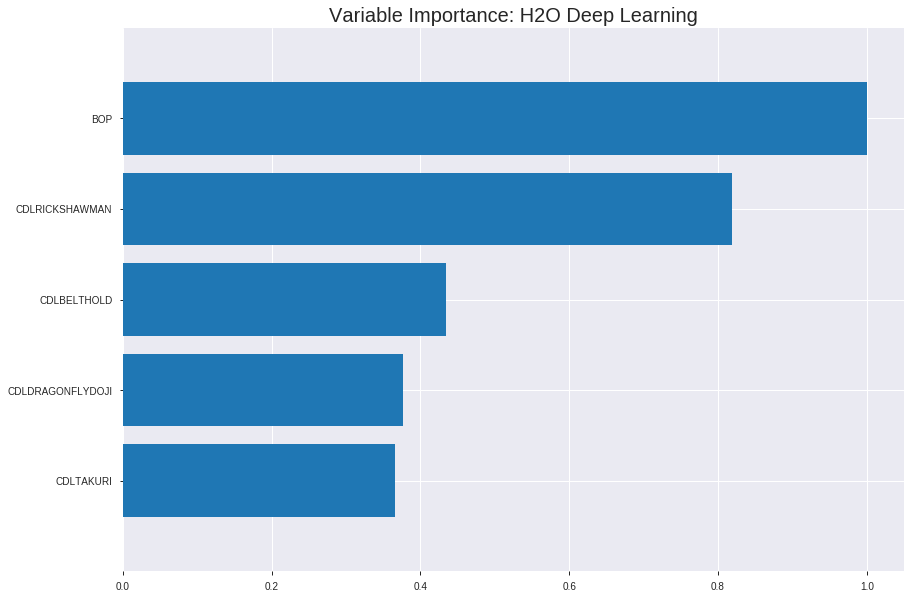

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_020540_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23825146081381973
RMSE: 0.48811009087481455
LogLoss: 0.6684197630073844
Mean Per-Class Error: 0.4164661126361573
AUC: 0.6113369433058825
pr_auc: 0.580858530972225
Gini: 0.22267388661176502
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3089380593620201: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      212  705   0.7688   (705.0/917.0)
1      79   791   0.0908   (79.0/870.0)
Total  291  1496  0.4387   (784.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308938     0.668639  308
max f2                       0.229912     0.830301  371
max f0point5                 0.352656     0.57812   289
max accuracy                 0.507268     0.584779  173
max precision                0.930763     1         0
max recall                   0.146072     1         398
max specificity              0.930763     1         0
max absolute_mcc             0.308938     0.190042  308
max min_per_class_accuracy   0.484256     0.575791  202
max mean_per_class_accuracy  0.486029     0.583534  195

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 47.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.66287            1.48346   1.48346            0.722222         0.683685  0.722222                    0.683685            0.0149425       0.0149425                  48.3461    48.3461
    2        0.0201455                   0.64064            1.25524   1.36935            0.611111         0.654892  0.666667                    0.669288            0.0126437       0.0275862                  25.5236    36.9349
    3        0.0302182                   0.609318           1.36935   1.36935            0.666667         0.619877  0.666667                    0.652818            0.0137931       0.0413793                  36.9349    36.9349
    4        0.040291                    0.595469           1.36935   1.36935            0.666667         0.600953  0.666667                    0.639852            0.0137931       0.0551724                  36.9349    36.9349
    5        0.0503637                   0.586866           1.25524   1.34653            0.611111         0.591259  0.655556                    0.630133            0.0126437       0.0678161                  25.5236    34.6526
    6        0.100168                    0.538276           1.36166   1.35405            0.662921         0.570625  0.659218                    0.600545            0.0678161       0.135632                   36.1656    35.4049
    7        0.149972                    0.528511           1.22318   1.31059            0.595506         0.530681  0.63806                     0.577344            0.0609195       0.196552                   22.3182    31.0589
    8        0.200336                    0.527579           1.04983   1.24504            0.511111         0.527877  0.606145                    0.564908            0.0528736       0.249425                   4.9834     24.5036
    9        0.327924                    0.527177           1.13512   1.20227            0.552632         0.527246  0.585324                    0.550255            0.144828        0.394253                   13.5118    20.2269
    10       0.400672                    0.526295           1.09021   1.18192            0.530769         0.526699  0.575419                    0.545978            0.0793103       0.473563                   9.02122    18.1924
    11       0.50028                     0.484008           1.06163   1.15797            0.516854         0.503002  0.563758                    0.537421            0.105747        0.57931                    6.16299    15.7973
    12       0.668719                    0.48166            0.934888  1.10178            0.45515          0.481985  0.536402                    0.523458            0.157471        0.736782                   -6.51125   10.1781
    13       0.700056                    0.479748           0.990333  1.09679            0.482143         0.480312  0.533973                    0.521526            0.0310345       0.767816                   -0.966749  9.67925
    14       0.799664                    0.456959           1.01547   1.08666            0.494382         0.476771  0.529041                    0.515952            0.101149        0.868966                   1.5472     8.6663
    15       0.899832                    0.307609           0.757349  1.05               0.368715         0.333677  0.511194                    0.495661            0.0758621       0.944828                   -24.2651   5.00043
    16       1                           0.145441           0.550799  1                  0.268156         0.25292   0.486849                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2465060269561139
RMSE: 0.49649373304817646
LogLoss: 0.6860789437670515
Mean Per-Class Error: 0.43061427696078436
AUC: 0.5584788602941176
pr_auc: 0.554334748309375
Gini: 0.11695772058823528
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30750753437847816: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   236  0.9255   (236.0/255.0)
1      6    250  0.0234   (6.0/256.0)
Total  25   486  0.4736   (242.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307508     0.673854  289
max f2                       0.275912     0.83442   311
max f0point5                 0.483354     0.575843  196
max accuracy                 0.484059     0.569472  183
max precision                0.585725     1         0
max recall                   0.275912     1         311
max specificity              0.585725     1         0
max absolute_mcc             0.483354     0.140101  196
max min_per_class_accuracy   0.485164     0.552941  168
max mean_per_class_accuracy  0.484059     0.569386  183

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.577619           1.33073   1.33073            0.666667         0.581566  0.666667                    0.581566            0.015625        0.015625                   33.0729   33.0729
    2        0.0215264                   0.539928           1.59688   1.4517             0.8              0.563003  0.727273                    0.573129            0.015625        0.03125                    59.6875   45.1705
    3        0.0313112                   0.532162           1.59688   1.49707            0.8              0.534322  0.75                        0.561001            0.015625        0.046875                   59.6875   49.707
    4        0.0410959                   0.531256           1.19766   1.42578            0.6              0.531786  0.714286                    0.554045            0.0117188       0.0585938                  19.7656   42.5781
    5        0.0508806                   0.530315           1.19766   1.38191            0.6              0.530798  0.692308                    0.549575            0.0117188       0.0703125                  19.7656   38.1911
    6        0.101761                    0.528327           1.07482   1.22837            0.538462         0.529272  0.615385                    0.539424            0.0546875       0.125                      7.48197   22.8365
    7        0.152642                    0.527555           0.921274  1.126              0.461538         0.527729  0.564103                    0.535525            0.046875        0.171875                   -7.8726   12.6002
    8        0.277886                    0.527177           0.90448   1.02616            0.453125         0.527246  0.514085                    0.531794            0.113281        0.285156                   -9.552    2.61609
    9        0.303327                    0.526798           0.921274  1.01736            0.461538         0.526859  0.509677                    0.53138             0.0234375       0.308594                   -7.8726   1.73639
    10       0.401174                    0.525457           1.31742   1.09055            0.66             0.526299  0.546341                    0.530141            0.128906        0.4375                     31.7422   9.05488
    11       0.500978                    0.485164           1.17417   1.10721            0.588235         0.492543  0.554688                    0.522651            0.117188        0.554688                   17.4173   10.7208
    12       0.735812                    0.48166            0.93151   1.05113            0.466667         0.482565  0.526596                    0.509857            0.21875         0.773438                   -6.84896  5.11345
    13       0.800391                    0.479121           0.725852  1.02489            0.363636         0.479886  0.513447                    0.507439            0.046875        0.820312                   -27.4148  2.48892
    14       0.900196                    0.308533           1.17417   1.04144            0.588235         0.450297  0.521739                    0.501104            0.117188        0.9375                     17.4173   4.14402
    15       1                           0.273441           0.626225  1                  0.313725         0.302236  0.500978                    0.481256            0.0625          1                          -37.3775  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:08:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 02:08:56  1 min 51.648 sec  1209 obs/sec      1.37661   1             2460       0.499614         0.694409            0.000851372    0.609237        0.575751           1.36935          0.451035                         0.502888           0.699232              -0.0115878       0.553546          0.552409             1.33073            0.48728
    2019-07-25 02:09:02  1 min 57.654 sec  3650 obs/sec      15.2384   11            27231      0.495441         0.683301            0.0174749      0.605458        0.573271           1.36935          0.454952                         0.503938           0.701454              -0.0158178       0.552566          0.55507              1.99609            0.48728
    2019-07-25 02:09:08  2 min  3.903 sec  4316 obs/sec      31.7331   23            56707      0.49205          0.676556            0.0308774      0.603576        0.567887           1.36935          0.451595                         0.499076           0.691224              0.00368787       0.56862           0.563553             0.998047           0.48728
    2019-07-25 02:09:14  2 min 10.013 sec  4628 obs/sec      48.3688   35            86435      0.48811          0.66842             0.0463345      0.611337        0.580859           1.48346          0.438724                         0.496494           0.686079              0.0139721        0.558479          0.554335             1.33073            0.473581
    2019-07-25 02:09:20  2 min 16.109 sec  4798 obs/sec      64.967    47            116096     0.488486         0.669239            0.044865       0.610556        0.582748           1.71169          0.440403                         0.496643           0.68634               0.0133801        0.557698          0.555572             1.66341            0.473581
    2019-07-25 02:09:26  2 min 22.087 sec  4928 obs/sec      81.5417   59            145715     0.489425         0.671291            0.0411905      0.611551        0.584695           1.71169          0.443201                         0.497158           0.687379              0.0113336        0.553699          0.552781             1.33073            0.475538
    2019-07-25 02:09:27  2 min 22.676 sec  4925 obs/sec      81.5417   59            145715     0.48811          0.66842             0.0463345      0.611337        0.580859           1.48346          0.438724                         0.496494           0.686079              0.0139721        0.558479          0.554335             1.33073            0.473581

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
BOP               1                      1                    0.333902
CDLRICKSHAWMAN    0.818965               0.818965             0.273454
CDLBELTHOLD       0.434116               0.434116             0.144952
CDLDRAGONFLYDOJI  0.376595               0.376595             0.125746
CDLTAKURI         0.365211               0.365211             0.121945

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5703125)

('F1', 0.6467391304347826)

('auc', 0.5581188725490196)

('logloss', 0.6861263849125419)

('mean_per_class_error', 0.4504901960784313)

('rmse', 0.49654280125391637)

('mse', 0.2465547534770863)

deeplearning prediction progress: |███████████████████████████████████████| 100%


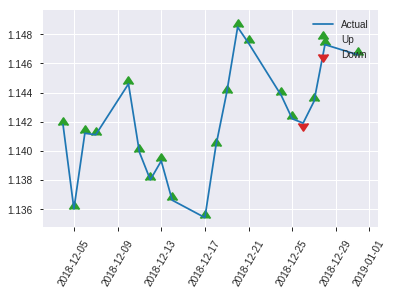


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2465547534770863
RMSE: 0.49654280125391637
LogLoss: 0.6861263849125419
Mean Per-Class Error: 0.4504901960784313
AUC: 0.5581188725490196
pr_auc: 0.5388777518751554
Gini: 0.11623774509803919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30641285508709776: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    129  0.9485   (129.0/136.0)
1      1    119  0.0083   (1.0/120.0)
Total  8    248  0.5078   (130.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306413     0.646739  149
max f2                       0.306413     0.817308  149
max f0point5                 0.478245     0.537849  126
max accuracy                 0.527561     0.570312  37
max precision                0.589811     1         0
max recall                   0.276336     1         156
max specificity              0.589811     1         0
max absolute_mcc             0.577018     0.146215  7
max min_per_class_accuracy   0.48778      0.536765  80
max mean_per_class_accuracy  0.527561     0.54951   37

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.580122           2.13333   2.13333            1                0.585201  1                           0.585201            0.025           0.025                      113.333    113.333
    2        0.0234375                   0.577915           1.42222   1.77778            0.666667         0.578178  0.833333                    0.581689            0.0166667       0.0416667                  42.2222    77.7778
    3        0.03125                     0.555896           2.13333   1.86667            1                0.57726   0.875                       0.580582            0.0166667       0.0583333                  113.333    86.6667
    4        0.0429688                   0.53105            0.711111  1.55152            0.333333         0.536839  0.727273                    0.568652            0.00833333      0.0666667                  -28.8889   55.1515
    5        0.0507812                   0.530624           1.06667   1.47692            0.5              0.531011  0.692308                    0.562861            0.00833333      0.075                      6.66667    47.6923
    6        0.101562                    0.528342           1.14872   1.31282            0.538462         0.529732  0.615385                    0.546296            0.0583333       0.133333                   14.8718    31.2821
    7        0.152344                    0.527593           1.31282   1.31282            0.615385         0.527857  0.615385                    0.54015             0.0666667       0.2                        31.2821    31.2821
    8        0.34375                     0.527177           0.914286  1.09091            0.428571         0.527252  0.511364                    0.532968            0.175           0.375                      -8.57143   9.09091
    9        0.402344                    0.526616           0.995556  1.07702            0.466667         0.526775  0.504854                    0.532066            0.0583333       0.433333                   -0.444444  7.70227
    10       0.5                         0.487639           1.10933   1.08333            0.52             0.521729  0.507812                    0.530047            0.108333        0.541667                   10.9333    8.33333
    11       0.601562                    0.482983           0.820513  1.03896            0.384615         0.484489  0.487013                    0.522356            0.0833333       0.625                      -17.9487   3.8961
    12       0.769531                    0.48166            1.09147   1.05042            0.511628         0.481686  0.492386                    0.513479            0.183333        0.808333                   9.14729    5.0423
    13       0.804688                    0.479774           0.711111  1.0356             0.333333         0.480077  0.485437                    0.512019            0.025           0.833333                   -28.8889   3.55987
    14       0.898438                    0.464427           0.977778  1.02957            0.458333         0.477469  0.482609                    0.508414            0.0916667       0.925                      -2.22222   2.95652
    15       1                           0.275912           0.738462  1                  0.346154         0.304423  0.46875                     0.487696            0.075           1                          -26.1538   0

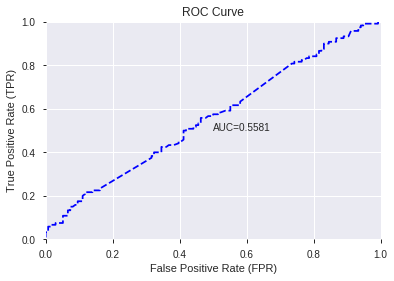

This function is available for GLM models only


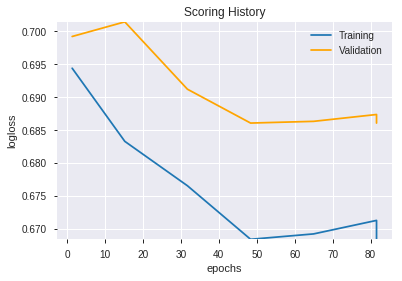

['BOP', 'CDLRICKSHAWMAN', 'CDLBELTHOLD', 'CDLDRAGONFLYDOJI', 'CDLTAKURI']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_021041_model_1  0.551256  0.687049              0.474755  0.497043  0.247052

variable  relative_importance  scaled_importance  percentage
0               BOP             0.228584           1.000000    0.419540
1    CDLRICKSHAWMAN             0.115908           0.507071    0.212737
2  CDLDRAGONFLYDOJI             0.071207           0.311512    0.130692
3         CDLTAKURI             0.069378           0.303510    0.127335
4       CDLBELTHOLD             0.059767           0.261467    0.109696

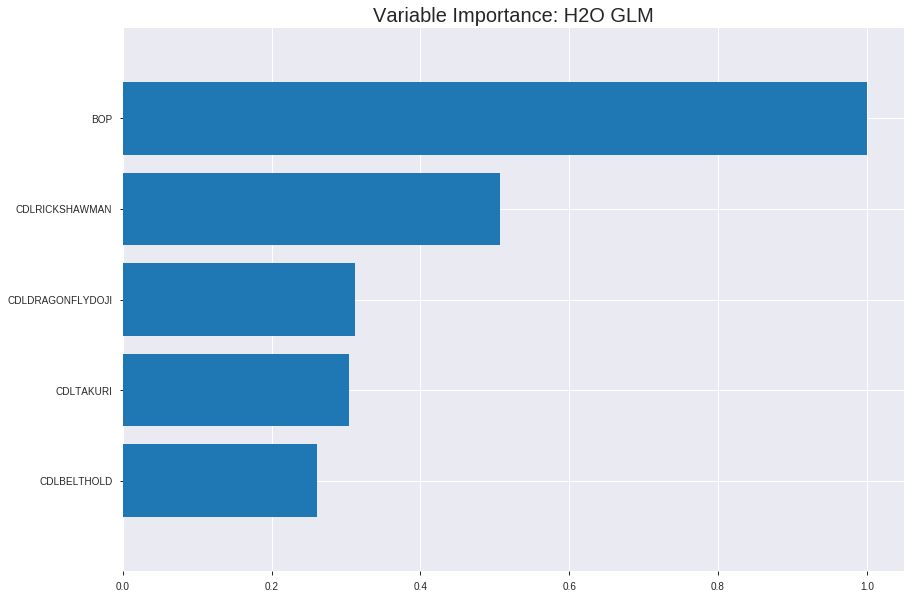

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_021041_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2401484485371459
RMSE: 0.4900494347891301
LogLoss: 0.6728724127271218
Null degrees of freedom: 1786
Residual degrees of freedom: 1781
Null deviance: 2476.0717307928226
Residual deviance: 2404.8460030867336
AIC: 2416.8460030867336
AUC: 0.6038305819827273
pr_auc: 0.5701920340501385
Gini: 0.20766116396545464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3746591112055494: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      167  750   0.8179   (750.0/917.0)
1      56   814   0.0644   (56.0/870.0)
Total  223  1564  0.451    (806.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374659     0.668858  318
max f2                       0.302458     0.827448  378
max f0point5                 0.431411     0.576286  269
max accuracy                 0.482778     0.582541  194
max precision                0.992491     1         0
max recall                   0.260888     1         397
max specificity              0.992491     1         0
max absolute_mcc             0.4111       0.17992   282
max min_per_class_accuracy   0.480191     0.572414  202
max mean_per_class_accuracy  0.482778     0.581574  194

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.688176           1.36935   1.36935            0.666667         0.716815  0.666667                    0.716815            0.0137931       0.0137931                  36.9349   36.9349
    2        0.0201455                   0.63168            1.25524   1.31229            0.611111         0.661909  0.638889                    0.689362            0.0126437       0.0264368                  25.5236   31.2292
    3        0.0302182                   0.607306           1.25524   1.29327            0.611111         0.619335  0.62963                     0.666019            0.0126437       0.0390805                  25.5236   29.3274
    4        0.040291                    0.595234           1.36935   1.31229            0.666667         0.600452  0.638889                    0.649627            0.0137931       0.0528736                  36.9349   31.2292
    5        0.0503637                   0.582029           1.48346   1.34653            0.722222         0.588807  0.655556                    0.637463            0.0149425       0.0678161                  48.3461   34.6526
    6        0.100168                    0.546798           1.36166   1.35405            0.662921         0.556626  0.659218                    0.597271            0.0678161       0.135632                   36.1656   35.4049
    7        0.151091                    0.543014           1.0383    1.24763            0.505495         0.544733  0.607407                    0.579564            0.0528736       0.188506                   3.82973   24.7629
    8        0.200336                    0.540433           0.910306  1.16471            0.443182         0.541745  0.567039                    0.570267            0.0448276       0.233333                   -8.96944  16.4711
    9        0.309457                    0.538734           1.20081   1.17744            0.584615         0.5389    0.573237                    0.559207            0.131034        0.364368                   20.0813   17.7442
    10       0.400112                    0.531119           1.14112   1.16921            0.555556         0.534807  0.569231                    0.553678            0.103448        0.467816                   14.1124   16.9213
    11       0.500839                    0.479954           1.06125   1.1475             0.516667         0.498312  0.558659                    0.542543            0.106897        0.574713                   6.12452   14.7499
    12       0.658086                    0.47778            0.95026   1.10037            0.462633         0.478016  0.535714                    0.527125            0.149425        0.724138                   -4.97403  10.0369
    13       0.700056                    0.475276           0.958544  1.09187            0.466667         0.475991  0.531575                    0.524059            0.0402299       0.764368                   -4.14559  9.18667
    14       0.799664                    0.437251           1.05009   1.08666            0.511236         0.46947   0.529041                    0.517259            0.104598        0.868966                   5.00904   8.6663
    15       0.918858                    0.372824           0.732891  1.04077            0.356808         0.387589  0.506699                    0.500438            0.0873563       0.956322                   -26.7109  4.07717
    16       1                           0.257708           0.538296  1                  0.262069         0.332966  0.486849                    0.486849          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24676416970945722
RMSE: 0.49675363079645146
LogLoss: 0.6865542844891585
Null degrees of freedom: 510
Residual degrees of freedom: 505
Null deviance: 708.8026372780396
Residual deviance: 701.65847874792
AIC: 713.65847874792
AUC: 0.5539751838235294
pr_auc: 0.555633663741806
Gini: 0.10795036764705879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3693328809970386: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    247  0.9686   (247.0/255.0)
1      2    254  0.0078   (2.0/256.0)
Total  10   501  0.4873   (249.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369333     0.67107   302
max f2                       0.315603     0.83442   311
max f0point5                 0.394119     0.573218  277
max accuracy                 0.480566     0.565558  174
max precision                0.569331     1         0
max recall                   0.315603     1         311
max specificity              0.569331     1         0
max absolute_mcc             0.479758     0.131623  187
max min_per_class_accuracy   0.481133     0.558594  166
max mean_per_class_accuracy  0.480566     0.56551   174

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.553427           1.99609   1.99609            1                0.55938   1                           0.55938             0.0234375       0.0234375                  99.6094    99.6094
    2        0.0215264                   0.551675           0.798438  1.4517             0.4              0.552587  0.727273                    0.556292            0.0078125       0.03125                    -20.1562   45.1705
    3        0.0313112                   0.549864           1.19766   1.37231            0.6              0.550631  0.6875                      0.554523            0.0117188       0.0429688                  19.7656    37.2314
    4        0.0450098                   0.548568           1.71094   1.47537            0.857143         0.548792  0.73913                     0.552779            0.0234375       0.0664062                  71.0938    47.5374
    5        0.0508806                   0.547302           0.665365  1.38191            0.333333         0.547956  0.692308                    0.552222            0.00390625      0.0703125                  -33.4635   38.1911
    6        0.101761                    0.543478           0.998047  1.18998            0.5              0.545508  0.596154                    0.548865            0.0507812       0.121094                   -0.195312  18.9979
    7        0.150685                    0.541415           0.958125  1.1147             0.48             0.542396  0.558442                    0.546765            0.046875        0.167969                   -4.1875    11.4702
    8        0.268102                    0.538734           0.93151   1.03447            0.466667         0.539142  0.518248                    0.543427            0.109375        0.277344                   -6.84896   3.44719
    9        0.30137                     0.535606           0.939338  1.02397            0.470588         0.536403  0.512987                    0.542651            0.03125         0.308594                   -6.06618   2.39702
    10       0.401174                    0.525122           1.29159   1.09055            0.647059         0.531776  0.546341                    0.539946            0.128906        0.4375                     29.159     9.05488
    11       0.500978                    0.481023           1.21331   1.11501            0.607843         0.487469  0.558594                    0.529491            0.121094        0.558594                   21.3312    11.5005
    12       0.716243                    0.47778            0.889169  1.04713            0.445455         0.478604  0.52459                     0.514197            0.191406        0.75                       -11.0831   4.71311
    13       0.800391                    0.474184           0.835574  1.02489            0.418605         0.475423  0.513447                    0.510121            0.0703125       0.820312                   -16.4426   2.48892
    14       0.900196                    0.379981           1.09589   1.03276            0.54902          0.45045   0.517391                    0.503505            0.109375        0.929688                   9.58946    3.27615
    15       1                           0.307516           0.704504  1                  0.352941         0.363978  0.500978                    0.48958             0.0703125       1                          -29.5496   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 02:10:41  0.000 sec   2            7.6       6             1.3819            1.38517
    2019-07-25 02:10:41  0.005 sec   4            4.7       6             1.37993           1.38418
    2019-07-25 02:10:41  0.008 sec   6            2.9       6             1.3771            1.3828
    2019-07-25 02:10:41  0.010 sec   8            1.8       6             1.3733            1.38102
    2019-07-25 02:10:41  0.012 sec   10           1.1       6             1.36859           1.37897
    2019-07-25 02:10:41  0.015 sec   12           0.7       6             1.36326           1.37689
    2019-07-25 02:10:41  0.017 sec   14           0.43      6             1.35783           1.3751
    2019-07-25 02:10:41  0.022 sec   16           0.27      6             1.35287           1.37385
    2019-07-25 02:10:41  0.029 sec   18           0.17      6             1.34878           1.37322
    2019-07-25 02:10:41  0.036 sec   20           0.1       6             1.34574           1.37311
    2019-07-25 02:10:41  0.038 sec   22           0.065     6             1.34373           1.37334
    2019-07-25 02:10:41  0.040 sec   24           0.04      6             1.34252           1.37372
    2019-07-25 02:10:41  0.043 sec   26           0.025     6             1.34187           1.37412
    2019-07-25 02:10:41  0.045 sec   27           0.015     6             1.34155           1.37446
    2019-07-25 02:10:41  0.047 sec   28           0.0096    6             1.3414            1.37472

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55859375)

('F1', 0.6485013623978202)

('auc', 0.5512561274509804)

('logloss', 0.6870493784194438)

('mean_per_class_error', 0.4524509803921568)

('rmse', 0.4970429882351414)

('mse', 0.24705173215371895)

glm prediction progress: |████████████████████████████████████████████████| 100%


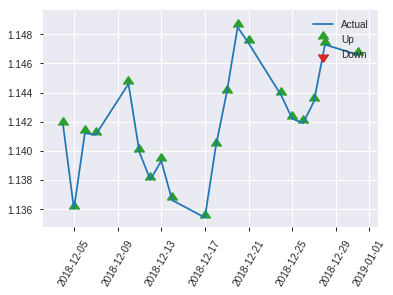


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24705173215371895
RMSE: 0.4970429882351414
LogLoss: 0.6870493784194438
Null degrees of freedom: 255
Residual degrees of freedom: 250
Null deviance: 354.2266765121979
Residual deviance: 351.7692817507552
AIC: 363.7692817507552
AUC: 0.5512561274509804
pr_auc: 0.5055921879916265
Gini: 0.10251225490196081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36871367645997993: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    128  0.9412   (128.0/136.0)
1      1    119  0.0083   (1.0/120.0)
Total  9    247  0.5039   (129.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368714     0.648501  148
max f2                       0.368714     0.818432  148
max f0point5                 0.376201     0.53839   141
max accuracy                 0.54186      0.558594  32
max precision                0.556191     0.666667  2
max recall                   0.31688      1         156
max specificity              0.567756     0.992647  0
max absolute_mcc             0.368714     0.136804  148
max min_per_class_accuracy   0.484684     0.536765  80
max mean_per_class_accuracy  0.482382     0.547549  82

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.553104           1.42222   1.42222            0.666667         0.560296  0.666667                    0.560296            0.0166667       0.0166667                  42.2222   42.2222
    2        0.0234375                   0.55033            0.711111  1.06667            0.333333         0.550515  0.5                         0.555406            0.00833333      0.025                      -28.8889  6.66667
    3        0.03125                     0.548969           0         0.8                0                0.549225  0.375                       0.553861            0               0.025                      -100      -20
    4        0.0429688                   0.548536           1.42222   0.969697           0.666667         0.548681  0.454545                    0.552448            0.0166667       0.0416667                  42.2222   -3.0303
    5        0.0507812                   0.547594           2.13333   1.14872            1                0.54833   0.538462                    0.551814            0.0166667       0.0583333                  113.333   14.8718
    6        0.101562                    0.543719           1.31282   1.23077            0.615385         0.545478  0.576923                    0.548646            0.0666667       0.125                      31.2821   23.0769
    7        0.152344                    0.541578           1.14872   1.20342            0.538462         0.54251   0.564103                    0.546601            0.0583333       0.183333                   14.8718   20.3419
    8        0.328125                    0.538734           0.948148  1.06667            0.444444         0.539065  0.5                         0.542564            0.166667        0.35                       -5.18519  6.66667
    9        0.402344                    0.534254           1.12281   1.07702            0.526316         0.535939  0.504854                    0.541342            0.0833333       0.433333                   12.2807   7.70227
    10       0.5                         0.48453            1.10933   1.08333            0.52             0.524686  0.507812                    0.538088            0.108333        0.541667                   10.9333   8.33333
    11       0.601562                    0.479325           0.820513  1.03896            0.384615         0.481045  0.487013                    0.528458            0.0833333       0.625                      -17.9487  3.8961
    12       0.769531                    0.47778            1.09147   1.05042            0.511628         0.47781   0.492386                    0.517403            0.183333        0.808333                   9.14729   5.0423
    13       0.800781                    0.475558           0.533333  1.03024            0.25             0.475962  0.482927                    0.515785            0.0166667       0.825                      -46.6667  3.02439
    14       0.898438                    0.461573           1.024     1.02957            0.48             0.473273  0.482609                    0.511165            0.1             0.925                      2.4       2.95652
    15       1                           0.315603           0.738462  1                  0.346154         0.361438  0.46875                     0.495958            0.075           1                          -26.1538  0

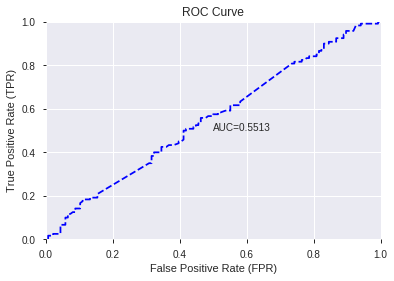

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


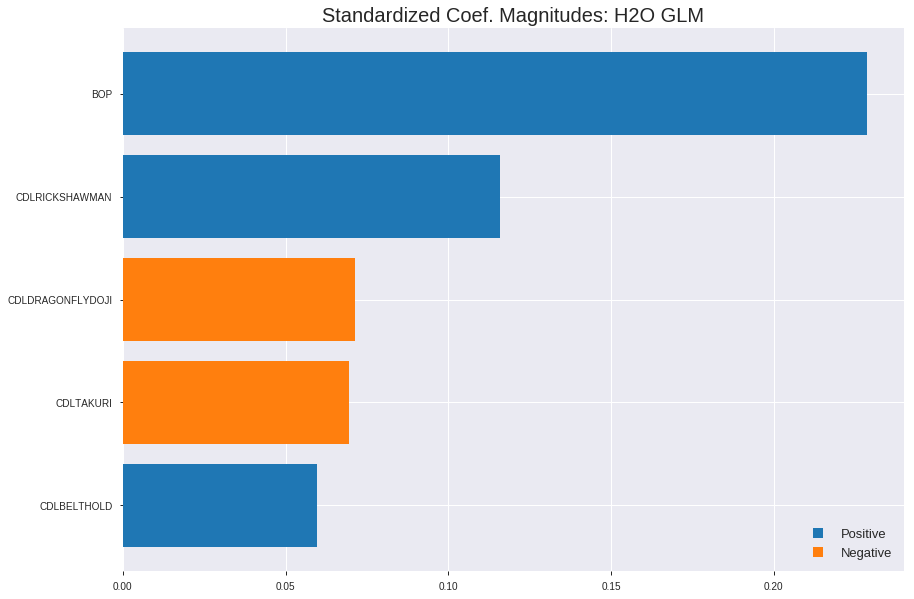

'log_likelihood'
--2019-07-25 02:10:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_021041_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_021041_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP', 'CDLRICKSHAWMAN', 'CDLDRAGONFLYDOJI', 'CDLTAKURI', 'CDLBELTHOLD']

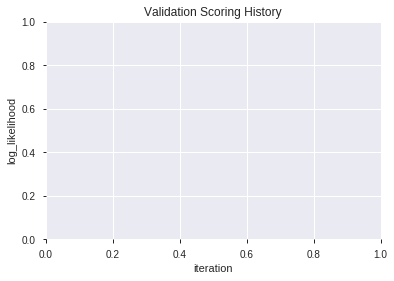

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_021056_model_7  0.571998  0.684398              0.424510  0.495576  0.245596
1               XGBoost_1_AutoML_20190725_021056  0.566575  0.685740              0.455147  0.496227  0.246241
2               XGBoost_3_AutoML_20190725_021056  0.566115  0.686007              0.481618  0.496569  0.246581
3  XGBoost_grid_1_AutoML_20190725_021056_model_3  0.564369  0.687118              0.452941  0.497012  0.247021
4  XGBoost_grid_1_AutoML_20190725_021056_model_5  0.563358  0.683300              0.477941  0.495417  0.245438
5  XGBoost_grid_1_AutoML_20190725_021056_model_6  0.559559  0.687509              0.477941  0.497408  0.247415
6  XGBoost_grid_1_AutoML_20190725_021056_model_2  0.559069  0.688255              0.476225  0.497561  0.247567
7               XGBoost_2_AutoML_20190725_021056  0.551195  0.688459              0.473039  0.497606  0.247611
8  XGBoost_grid_1_AutoML_20190725_021056_model_1  0.550031  0.689551              0.481618  0.498333  0.248335
9  XGBoost_grid_1_AutoML_20190725_021056_model_4  0.547243  0.689976              0.473039  0.498410  0.248413

variable  relative_importance  scaled_importance  percentage
0               BOP          1497.220459           1.000000    0.835965
1    CDLRICKSHAWMAN            91.243507           0.060942    0.050945
2         CDLTAKURI            75.145256           0.050190    0.041957
3  CDLDRAGONFLYDOJI            73.406067           0.049028    0.040986
4       CDLBELTHOLD            53.993500           0.036062    0.030147

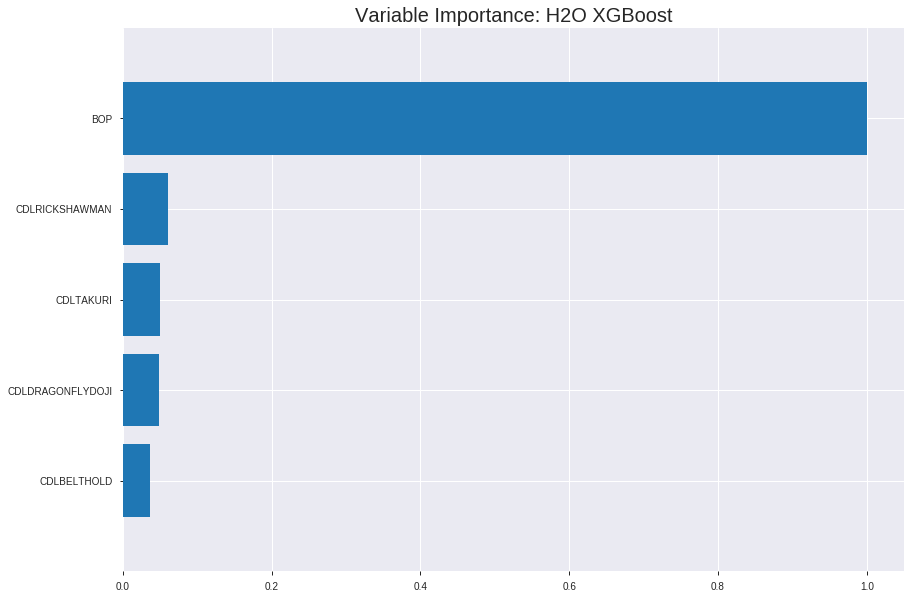

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_021056_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22727935601197094
RMSE: 0.4767382468524745
LogLoss: 0.6456325921275333
Mean Per-Class Error: 0.3728619060153675
AUC: 0.6742162724526505
pr_auc: 0.6483465732191159
Gini: 0.34843254490530096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35795339941978455: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      192  725   0.7906   (725.0/917.0)
1      48   822   0.0552   (48.0/870.0)
Total  240  1547  0.4326   (773.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357953     0.680182  339
max f2                       0.246615     0.830932  387
max f0point5                 0.487581     0.61675   203
max accuracy                 0.487581     0.626749  203
max precision                0.720009     1         0
max recall                   0.16696      1         399
max specificity              0.720009     1         0
max absolute_mcc             0.47711      0.254735  224
max min_per_class_accuracy   0.484833     0.625954  206
max mean_per_class_accuracy  0.47711      0.627138  224

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106323                   0.693404           1.7297    1.7297             0.842105         0.712875  0.842105                    0.712875            0.0183908       0.0183908                  72.9704   72.9704
    2        0.0235031                   0.680378           1.6075    1.66278            0.782609         0.684307  0.809524                    0.697231            0.0206897       0.0390805                  60.7496   66.2781
    3        0.0324566                   0.673215           1.66889   1.66447            0.8125           0.674391  0.810345                    0.69093             0.0149425       0.054023                   66.8894   66.4467
    4        0.0442082                   0.669447           1.46716   1.61202            0.714286         0.669986  0.78481                     0.685363            0.0172414       0.0712644                  46.7159   61.2018
    5        0.0503637                   0.666664           1.30711   1.57475            0.636364         0.668642  0.766667                    0.683319            0.00804598      0.0793103                  30.7106   57.4751
    6        0.100168                    0.635311           1.61552   1.59502            0.786517         0.648211  0.776536                    0.665863            0.0804598       0.15977                    61.5524   59.5023
    7        0.151651                    0.596423           1.40656   1.53104            0.684783         0.616273  0.745387                    0.649028            0.0724138       0.232184                   40.6559   53.1043
    8        0.200336                    0.573478           1.10964   1.42864            0.54023          0.582253  0.695531                    0.632801            0.054023        0.286207                   10.9645   42.8636
    9        0.301623                    0.569373           1.18021   1.34521            0.574586         0.569638  0.654917                    0.61159             0.11954         0.405747                   18.0212   34.5214
    10       0.401791                    0.524662           1.13602   1.29306            0.553073         0.546548  0.629526                    0.595375            0.113793        0.51954                    13.6024   29.3062
    11       0.502518                    0.483638           1.10689   1.25574            0.538889         0.50344   0.611359                    0.576947            0.111494        0.631034                   10.689    25.5745
    12       0.700056                    0.466498           0.913546  1.15918            0.444759         0.469484  0.564349                    0.546624            0.18046         0.811494                   -8.64544  15.9185
    13       0.700056                    0.466381           0         1.15918            0                0         0.564349                    0.546624            0               0.811494                   -100      15.9185
    14       0.799664                    0.415174           0.796222  1.11397            0.38764          0.445922  0.542337                    0.53408             0.0793103       0.890805                   -20.3778  11.3973
    15       0.900392                    0.296461           0.684674  1.06595            0.333333         0.367208  0.518956                    0.515412            0.0689655       0.95977                    -31.5326  6.59473
    16       1                           0.16696            0.403881  1                  0.196629         0.250623  0.486849                    0.489037         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24626113841234387
RMSE: 0.49624705380721795
LogLoss: 0.6855323446970496
Mean Per-Class Error: 0.43628216911764706
AUC: 0.5649203431372549
pr_auc: 0.5667979871900386
Gini: 0.12984068627450984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3553961515426636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   228  0.8941   (228.0/255.0)
1      9    247  0.0352   (9.0/256.0)
Total  36   475  0.4638   (237.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355396     0.675787  191
max f2                       0.283611     0.833876  207
max f0point5                 0.355396     0.57282   191
max accuracy                 0.520734     0.563601  82
max precision                0.692406     1         0
max recall                   0.283611     1         207
max specificity              0.692406     1         0
max absolute_mcc             0.355396     0.138188  191
max min_per_class_accuracy   0.499163     0.550781  99
max mean_per_class_accuracy  0.520734     0.563718  82

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0195695                   0.669447           1.19766   1.19766            0.6              0.676876  0.6                         0.676876            0.0234375       0.0234375                  19.7656   19.7656
    2        0.0215264                   0.659707           1.99609   1.27024            1                0.661585  0.636364                    0.675486            0.00390625      0.0273438                  99.6094   27.0241
    3        0.0332681                   0.635126           1.66341   1.40901            0.833333         0.638802  0.705882                    0.662538            0.0195312       0.046875                   66.3411   40.9007
    4        0.0410959                   0.633942           1.49707   1.42578            0.75             0.634485  0.714286                    0.657195            0.0117188       0.0585938                  49.707    42.5781
    5        0.0508806                   0.623215           1.59688   1.45868            0.8              0.628469  0.730769                    0.651671            0.015625        0.0742188                  59.6875   45.8684
    6        0.101761                    0.597679           1.22837   1.34352            0.615385         0.611509  0.673077                    0.63159             0.0625          0.136719                   22.8365   34.3525
    7        0.236791                    0.569373           0.925725  1.10528            0.463768         0.572476  0.553719                    0.59788             0.125           0.261719                   -7.42754  10.5275
    8        0.30137                     0.550344           1.33073   1.15359            0.666667         0.558594  0.577922                    0.589462            0.0859375       0.347656                   33.0729   15.3587
    9        0.403131                    0.525256           1.11321   1.14339            0.557692         0.538963  0.572816                    0.576715            0.113281        0.460938                   11.3206   14.3394
    10       0.502935                    0.498903           0.900199  1.09513            0.45098          0.514356  0.548638                    0.56434             0.0898438       0.550781                   -9.98009  9.51331
    11       0.729941                    0.466498           0.894801  1.03283            0.448276         0.471179  0.517426                    0.535368            0.203125        0.753906                   -10.5199  3.28314
    12       0.802348                    0.446512           1.02502   1.03213            0.513514         0.456685  0.517073                    0.528267            0.0742188       0.828125                   2.50211   3.21265
    13       0.900196                    0.397487           0.958125  1.02408            0.48             0.420473  0.513043                    0.51655             0.09375         0.921875                   -4.1875   2.40829
    14       1                           0.283611           0.782782  1                  0.392157         0.323648  0.500978                    0.497298            0.078125        1                          -21.7218  0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:11:02  2.680 sec   0                  0.5              0.693147            0.5             0                  1                0.513151                         0.5                0.693147              0.5               0                    1                  0.499022
    2019-07-25 02:11:02  2.724 sec   5                  0.494429         0.682037            0.641937        0.603916           1.45493          0.440963                         0.498625           0.690397              0.543543          0.530991             1.99609            0.499022
    2019-07-25 02:11:02  2.762 sec   10                 0.489457         0.672069            0.648781        0.616078           1.55608          0.438724                         0.497856           0.688846              0.550682          0.560934             1.99609            0.477495
    2019-07-25 02:11:02  2.797 sec   15                 0.486379         0.665825            0.653482        0.621324           1.55608          0.434247                         0.496535           0.686172              0.56502           0.576887             1.99609            0.459883
    2019-07-25 02:11:03  2.831 sec   20                 0.484196         0.661304            0.657091        0.624858           1.57072          0.437045                         0.495989           0.685055              0.562745          0.567096             1.99609            0.46184
    2019-07-25 02:11:03  2.867 sec   25                 0.482235         0.657218            0.660924        0.624338           1.79727          0.438724                         0.495984           0.685025              0.564491          0.568548             1.99609            0.46184
    2019-07-25 02:11:03  2.909 sec   30                 0.480664         0.65394             0.664168        0.626976           1.64322          0.428092                         0.496379           0.685798              0.561198          0.562961             1.19766            0.46771
    2019-07-25 02:11:03  2.970 sec   35                 0.479542         0.651569            0.666281        0.639761           1.66278          0.432009                         0.496745           0.68654               0.556388          0.557218             1.19766            0.471624
    2019-07-25 02:11:03  3.035 sec   40                 0.478365         0.64905             0.670688        0.644183           1.7297           0.432009                         0.495989           0.685015              0.564928          0.56309              1.19766            0.471624
    2019-07-25 02:11:03  3.088 sec   45                 0.477793         0.647816            0.671192        0.645869           1.7297           0.432009                         0.496386           0.685836              0.56371           0.564115             1.19766            0.475538
    2019-07-25 02:11:03  3.153 sec   50                 0.476738         0.645633            0.674216        0.648347           1.7297           0.432569                         0.496247           0.685532              0.56492           0.566798             1.19766            0.463796

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
BOP               1497.22                1                    0.835965
CDLRICKSHAWMAN    91.2435                0.0609419            0.0509453
CDLTAKURI         75.1453                0.0501898            0.0419569
CDLDRAGONFLYDOJI  73.4061                0.0490282            0.0409859
CDLBELTHOLD       53.9935                0.0360625            0.030147

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5703125)

('F1', 0.6566265060240964)

('auc', 0.5719975490196079)

('logloss', 0.6843980486182122)

('mean_per_class_error', 0.4245098039215687)

('rmse', 0.49557594363547264)

('mse', 0.24559551591018916)

xgboost prediction progress: |████████████████████████████████████████████| 100%


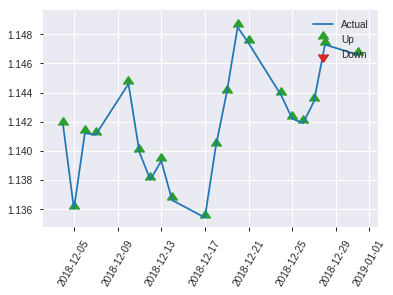


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24559551591018916
RMSE: 0.49557594363547264
LogLoss: 0.6843980486182122
Mean Per-Class Error: 0.4245098039215687
AUC: 0.5719975490196079
pr_auc: 0.5210450596963355
Gini: 0.14399509803921573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44552290439605713: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      33   103  0.7574   (103.0/136.0)
1      11   109  0.0917   (11.0/120.0)
Total  44   212  0.4453   (114.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445523     0.656627  94
max f2                       0.283611     0.815217  126
max f0point5                 0.445523     0.563017  94
max accuracy                 0.549466     0.570312  36
max precision                0.63464      0.7       6
max recall                   0.283611     1         126
max specificity              0.692406     0.992647  0
max absolute_mcc             0.445523     0.199704  94
max min_per_class_accuracy   0.498903     0.544118  61
max mean_per_class_accuracy  0.445523     0.57549   94

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.015625                    0.669447           0.533333  0.533333           0.25             0.67792   0.25                        0.67792             0.00833333      0.00833333                 -46.6667  -46.6667
    2        0.0234375                   0.650486           2.13333   1.06667            1                0.656309  0.5                         0.670716            0.0166667       0.025                      113.333   6.66667
    3        0.03125                     0.63481            2.13333   1.33333            1                0.635126  0.625                       0.661819            0.0166667       0.0416667                  113.333   33.3333
    4        0.0429688                   0.632091           1.42222   1.35758            0.666667         0.634005  0.636364                    0.654233            0.0166667       0.0583333                  42.2222   35.7576
    5        0.0507812                   0.622113           1.06667   1.31282            0.5              0.627463  0.615385                    0.650115            0.00833333      0.0666667                  6.66667   31.2821
    6        0.101562                    0.589263           1.14872   1.23077            0.538462         0.612188  0.576923                    0.631152            0.0583333       0.125                      14.8718   23.0769
    7        0.292969                    0.569373           1.00136   1.08089            0.469388         0.571541  0.506667                    0.592206            0.191667        0.316667                   0.136054  8.08889
    8        0.304688                    0.565974           0         1.03932            0                0.566146  0.487179                    0.591204            0               0.316667                   -100      3.93162
    9        0.402344                    0.535951           1.45067   1.13916            0.68             0.550877  0.533981                    0.581416            0.141667        0.458333                   45.0667   13.9159
    10       0.5                         0.498812           0.938667  1.1                0.44             0.515543  0.515625                    0.56855             0.0916667       0.55                       -6.13333  10
    11       0.753906                    0.466498           1.01744   1.07219            0.476923         0.471857  0.502591                    0.535985            0.258333        0.808333                   1.74359   7.21934
    12       0.804688                    0.45559            1.14872   1.07702            0.538462         0.459142  0.504854                    0.531136            0.0583333       0.866667                   14.8718   7.70227
    13       0.898438                    0.396741           0.8       1.04812            0.375            0.428419  0.491304                    0.520417            0.075           0.941667                   -20       4.81159
    14       1                           0.283611           0.574359  1                  0.269231         0.343143  0.46875                     0.502413            0.0583333       1                          -42.5641  0

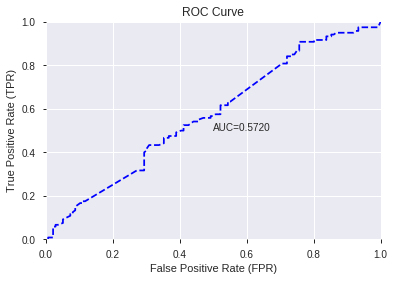

This function is available for GLM models only


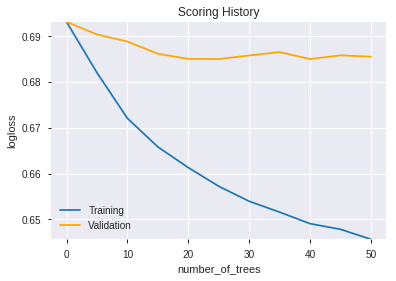

--2019-07-25 02:11:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_021056_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_021056_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP', 'CDLRICKSHAWMAN', 'CDLTAKURI', 'CDLDRAGONFLYDOJI', 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

74

['BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_1_5',
 'MAVP_14_5',
 'WMA_20',
 'BBANDS_upperband_20_3_4',
 'BBANDS_middleband_20_3_4',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_20_5_4',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_middleband_24_3_5',
 'BOP',
 'ADX_8',
 'aroondown_8',
 'DX_8',
 'MACDFIX_8',
 'MINUS_DI_8',
 'MOM_8',
 'PLUS_DM_8',
 'ROC_8',
 'ROCR_8',
 'ROCR100_8',
 'ADX_12',
 'aroondown_12',
 'aroonup_12',
 'CCI_12',
 'CMO_12',
 'MACDFIX_12',
 'MINUS_DI_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'TRIX_12',
 'MINUS_DM_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCP_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'MACDFIX_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'WILLR_20',
 'ADX_24',
 'MACDFIX_signal_24',
 'MACDFIX_hist_24',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'aroonup_30',
 'MOM_30',
 'ROCR_30',
 'WILLR_30',
 'MACDEXT_signal',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'NATR_12',
 'ATR_14',
 'TR

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_021235_model_8  0.587439  0.666099              0.393137  0.487198  0.237362
1  DeepLearning_grid_1_AutoML_20190725_021235_model_6  0.583701  0.696294              0.439951  0.501149  0.251150
2  DeepLearning_grid_1_AutoML_20190725_021235_model_9  0.580208  0.663908              0.391422  0.486286  0.236474
3  DeepLearning_grid_1_AutoML_20190725_021235_model_7  0.567525  0.725154              0.414216  0.511928  0.262070
4  DeepLearning_grid_1_AutoML_20190725_021235_model_5  0.557659  0.681933              0.433088  0.495384  0.245405
5  DeepLearning_grid_1_AutoML_20190725_021235_model_4  0.540993  0.796819              0.452206  0.536888  0.288249
6  DeepLearning_grid_1_AutoML_20190725_021235_model_3  0.537500  0.929312              0.474755  0.564076  0.318182
7               DeepLearning_1_AutoML_20190725_021235  0.522978  0.755611              0.496324  0.522254  0.272750
8  DeepLearning_grid_1_AutoML_20190725_021235_model_2  0.510968  1.149370              0.488971  0.596202  0.355456
9  DeepLearning_grid_1_AutoML_20190725_021235_model_1  0.492953  1.210224              0.489461  0.606745  0.368140

variable  relative_importance  scaled_importance  percentage
0                    TRANGE             1.000000           1.000000    0.043312
1                       BOP             0.864317           0.864317    0.037435
2            CDLRICKSHAWMAN             0.559628           0.559628    0.024239
3              STOCHF_fastk             0.406183           0.406183    0.017593
4                MINUS_DI_8             0.399990           0.399990    0.017324
..                      ...                  ...                ...         ...
69  BBANDS_upperband_20_5_4             0.246237           0.246237    0.010665
70                   ROC_14             0.244608           0.244608    0.010594
71                   ROC_20             0.243443           0.243443    0.010544
72  BBANDS_lowerband_20_5_2             0.242609           0.242609    0.010508
73                   RSI_14             0.241174           0.241174    0.010446

[74 rows x 4 columns]

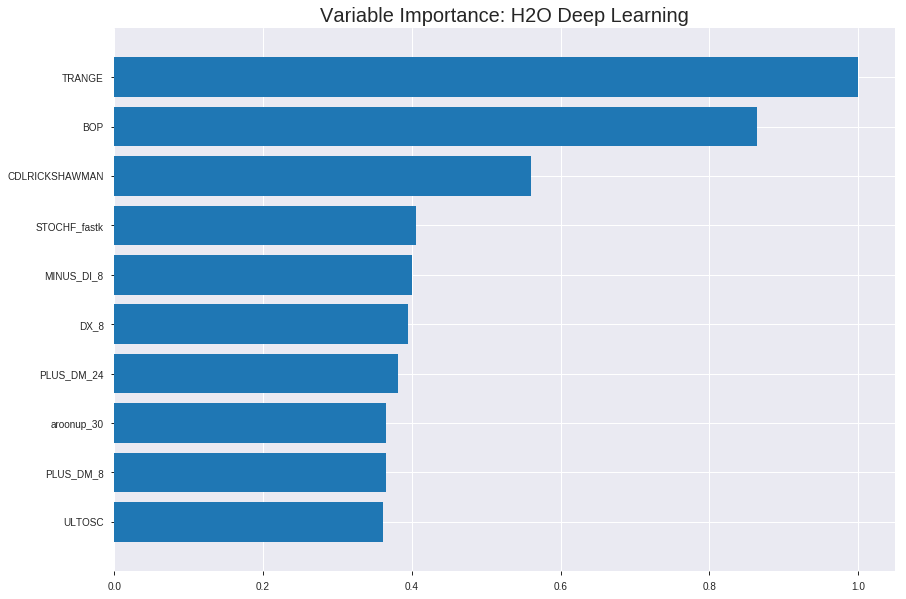

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_021235_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22012252571962077
RMSE: 0.46917217065766037
LogLoss: 0.6320702440479996
Mean Per-Class Error: 0.3468983065719049
AUC: 0.6933428596497826
pr_auc: 0.6700198937939803
Gini: 0.3866857192995652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4475000759124188: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      337  580   0.6325   (580.0/917.0)
1      64   806   0.0736   (64.0/870.0)
Total  401  1386  0.3604   (644.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4475       0.714539  160
max f2                       0.22922      0.845458  285
max f0point5                 0.514217     0.635848  89
max accuracy                 0.514217     0.648573  89
max precision                0.736037     1         0
max recall                   1.03202e-06  1         399
max specificity              0.736037     1         0
max absolute_mcc             0.4475       0.352167  160
max min_per_class_accuracy   0.539138     0.589967  45
max mean_per_class_accuracy  0.514217     0.653102  89

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 46.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.562697           1.8258    1.8258             0.888889         0.584045  0.888889                    0.584045            0.0183908       0.0183908                  82.5798   82.5798
    2        0.0201455                   0.554329           1.25524   1.54052            0.611111         0.558447  0.75                        0.571246            0.0126437       0.0310345                  25.5236   54.0517
    3        0.0302182                   0.550111           1.8258    1.63561            0.888889         0.552658  0.796296                    0.56505             0.0183908       0.0494253                  82.5798   63.5611
    4        0.040291                    0.546794           1.48346   1.59757            0.722222         0.548     0.777778                    0.560787            0.0149425       0.0643678                  48.3461   59.7573
    5        0.0503637                   0.54395            1.14112   1.50628            0.555556         0.545502  0.733333                    0.55773             0.0114943       0.0758621                  14.1124   50.6284
    6        0.539452                    0.539138           1.22677   1.25287            0.597254         0.539272  0.609959                    0.540995            0.6             0.675862                   22.6773   25.2869
    7        0.599888                    0.531491           1.17916   1.24544            0.574074         0.535665  0.606343                    0.540458            0.0712644       0.747126                   17.9161   24.5443
    8        0.700056                    0.502206           1.09012   1.22322            0.530726         0.518633  0.595524                    0.537335            0.109195        0.856322                   9.01239   22.3219
    9        0.799664                    0.414659           0.807762  1.17147            0.393258         0.4692    0.570329                    0.528848            0.0804598       0.936782                   -19.2238  17.1469
    10       0.899832                    0.22601            0.516374  1.09854            0.251397         0.327869  0.534826                    0.506475            0.0517241       0.988506                   -48.3626  9.85446
    11       1                           1.03202e-06        0.11475   1                  0.0558659        0.121184  0.486849                    0.467882            0.0114943       1                          -88.525   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2436247231131507
RMSE: 0.4935835523122207
LogLoss: 0.6799111254331897
Mean Per-Class Error: 0.42100183823529413
AUC: 0.5807138480392157
pr_auc: 0.3960187302905695
Gini: 0.16142769607843133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1311384341325728: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   234  0.9176   (234.0/255.0)
1      1    255  0.0039   (1.0/256.0)
Total  22   489  0.4599   (235.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.131138     0.684564  354
max f2                       0.131138     0.842697  354
max f0point5                 0.424239     0.593267  254
max accuracy                 0.482862     0.579256  188
max precision                0.522118     0.565611  86
max recall                   0.112805     1         364
max specificity              0.539138     0.74902   0
max absolute_mcc             0.348609     0.193532  289
max min_per_class_accuracy   0.509757     0.554688  118
max mean_per_class_accuracy  0.482862     0.578998  188

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 45.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.264188                    0.539138           1.0498    1.0498             0.525926         0.539138  0.525926                    0.539138            0.277344        0.277344                   4.97975   4.97975
    2        0.30137                     0.536145           1.36575   1.08878            0.684211         0.537329  0.545455                    0.538915            0.0507812       0.328125                   36.5748   8.87784
    3        0.401174                    0.524465           1.13503   1.10029            0.568627         0.529946  0.55122                     0.536684            0.113281        0.441406                   13.5034   10.0286
    4        0.500978                    0.508634           1.13503   1.10721            0.568627         0.518013  0.554688                    0.532964            0.113281        0.554688                   13.5034   10.7208
    5        0.600783                    0.487273           1.21331   1.12483            0.607843         0.499415  0.563518                    0.527391            0.121094        0.675781                   21.3312   12.4835
    6        0.700587                    0.454089           0.939338  1.09841            0.470588         0.47429   0.550279                    0.519826            0.09375         0.769531                   -6.06618  9.84091
    7        0.800391                    0.383267           0.939338  1.07857            0.470588         0.426974  0.540342                    0.508248            0.09375         0.863281                   -6.06618  7.85739
    8        0.900196                    0.241107           0.86106   1.05446            0.431373         0.316352  0.528261                    0.486973            0.0859375       0.949219                   -13.894   5.44582
    9        1                           0.0290227          0.508808  1                  0.254902         0.141025  0.500978                    0.452446            0.0507812       1                          -49.1192  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:20:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 02:20:28  2 min 13.101 sec  670 obs/sec       0.73587   1             1315       0.503082         0.699645            -0.0130687     0.549492        0.530718           1.36935          0.505876                         0.50206            0.697607              -0.00826264      0.579282          0.55899              0.665365           0.46771
    2019-07-25 02:20:42  2 min 26.716 sec  1022 obs/sec      8.19082   11            14637      0.481288         0.656058            0.0728065      0.650601        0.597422           1.48346          0.434807                         0.501807           0.696654              -0.00724677      0.554933          0.547407             1.66341            0.465753
    2019-07-25 02:20:55  2 min 40.023 sec  1161 obs/sec      17.1158   23            30586      0.469172         0.63207             0.1189         0.693343        0.67002            1.8258           0.360381                         0.493584           0.679911              0.0254974        0.580714          0.396019             1.0498             0.459883
    2019-07-25 02:21:08  2 min 53.179 sec  1251 obs/sec      26.7689   36            47836      0.457766         0.604292            0.16122        0.712038        0.663252           1.93991          0.343033                         0.498183           0.699732              0.0072521        0.585838          0.541164             0.998047           0.430528
    2019-07-25 02:21:22  3 min  6.539 sec  1295 obs/sec      36.4801   49            65190      0.457481         0.601352            0.162264       0.720081        0.685394           2.05402          0.339116                         0.545223           0.911688              -0.189078        0.592984          0.570073             1.99609            0.450098
    2019-07-25 02:21:34  3 min 19.414 sec  1333 obs/sec      46.202    62            82563      0.44877          0.577281            0.193863       0.748466        0.727038           2.05402          0.320649                         0.502338           0.722612              -0.00937775      0.586581          0.546537             0.844501           0.424658
    2019-07-25 02:21:36  3 min 20.715 sec  1332 obs/sec      46.202    62            82563      0.469172         0.63207             0.1189         0.693343        0.67002            1.8258           0.360381                         0.493584           0.679911              0.0254974        0.580714          0.396019             1.0498             0.459883

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
TRANGE                   1.0                    1.0                  0.04331199812901392
BOP                      0.8643171787261963     0.8643171787261963   0.03743530402786361
CDLRICKSHAWMAN           0.5596278309822083     0.5596278309822083   0.024238599568445523
STOCHF_fastk             0.40618255734443665    0.40618255734443665  0.01759257816374033
MINUS_DI_8               0.39998987317085266    0.39998987317085266  0.017324360638400486
---                      ---                    ---                  ---
BBANDS_upperband_20_5_4  0.24623678624629974    0.24623678624629974  0.010665007225194137
ROC_14                   0.24460849165916443    0.24460849165916443  0.010594482533082648
ROC_20                   0.243442565202713      0.243442565202713    0.010543983928582256
BBANDS_lowerband_20_5_2  0.24260933697223663    0.24260933697223663  0.010507895149022822
RSI_14                   0.24117398262023926    0.24117398262023926  0.01044572708401464


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6807228915662651)

('auc', 0.587438725490196)

('logloss', 0.6660990700264711)

('mean_per_class_error', 0.39313725490196083)

('rmse', 0.48719836352905105)

('mse', 0.23736224542538537)

deeplearning prediction progress: |███████████████████████████████████████| 100%


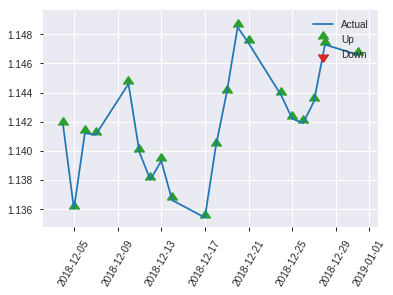


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23736224542538537
RMSE: 0.48719836352905105
LogLoss: 0.6660990700264711
Mean Per-Class Error: 0.39313725490196083
AUC: 0.587438725490196
pr_auc: 0.4797373279197174
Gini: 0.1748774509803921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3333150335361604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   99   0.7279   (99.0/136.0)
1      7    113  0.0583   (7.0/120.0)
Total  44   212  0.4141   (106.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333315     0.680723  125
max f2                       0.11179      0.821918  163
max f0point5                 0.333315     0.583678  125
max accuracy                 0.343856     0.585938  123
max precision                0.54767      1         0
max recall                   0.11179      1         163
max specificity              0.54767      1         0
max absolute_mcc             0.333315     0.282698  125
max min_per_class_accuracy   0.51928      0.566667  39
max mean_per_class_accuracy  0.333315     0.606863  125

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 45.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.539139           0.711111  0.711111           0.333333         0.542632  0.333333                    0.542632            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.351562                    0.539138           1.12797   1.11407            0.528736         0.539138  0.522222                    0.539255            0.383333        0.391667                   12.7969   11.4074
    3        0.402344                    0.532998           1.14872   1.11845            0.538462         0.535124  0.524272                    0.538733            0.0583333       0.45                       14.8718   11.8447
    4        0.5                         0.518163           1.28      1.15               0.6              0.526015  0.539062                    0.536249            0.125           0.575                      28        15
    5        0.601562                    0.498523           0.902564  1.10823            0.423077         0.507536  0.519481                    0.531402            0.0916667       0.666667                   -9.74359  10.8225
    6        0.699219                    0.469221           0.938667  1.08454            0.44             0.487244  0.50838                     0.525234            0.0916667       0.758333                   -6.13333  8.45438
    7        0.800781                    0.375626           1.39487   1.1239             0.653846         0.433224  0.526829                    0.513565            0.141667        0.9                        39.4872   12.3902
    8        0.898438                    0.243955           0.597333  1.06667            0.28             0.304422  0.5                         0.490832            0.0583333       0.958333                   -40.2667  6.66667
    9        1                           0.0361023          0.410256  1                  0.192308         0.149224  0.46875                     0.456137            0.0416667       1                          -58.9744  0

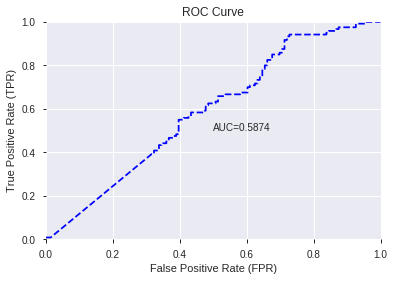

This function is available for GLM models only


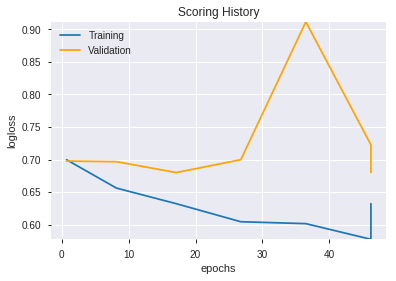

--2019-07-25 02:22:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_021235_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_021235_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'MINUS_DI_8',
 'DX_8',
 'PLUS_DM_24',
 'aroonup_30',
 'PLUS_DM_8',
 'ULTOSC',
 'CCI_12',
 'MINUS_DI_12',
 'aroondown_8',
 'aroonup_20',
 'PLUS_DI_24',
 'CDLSHORTLINE',
 'ADX_12',
 'STOCHRSI_fastd',
 'PLUS_DM_14',
 'aroonup_12',
 'HT_PHASOR_quadrature',
 'aroondown_12',
 'ATR_14',
 'aroondown_20',
 'NATR_12',
 'STOCH_slowd',
 'ADX_8',
 'ADX_24',
 'MACDFIX_signal_24',
 'BETA_8',
 'WILLR_14',
 'WILLR_20',
 'STDDEV_8',
 'VAR_8',
 'BBANDS_lowerband_14_1_5',
 'WILLR_30',
 'STDDEV_12',
 'BBANDS_lowerband_20_5_3',
 'ROCR_8',
 'ROCP_14',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_middleband_14_0_5',
 'ROCR100_12',
 'MACDFIX_hist_24',
 'MINUS_DM_14',
 'MACDFIX_20',
 'BBANDS_middleband_20_3_4',
 'ROCR_30',
 'CMO_12',
 'ROCR_12',
 'LINEARREG_SLOPE_12',
 'CORREL_12',
 'MOM_8',
 'BBANDS_upperband_14_0_5',
 'HT_PHASOR_inphase',
 'RSI_12',
 'MACDEXT_signal',
 'MAVP_14_5',
 'TRIX_12',
 'MOM_20',
 'BBANDS_middleband_24_3_5',
 'MOM_30',
 'ROCP_20',
 'ROC_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_022301_model_1  0.592096  0.682837              0.409314  0.494918  0.244944

variable  relative_importance  scaled_importance  percentage
0                 PLUS_DM_14             1.433286           1.000000    0.073743
1                 MINUS_DI_8             1.299476           0.906641    0.066859
2                 PLUS_DM_24             1.112841           0.776427    0.057256
3                     CMO_12             0.882072           0.615420    0.045383
4                     RSI_14             0.877232           0.612042    0.045134
..                       ...                  ...                ...         ...
69                aroonup_20             0.021764           0.015184    0.001120
70                MACDFIX_12             0.018452           0.012874    0.000949
71  BBANDS_middleband_24_3_5             0.009902           0.006908    0.000509
72         MACDFIX_signal_24             0.001732           0.001208    0.000089
73              aroondown_20             0.000603           0.000421    0.000031

[74 rows x 4 columns]

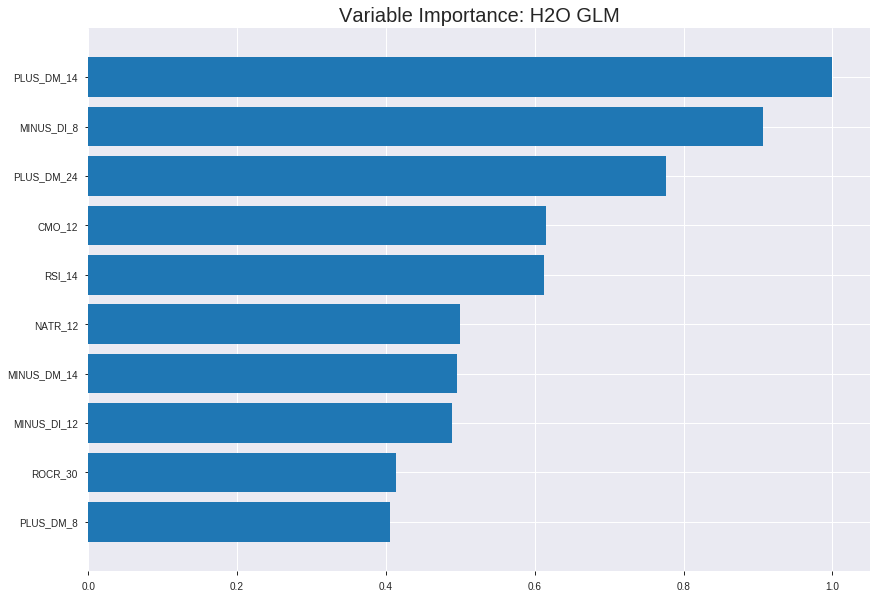

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_022301_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22776208868612038
RMSE: 0.4772442652207781
LogLoss: 0.6468103469929251
Null degrees of freedom: 1786
Residual degrees of freedom: 1712
Null deviance: 2476.0717307928226
Residual deviance: 2311.700180152714
AIC: 2461.700180152714
AUC: 0.6694894646460848
pr_auc: 0.6106957196880474
Gini: 0.33897892929216966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32947835404468384: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      227  690   0.7525   (690.0/917.0)
1      39   831   0.0448   (39.0/870.0)
Total  266  1521  0.4079   (729.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329478     0.695107  303
max f2                       0.329478     0.830834  303
max f0point5                 0.497733     0.620752  187
max accuracy                 0.502842     0.630666  183
max precision                0.999948     1         0
max recall                   0.100449     1         396
max specificity              0.999948     1         0
max absolute_mcc             0.329478     0.284664  303
max min_per_class_accuracy   0.497733     0.629885  187
max mean_per_class_accuracy  0.440103     0.631543  230

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.784778           1.36935   1.36935            0.666667         0.823381  0.666667                    0.823381            0.0137931       0.0137931                  36.9349   36.9349
    2        0.0201455                   0.763373           1.48346   1.4264             0.722222         0.772993  0.694444                    0.798187            0.0149425       0.0287356                  48.3461   42.6405
    3        0.0302182                   0.74333            0.684674  1.17916            0.333333         0.752666  0.574074                    0.783013            0.00689655      0.0356322                  -31.5326  17.9161
    4        0.040291                    0.727871           1.59757   1.28376            0.777778         0.735403  0.625                       0.771111            0.016092        0.0517241                  59.7573   28.3764
    5        0.0503637                   0.716196           1.25524   1.27806            0.611111         0.721815  0.622222                    0.761252            0.0126437       0.0643678                  25.5236   27.8059
    6        0.100168                    0.680661           1.43089   1.35405            0.696629         0.697175  0.659218                    0.729392            0.0712644       0.135632                   43.0892   35.4049
    7        0.149972                    0.642779           1.26934   1.32592            0.617978         0.660108  0.645522                    0.706384            0.0632184       0.198851                   26.934    32.5918
    8        0.200336                    0.617888           1.39217   1.34257            0.677778         0.629537  0.653631                    0.687065            0.0701149       0.268966                   39.2171   34.2574
    9        0.299944                    0.569701           1.22318   1.30293            0.595506         0.592965  0.634328                    0.655815            0.121839        0.390805                   22.3182   30.2925
    10       0.400112                    0.532221           1.22782   1.28412            0.597765         0.550281  0.625175                    0.629395            0.122989        0.513793                   22.7824   28.4123
    11       0.50028                     0.496249           1.1934    1.26596            0.581006         0.513138  0.616331                    0.606118            0.11954         0.633333                   19.3399   26.5958
    12       0.599888                    0.453819           0.923156  1.20904            0.449438         0.474445  0.588619                    0.584254            0.091954        0.725287                   -7.68436  20.9038
    13       0.700056                    0.413656           0.975374  1.1756             0.47486          0.434807  0.572342                    0.56287             0.0977011       0.822989                   -2.4626   17.5604
    14       0.799664                    0.357502           0.84238   1.1341             0.410112         0.385522  0.552134                    0.540779            0.083908        0.906897                   -15.762   13.4097
    15       0.899832                    0.285149           0.619649  1.07683            0.301676         0.325292  0.524254                    0.516792            0.062069        0.968966                   -38.0351  7.68292
    16       1                           0.0554625          0.309825  1                  0.150838         0.217872  0.486849                    0.486849         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24047120294866967
RMSE: 0.4903786322309218
LogLoss: 0.6725595798111897
Null degrees of freedom: 510
Residual degrees of freedom: 436
Null deviance: 708.8026372780396
Residual deviance: 687.355890567036
AIC: 837.355890567036
AUC: 0.6112515318627451
pr_auc: 0.5885549755210568
Gini: 0.2225030637254901
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26726773368439066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   229  0.898    (229.0/255.0)
1      2    254  0.0078   (2.0/256.0)
Total  28   483  0.4521   (231.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267268     0.687415  371
max f2                       0.267268     0.842734  371
max f0point5                 0.371769     0.592811  306
max accuracy                 0.502009     0.585127  182
max precision                0.756854     1         0
max recall                   0.217851     1         390
max specificity              0.756854     1         0
max absolute_mcc             0.267268     0.206847  371
max min_per_class_accuracy   0.483046     0.572549  201
max mean_per_class_accuracy  0.502009     0.585218  182

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 47.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.729367           0.998047  0.998047           0.5              0.74399   0.5                         0.74399             0.0117188       0.0117188                  -0.195312  -0.195312
    2        0.0215264                   0.720294           1.59688   1.27024            0.8              0.7246    0.636364                    0.735176            0.015625        0.0273438                  59.6875    27.0241
    3        0.0313112                   0.698564           1.59688   1.37231            0.8              0.705248  0.6875                      0.725824            0.015625        0.0429688                  59.6875    37.2314
    4        0.0410959                   0.683249           1.19766   1.33073            0.6              0.689981  0.666667                    0.71729             0.0117188       0.0546875                  19.7656    33.0729
    5        0.0508806                   0.67791            1.59688   1.38191            0.8              0.679995  0.692308                    0.710118            0.015625        0.0703125                  59.6875    38.1911
    6        0.101761                    0.643817           1.15159   1.26675            0.576923         0.657288  0.634615                    0.683703            0.0585938       0.128906                   15.1593    26.6752
    7        0.150685                    0.620905           1.19766   1.24432            0.6              0.631073  0.623377                    0.666615            0.0585938       0.1875                     19.7656    24.4318
    8        0.201566                    0.58749            1.07482   1.20153            0.538462         0.600189  0.601942                    0.649847            0.0546875       0.242188                   7.48197    20.1532
    9        0.30137                     0.548834           1.29159   1.23136            0.647059         0.566091  0.616883                    0.62211             0.128906        0.371094                   29.159     23.1357
    10       0.401174                    0.516369           1.09589   1.19766            0.54902          0.530648  0.6                         0.599356            0.109375        0.480469                   9.58946    19.7656
    11       0.500978                    0.483153           0.939338  1.14619            0.470588         0.500096  0.574219                    0.579581            0.09375         0.574219                   -6.06618   14.6194
    12       0.600783                    0.449051           1.01762   1.12483            0.509804         0.467298  0.563518                    0.560928            0.101562        0.675781                   1.76164    12.4835
    13       0.700587                    0.404883           0.821921  1.08168            0.411765         0.426935  0.541899                    0.54184             0.0820312       0.757812                   -17.8079   8.16821
    14       0.800391                    0.364766           1.13503   1.08833            0.568627         0.385818  0.545232                    0.522385            0.113281        0.871094                   13.5034    8.83347
    15       0.900196                    0.304386           0.782782  1.05446            0.392157         0.33444   0.528261                    0.501548            0.078125        0.949219                   -21.7218   5.44582
    16       1                           0.0409531          0.508808  1                  0.254902         0.246734  0.500978                  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 02:23:01  0.000 sec   2            .76E1     75            1.3811557260772107  1.3876181650886636
     2019-07-25 02:23:01  0.021 sec   4            .47E1     75            1.3789291955414031  1.3874704153917394
     2019-07-25 02:23:01  0.042 sec   6            .29E1     75            1.3757578306454425  1.3870335927284247
     2019-07-25 02:23:01  0.061 sec   8            .18E1     75            1.3713844708864376  1.3861552825688466
     2019-07-25 02:23:01  0.078 sec   10           .11E1     75            1.3656387605479694  1.3846879008724853
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 02:23:02  0.434 sec   45           .82E-4    75            1.293801206766313   1.3470846004817334
     2019-07-25 02:23:02  0.445 sec   46           .51E-4    75            1.293718881012102   1.3463814399364045
     2019-07-25 02:23:02  0.455 sec   47           .32E-4    75            1.2936692698340837  1.3458414272194237
     2019-07-25 02:23:02  0.465 sec   48           .2E-4     75            1.2936402454313984  1.3454436373350975
     2019-07-25 02:23:02  0.484 sec   49           .12E-4    75            1.2936206939858501  1.3451191596223797


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58203125)

('F1', 0.6666666666666667)

('auc', 0.5920955882352942)

('logloss', 0.6828365573854291)

('mean_per_class_error', 0.3997549019607842)

('rmse', 0.49491801505412064)

('mse', 0.2449438416251108)

glm prediction progress: |████████████████████████████████████████████████| 100%


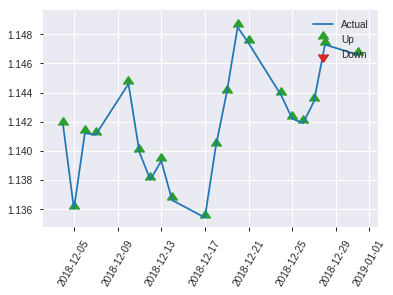


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2449438416251108
RMSE: 0.49491801505412064
LogLoss: 0.6828365573854291
Null degrees of freedom: 255
Residual degrees of freedom: 181
Null deviance: 354.2266765121979
Residual deviance: 349.6123173813397
AIC: 499.6123173813397
AUC: 0.5920955882352942
pr_auc: 0.5025245097611636
Gini: 0.18419117647058836
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36237610438487977: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   100  0.7353   (100.0/136.0)
1      10   110  0.0833   (10.0/120.0)
Total  46   210  0.4297   (110.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362376     0.666667  209
max f2                       0.238365     0.823045  248
max f0point5                 0.375472     0.579004  200
max accuracy                 0.442071     0.582031  158
max precision                0.83134      1         0
max recall                   0.238365     1         248
max specificity              0.83134      1         0
max absolute_mcc             0.375472     0.243598  200
max min_per_class_accuracy   0.481293     0.566176  126
max mean_per_class_accuracy  0.375472     0.600245  200

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.743686           0.711111  0.711111           0.333333         0.780045  0.333333                    0.780045            0.00833333      0.00833333                 -28.8889  -28.8889
    2        0.0234375                   0.713213           0         0.355556           0                0.726182  0.166667                    0.753113            0               0.00833333                 -100      -64.4444
    3        0.03125                     0.691656           1.06667   0.533333           0.5              0.700374  0.25                        0.739928            0.00833333      0.0166667                  6.66667   -46.6667
    4        0.0429688                   0.681764           0.711111  0.581818           0.333333         0.685794  0.272727                    0.725164            0.00833333      0.025                      -28.8889  -41.8182
    5        0.0507812                   0.666847           1.06667   0.65641            0.5              0.676732  0.307692                    0.717713            0.00833333      0.0333333                  6.66667   -34.359
    6        0.101562                    0.623668           1.31282   0.984615           0.615385         0.644028  0.461538                    0.680871            0.0666667       0.1                        31.2821   -1.53846
    7        0.152344                    0.596118           1.31282   1.09402            0.615385         0.610098  0.512821                    0.65728             0.0666667       0.166667                   31.2821   9.40171
    8        0.203125                    0.5788             1.14872   1.10769            0.538462         0.585774  0.519231                    0.639403            0.0583333       0.225                      14.8718   10.7692
    9        0.300781                    0.549184           1.28      1.16364            0.6              0.562768  0.545455                    0.614521            0.125           0.35                       28        16.3636
    10       0.402344                    0.51409            1.06667   1.13916            0.5              0.53157   0.533981                    0.593582            0.108333        0.458333                   6.66667   13.9159
    11       0.5                         0.479558           1.10933   1.13333            0.52             0.494662  0.53125                     0.574262            0.108333        0.566667                   10.9333   13.3333
    12       0.601562                    0.450348           1.14872   1.13593            0.538462         0.467748  0.532468                    0.556279            0.116667        0.683333                   14.8718   13.5931
    13       0.699219                    0.415369           1.024     1.1203             0.48             0.432128  0.52514                     0.53894             0.1             0.783333                   2.4       12.0298
    14       0.800781                    0.371124           1.14872   1.1239             0.538462         0.391782  0.526829                    0.520276            0.116667        0.9                        14.8718   12.3902
    15       0.898438                    0.319732           0.426667  1.04812            0.2              0.347629  0.491304                    0.50151             0.0416667       0.941667                   -57.3333  4.81159
    16       1                           0.143951           0.574359  1                  0.269231         0.26179   0.46875                     0.477163    

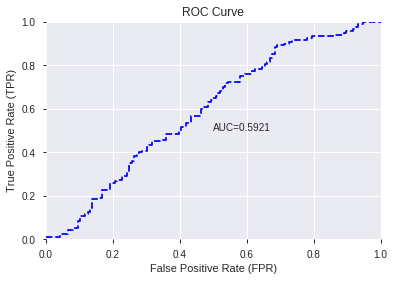

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


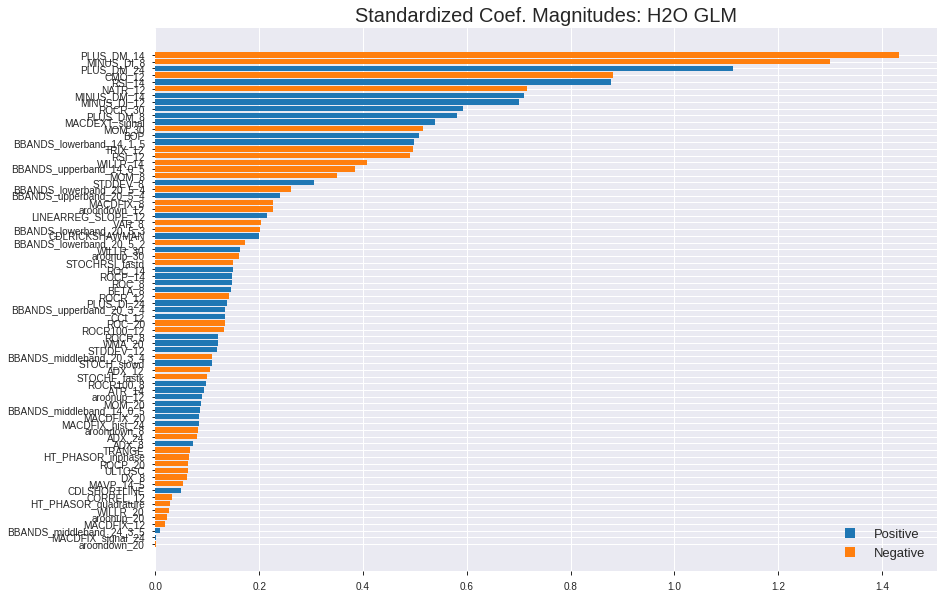

'log_likelihood'
--2019-07-25 02:23:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_022301_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_022301_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['PLUS_DM_14',
 'MINUS_DI_8',
 'PLUS_DM_24',
 'CMO_12',
 'RSI_14',
 'NATR_12',
 'MINUS_DM_14',
 'MINUS_DI_12',
 'ROCR_30',
 'PLUS_DM_8',
 'MACDEXT_signal',
 'MOM_30',
 'BOP',
 'BBANDS_lowerband_14_1_5',
 'TRIX_12',
 'RSI_12',
 'WILLR_14',
 'BBANDS_upperband_14_0_5',
 'MOM_8',
 'STDDEV_8',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_upperband_20_5_4',
 'MACDFIX_8',
 'aroondown_12',
 'LINEARREG_SLOPE_12',
 'VAR_8',
 'BBANDS_lowerband_20_5_3',
 'CDLRICKSHAWMAN',
 'BBANDS_lowerband_20_5_2',
 'WILLR_30',
 'aroonup_30',
 'STOCHRSI_fastd',
 'ROC_14',
 'ROCP_14',
 'ROC_8',
 'BETA_8',
 'ROCR_12',
 'PLUS_DI_24',
 'BBANDS_upperband_20_3_4',
 'CCI_12',
 'ROC_20',
 'ROCR100_12',
 'ROCR_8',
 'WMA_20',
 'STDDEV_12',
 'BBANDS_middleband_20_3_4',
 'STOCH_slowd',
 'ADX_12',
 'STOCHF_fastk',
 'ROCR100_8',
 'ATR_14',
 'aroonup_12',
 'MOM_20',
 'BBANDS_middleband_14_0_5',
 'MACDFIX_20',
 'MACDFIX_hist_24',
 'aroondown_8',
 'ADX_24',
 'ADX_8',
 'TRANGE',
 'HT_PHASOR_inphase',
 'ROCP_20',
 'ULTOSC',
 'DX_8',
 'MAVP

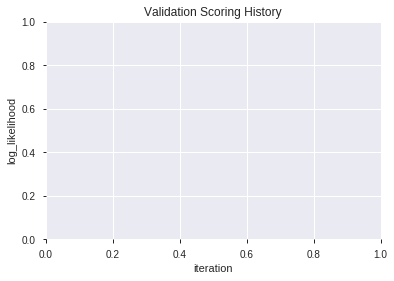

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_022317_model_4  0.630760  0.663994              0.446814  0.485857  0.236057
1               XGBoost_3_AutoML_20190725_022317  0.621936  0.666163              0.392892  0.486984  0.237153
2  XGBoost_grid_1_AutoML_20190725_022317_model_6  0.614583  0.667820              0.409314  0.487794  0.237943
3  XGBoost_grid_1_AutoML_20190725_022317_model_2  0.610172  0.667635              0.387500  0.487876  0.238023
4  XGBoost_grid_1_AutoML_20190725_022317_model_3  0.607659  0.671725              0.449510  0.489702  0.239808
5  XGBoost_grid_1_AutoML_20190725_022317_model_1  0.578554  0.677718              0.453676  0.492723  0.242776
6  XGBoost_grid_1_AutoML_20190725_022317_model_7  0.577328  0.690482              0.435049  0.498585  0.248587
7               XGBoost_2_AutoML_20190725_022317  0.577022  0.680150              0.431618  0.493854  0.243892
8  XGBoost_grid_1_AutoML_20190725_022317_model_5  0.567157  0.708249              0.427206  0.505588  0.255619
9               XGBoost_1_AutoML_20190725_022317  0.566176  0.691603              0.439461  0.499179  0.249179

variable  relative_importance  scaled_importance  percentage
0                        BOP           485.004578           1.000000    0.143380
1                     TRANGE           387.547180           0.799059    0.114569
2               STOCHF_fastk           280.883240           0.579135    0.083037
3                aroondown_8           205.406693           0.423515    0.060724
4       HT_PHASOR_quadrature           104.304565           0.215059    0.030835
5                  PLUS_DM_8           102.681091           0.211712    0.030355
6                  CORREL_12            80.177391           0.165313    0.023703
7             STOCHRSI_fastd            80.174469           0.165307    0.023702
8    BBANDS_upperband_20_5_4            78.897011           0.162673    0.023324
9                     ULTOSC            74.505814           0.153619    0.022026
10                      DX_8            70.658318           0.145686    0.020889
11               MINUS_DM_14            64.348099           0.132675    0.019023
12                MINUS_DI_8            61.476746           0.126755    0.018174
13                   NATR_12            58.935822           0.121516    0.017423
14         MACDFIX_signal_24            55.793087           0.115036    0.016494
15                PLUS_DM_14            54.459118           0.112286    0.016100
16            MACDEXT_signal            52.932461           0.109138    0.015648
17                    BETA_8            51.700119           0.106597    0.015284
18              aroondown_12            50.580208           0.104288    0.014953
19                   ROCR_30            45.713299           0.094253    0.013514
20                  WILLR_14            45.406864           0.093622    0.013423
21                  WILLR_20            40.513268           0.083532    0.011977
22                PLUS_DM_24            38.536968           0.079457    0.011393
23                     ADX_8            37.366604           0.077044    0.011047
24               STOCH_slowd            36.162540           0.074561    0.010691
25                    RSI_14            35.900738           0.074021    0.010613
26                  STDDEV_8            35.706299           0.073621    0.010556
27            CDLRICKSHAWMAN            34.899036           0.071956    0.010317
28           MACDFIX_hist_24            32.467049           0.066942    0.009598
29                 STDDEV_12            32.375732           0.066753    0.009571
30               MINUS_DI_12            30.544338           0.062977    0.009030
31                    ROC_14            30.267517           0.062407    0.008948
32                aroonup_20            30.226578           0.062322    0.008936
33                  WILLR_30            29.697485           0.061231    0.008779
34                    ATR_14            28.558857           0.058884    0.008443
35                aroonup_30            26.015587           0.053640    0.007691
36                    MOM_30            25.792175           0.053179    0.007625
37                    ADX_12            25.611294           0.052806    0.007571
38              CDLSHORTLINE            25.386005           0.052342    0.007505
39         HT_PHASOR_inphase            25.282055           0.052127    0.007474
40                 MACDFIX_8            25.245893           0.052053    0.007463
41   BBANDS_upperband_20_3_4            24.911161           0.051363    0.007364
42                    MOM_20            22.122677           0.045613    0.006540
43                    WMA_20            20.764744           0.042814    0.006139
44                    ADX_24            19.509190           0.040225    0.005767
45                    CCI_12            18.470068           0.038082    0.005460
46                PLUS_DI_24            18.121948           0.037364    0.005357
47   BBANDS_lowerband_20_5_3            17.473755           0.036028    0.005166
48                    CMO_12            16.862774  

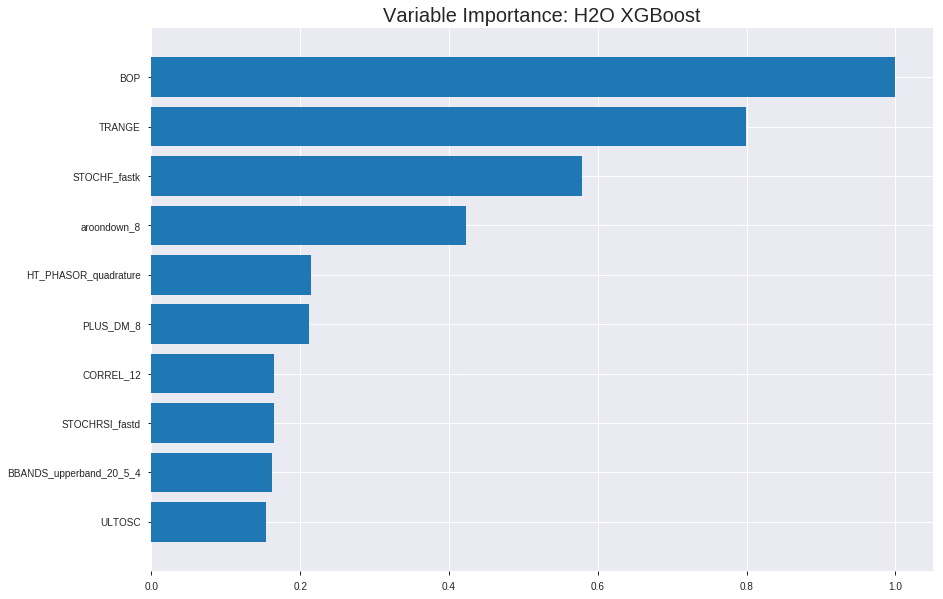

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_022317_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2070492117346466
RMSE: 0.455026605523948
LogLoss: 0.6035162327626791
Mean Per-Class Error: 0.28549054262399887
AUC: 0.7820422667619298
pr_auc: 0.7504549734722284
Gini: 0.5640845335238596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45707598328590393: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      486  431   0.47     (431.0/917.0)
1      110  760   0.1264   (110.0/870.0)
Total  596  1191  0.3027   (541.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457076     0.737506  227
max f2                       0.369196     0.845721  297
max f0point5                 0.534918     0.703083  145
max accuracy                 0.485074     0.711807  198
max precision                0.760489     1         0
max recall                   0.218484     1         381
max specificity              0.760489     1         0
max absolute_mcc             0.478331     0.437192  205
max min_per_class_accuracy   0.510248     0.705747  174
max mean_per_class_accuracy  0.478331     0.714509  205

Gains/Lift Table: Avg response rate: 48.68 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.693103           2.05402   2.05402            1                0.709276  1                           0.709276            0.0206897       0.0206897                  105.402   105.402
    2        0.0201455                   0.673471           1.93991   1.99697            0.944444         0.682272  0.972222                    0.695774            0.0195402       0.0402299                  93.9911   99.6967
    3        0.0302182                   0.666166           1.93991   1.97795            0.944444         0.669645  0.962963                    0.687065            0.0195402       0.0597701                  93.9911   97.7948
    4        0.040291                    0.655296           1.36935   1.8258             0.666667         0.66099   0.888889                    0.680546            0.0137931       0.0735632                  36.9349   82.5798
    5        0.0503637                   0.649209           1.71169   1.80298            0.833333         0.652198  0.877778                    0.674876            0.0172414       0.0908046                  71.1686   80.2976
    6        0.100168                    0.625323           1.54629   1.67535            0.752809         0.637527  0.815642                    0.656306            0.0770115       0.167816                   54.6287   67.5348
    7        0.149972                    0.60705            1.59244   1.64782            0.775281         0.617133  0.802239                    0.643297            0.0793103       0.247126                   59.2445   64.7817
    8        0.200336                    0.588363           1.64322   1.64666            0.8              0.59757   0.801676                    0.631802            0.0827586       0.329885                   64.3218   64.6661
    9        0.299944                    0.560058           1.45397   1.58267            0.707865         0.573655  0.770522                    0.612492            0.144828        0.474713                   45.3971   58.2671
    10       0.400112                    0.533607           1.27372   1.50533            0.620112         0.546337  0.732867                    0.59593             0.127586        0.602299                   27.3724   50.5326
    11       0.50028                     0.508213           1.07865   1.4199             0.52514          0.519717  0.691275                    0.58067             0.108046        0.710345                   7.86489   41.9895
    12       0.599888                    0.476775           1.08471   1.36424            0.52809          0.492726  0.664179                    0.566067            0.108046        0.818391                   8.47088   36.4239
    13       0.700056                    0.441088           0.768824  1.27904            0.374302         0.460814  0.622702                    0.551007            0.0770115       0.895402                   -23.1176  27.9044
    14       0.799664                    0.395607           0.542354  1.18728            0.264045         0.420123  0.578027                    0.534704            0.054023        0.949425                   -45.7646  18.728
    15       0.899832                    0.310697           0.355725  1.09471            0.173184         0.356018  0.53296                     0.514813            0.0356322       0.985057                   -64.4275  9.47125
    16       1                           0.162113           0.149175  1                  0.0726257        0.251402  0.486849                    0.488428          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23820005306809544
RMSE: 0.48805742804315094
LogLoss: 0.6680611338333394
Mean Per-Class Error: 0.40736825980392155
AUC: 0.6083946078431373
pr_auc: 0.5890026317163009
Gini: 0.21678921568627452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3225250840187073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   230  0.902    (230.0/255.0)
1      0    256  0        (0.0/256.0)
Total  25   486  0.4501   (230.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322525     0.690027  375
max f2                       0.322525     0.847682  375
max f0point5                 0.465375     0.600248  256
max accuracy                 0.465375     0.592955  256
max precision                0.690014     1         0
max recall                   0.322525     1         375
max specificity              0.690014     1         0
max absolute_mcc             0.322525     0.227249  375
max min_per_class_accuracy   0.501619     0.566406  195
max mean_per_class_accuracy  0.465375     0.592632  256

Gains/Lift Table: Avg response rate: 50.10 %, avg score: 49.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.656805           1.66341   1.66341            0.833333         0.672424  0.833333                    0.672424            0.0195312       0.0195312                  66.3411    66.3411
    2        0.0215264                   0.642833           1.19766   1.4517             0.6              0.647298  0.727273                    0.661003            0.0117188       0.03125                    19.7656    45.1705
    3        0.0313112                   0.637098           1.59688   1.49707            0.8              0.639163  0.75                        0.654178            0.015625        0.046875                   59.6875    49.707
    4        0.0410959                   0.631268           1.19766   1.42578            0.6              0.634742  0.714286                    0.64955             0.0117188       0.0585938                  19.7656    42.5781
    5        0.0508806                   0.625539           1.19766   1.38191            0.6              0.627341  0.692308                    0.645279            0.0117188       0.0703125                  19.7656    38.1911
    6        0.101761                    0.602027           0.998047  1.18998            0.5              0.612187  0.596154                    0.628733            0.0507812       0.121094                   -0.195312  18.9979
    7        0.150685                    0.584316           1.43719   1.27024            0.72             0.594084  0.636364                    0.617484            0.0703125       0.191406                   43.7188    27.0241
    8        0.201566                    0.572308           0.921274  1.18215            0.461538         0.577243  0.592233                    0.607326            0.046875        0.238281                   -7.8726    18.2153
    9        0.30137                     0.543451           1.21331   1.19247            0.607843         0.556534  0.597403                    0.590505            0.121094        0.359375                   21.3312    19.2472
    10       0.401174                    0.521961           1.09589   1.16845            0.54902          0.532786  0.585366                    0.576146            0.109375        0.46875                    9.58946    16.8445
    11       0.500978                    0.500198           0.978477  1.1306             0.490196         0.510579  0.566406                    0.563084            0.0976562       0.566406                   -2.15227   13.06
    12       0.600783                    0.479068           1.17417   1.13784            0.588235         0.488725  0.570033                    0.550731            0.117188        0.683594                   17.4173    13.7838
    13       0.700587                    0.452837           0.978477  1.11514            0.490196         0.467736  0.558659                    0.538907            0.0976562       0.78125                    -2.15227   11.5136
    14       0.800391                    0.425832           0.743643  1.06881            0.372549         0.440166  0.535452                    0.526595            0.0742188       0.855469                   -25.6357   6.8813
    15       0.900196                    0.381232           0.939338  1.05446            0.470588         0.404939  0.528261                    0.513107            0.09375         0.949219                   -6.06618   5.44582
    16       1                           0.180664           0.508808  1                  0.254902         0.307325  0.500978                    0.49


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:23:22  2.134 sec   0                  0.5              0.693147            0.5             0                  1                0.513151                         0.5                0.693147              0.5               0                    1                  0.499022
    2019-07-25 02:23:22  2.205 sec   5                  0.491162         0.675567            0.688133        0.645128           1.77071          0.404029                         0.495873           0.684896              0.592218          0.554987             0.855469           0.438356
    2019-07-25 02:23:22  2.248 sec   10                 0.484587         0.662536            0.716867        0.678718           1.8258           0.385562                         0.493863           0.680846              0.606824          0.571699             1.66341            0.448141
    2019-07-25 02:23:22  2.298 sec   15                 0.478726         0.650955            0.735998        0.696026           1.8258           0.346391                         0.492548           0.678158              0.609819          0.576312             1.33073            0.455969
    2019-07-25 02:23:22  2.355 sec   20                 0.474011         0.641522            0.742108        0.710309           1.93991          0.360381                         0.491648           0.676216              0.599096          0.573376             1.33073            0.454012
    2019-07-25 02:23:22  2.409 sec   25                 0.47071          0.634975            0.753764        0.720413           1.93991          0.318411                         0.491              0.674887              0.604029          0.57472              1.33073            0.457926
    2019-07-25 02:23:22  2.466 sec   30                 0.467336         0.628239            0.758587        0.724956           1.93991          0.315053                         0.489977           0.672678              0.606311          0.580957             1.33073            0.450098
    2019-07-25 02:23:22  2.526 sec   35                 0.463633         0.620904            0.769716        0.736755           1.93991          0.311696                         0.488865           0.670258              0.611726          0.592849             1.66341            0.450098
    2019-07-25 02:23:22  2.584 sec   40                 0.460587         0.61478             0.774572        0.739828           1.93991          0.317292                         0.487566           0.667434              0.617134          0.598121             1.66341            0.448141
    2019-07-25 02:23:23  2.646 sec   45                 0.457619         0.608778            0.777616        0.744653           2.05402          0.306659                         0.487992           0.668107              0.611696          0.592883             1.33073            0.448141
    2019-07-25 02:23:23  2.722 sec   50                 0.455027         0.603516            0.782042        0.750455           2.05402          0.302742                         0.488057           0.668061              0.608395          0.589003             1.66341            0.450098

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       485.00457763671875     1.0                   0.14338043416638996
TRANGE                    387.54718017578125     0.7990588090202817    0.11456939896180646
STOCHF_fastk              280.88323974609375     0.5791352343822262    0.0830366613467776
aroondown_8               205.4066925048828      0.42351495630364516   0.06072375831077631
HT_PHASOR_quadrature      104.3045654296875      0.21505892983099714   0.03083524273052756
---                       ---                    ---                   ---
BBANDS_lowerband_20_5_2   9.643638610839844      0.01988360328026261   0.0028509196711163087
aroondown_20              7.546600341796875      0.015559853844203256  0.0022309785997474347
BBANDS_middleband_24_3_5  6.902961730957031      0.01423277645046792   0.002040701666861261
ROC_20                    5.9406657218933105     0.012248679694613164  0.00175622101257868
BBANDS_middleband_20_3_4  4.952516555786133      0.010211277963433366  0.001464097467790766


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62109375)

('F1', 0.6572237960339944)

('auc', 0.6307598039215686)

('logloss', 0.6639942773621417)

('mean_per_class_error', 0.38897058823529407)

('rmse', 0.4858570484428093)

('mse', 0.23605707152155836)

xgboost prediction progress: |████████████████████████████████████████████| 100%


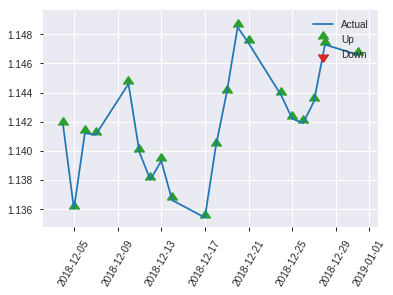


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23605707152155836
RMSE: 0.4858570484428093
LogLoss: 0.6639942773621417
Mean Per-Class Error: 0.38897058823529407
AUC: 0.6307598039215686
pr_auc: 0.5674729638231032
Gini: 0.2615196078431372
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3116247355937958: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   117  0.8603   (117.0/136.0)
1      4    116  0.0333   (4.0/120.0)
Total  23   233  0.4727   (121.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311625     0.657224  232
max f2                       0.203563     0.820793  250
max f0point5                 0.530192     0.586957  84
max accuracy                 0.530192     0.621094  84
max precision                0.686922     1         0
max recall                   0.203563     1         250
max specificity              0.686922     1         0
max absolute_mcc             0.530192     0.235299  84
max min_per_class_accuracy   0.492511     0.588235  126
max mean_per_class_accuracy  0.530192     0.611029  84

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.670022           1.42222   1.42222            0.666667         0.676238  0.666667                    0.676238            0.0166667       0.0166667                  42.2222   42.2222
    2        0.0234375                   0.62351            0.711111  1.06667            0.333333         0.651726  0.5                         0.663982            0.00833333      0.025                      -28.8889  6.66667
    3        0.03125                     0.614439           2.13333   1.33333            1                0.616562  0.625                       0.652127            0.0166667       0.0416667                  113.333   33.3333
    4        0.0429688                   0.612123           0.711111  1.16364            0.333333         0.613156  0.545455                    0.641499            0.00833333      0.05                       -28.8889  16.3636
    5        0.0507812                   0.610962           1.06667   1.14872            0.5              0.6115    0.538462                    0.636884            0.00833333      0.0583333                  6.66667   14.8718
    6        0.101562                    0.587815           1.64103   1.39487            0.769231         0.599217  0.653846                    0.618051            0.0833333       0.141667                   64.1026   39.4872
    7        0.152344                    0.57521            0.984615  1.25812            0.461538         0.583073  0.589744                    0.606391            0.05            0.191667                   -1.53846  25.812
    8        0.203125                    0.5583             1.64103   1.35385            0.769231         0.562712  0.634615                    0.595471            0.0833333       0.275                      64.1026   35.3846
    9        0.300781                    0.534894           1.19467   1.30216            0.56             0.547443  0.61039                     0.579878            0.116667        0.391667                   19.4667   30.2165
    10       0.402344                    0.51318            1.06667   1.24272            0.5              0.525381  0.582524                    0.566121            0.108333        0.5                        6.66667   24.2718
    11       0.5                         0.492214           0.938667  1.18333            0.44             0.501612  0.554688                    0.553522            0.0916667       0.591667                   -6.13333  18.3333
    12       0.601562                    0.463404           1.06667   1.16364            0.5              0.477331  0.545455                    0.540658            0.108333        0.7                        6.66667   16.3636
    13       0.699219                    0.441788           0.853333  1.1203             0.4              0.451702  0.52514                     0.528234            0.0833333       0.783333                   -14.6667  12.0298
    14       0.800781                    0.394867           0.902564  1.09268            0.423077         0.417523  0.512195                    0.514193            0.0916667       0.875                      -9.74359  9.26829
    15       0.898438                    0.31909            0.768     1.05739            0.36             0.365503  0.495652                    0.498031            0.075           0.95                       -23.2     5.73913
    16       1                           0.167316           0.492308  1                  0.230769         0.262605  0.46875                     0.47412           

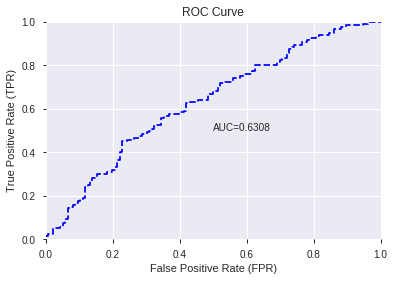

This function is available for GLM models only


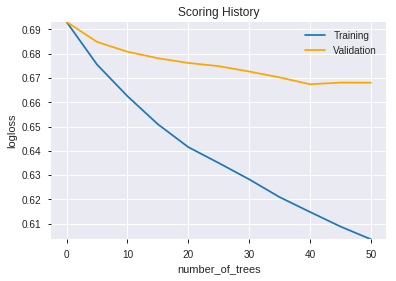

--2019-07-25 02:23:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_022317_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_022317_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b921',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'aroondown_8',
 'HT_PHASOR_quadrature',
 'PLUS_DM_8',
 'CORREL_12',
 'STOCHRSI_fastd',
 'BBANDS_upperband_20_5_4',
 'ULTOSC',
 'DX_8',
 'MINUS_DM_14',
 'MINUS_DI_8',
 'NATR_12',
 'MACDFIX_signal_24',
 'PLUS_DM_14',
 'MACDEXT_signal',
 'BETA_8',
 'aroondown_12',
 'ROCR_30',
 'WILLR_14',
 'WILLR_20',
 'PLUS_DM_24',
 'ADX_8',
 'STOCH_slowd',
 'RSI_14',
 'STDDEV_8',
 'CDLRICKSHAWMAN',
 'MACDFIX_hist_24',
 'STDDEV_12',
 'MINUS_DI_12',
 'ROC_14',
 'aroonup_20',
 'WILLR_30',
 'ATR_14',
 'aroonup_30',
 'MOM_30',
 'ADX_12',
 'CDLSHORTLINE',
 'HT_PHASOR_inphase',
 'MACDFIX_8',
 'BBANDS_upperband_20_3_4',
 'MOM_20',
 'WMA_20',
 'ADX_24',
 'CCI_12',
 'PLUS_DI_24',
 'BBANDS_lowerband_20_5_3',
 'CMO_12',
 'BBANDS_upperband_14_0_5',
 'aroonup_12',
 'ROCR_12',
 'ROC_8',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_20_5_2',
 'aroondown_20',
 'BBANDS_middleband_24_3_5',
 'ROC_20',
 'BBANDS_middleband_20_3_4']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.613
GLM             0.582
XGBoost         0.648
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.551    0.648
DLF          0.555  0.547    0.613
Fwe          0.570  0.559    0.570
RFE          0.586  0.582    0.621
XGBF         0.613  0.547    0.613





F1


DeepLearning    0.681
GLM             0.667
XGBoost         0.681
dtype: float64

DeepLearning    GLM  XGBoost
All          0.659  0.650    0.681
DLF          0.642  0.638    0.671
Fwe          0.647  0.649    0.657
RFE          0.681  0.667    0.657
XGBF         0.650  0.638    0.671





auc


DeepLearning    0.587
GLM             0.592
XGBoost         0.667
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.552    0.667
DLF          0.558  0.514    0.638
Fwe          0.558  0.551    0.572
RFE          0.587  0.592    0.631
XGBF         0.565  0.514    0.638





logloss


DeepLearning    0.779
GLM             0.695
XGBoost         0.684
dtype: float64

DeepLearning    GLM  XGBoost
All          0.721  0.687    0.653
DLF          0.694  0.695    0.665
Fwe          0.686  0.687    0.684
RFE          0.666  0.683    0.664
XGBF         0.779  0.695    0.665





mean_per_class_error


DeepLearning    0.450
GLM             0.458
XGBoost         0.425
dtype: float64

DeepLearning    GLM  XGBoost
All          0.422  0.438    0.346
DLF          0.440  0.458    0.377
Fwe          0.450  0.452    0.425
RFE          0.393  0.400    0.389
XGBF         0.396  0.458    0.377





rmse


DeepLearning    0.513
GLM             0.501
XGBoost         0.496
dtype: float64

DeepLearning    GLM  XGBoost
All          0.510  0.497    0.480
DLF          0.501  0.501    0.486
Fwe          0.497  0.497    0.496
RFE          0.487  0.495    0.486
XGBF         0.513  0.501    0.486





mse


DeepLearning    0.263
GLM             0.251
XGBoost         0.246
dtype: float64

DeepLearning    GLM  XGBoost
All          0.260  0.247    0.231
DLF          0.251  0.251    0.236
Fwe          0.247  0.247    0.246
RFE          0.237  0.245    0.236
XGBF         0.263  0.251    0.236

{'F1':       DeepLearning    GLM  XGBoost
 All          0.659    NaN      NaN
 DLF          0.642    NaN      NaN
 DLF            NaN  0.638      NaN
 DLF            NaN    NaN    0.671
 All            NaN  0.650      NaN
 All            NaN    NaN    0.681
 XGBF         0.650    NaN      NaN
 XGBF           NaN  0.638      NaN
 XGBF           NaN    NaN    0.671
 Fwe          0.647    NaN      NaN
 Fwe            NaN  0.649      NaN
 Fwe            NaN    NaN    0.657
 RFE          0.681    NaN      NaN
 RFE            NaN  0.667      NaN
 RFE            NaN    NaN    0.657,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.555    NaN      NaN
 DLF            NaN  0.547      NaN
 DLF            NaN    NaN    0.613
 All            NaN  0.551      NaN
 All            NaN    NaN    0.648
 XGBF         0.613    NaN      NaN
 XGBF           NaN  0.547      NaN
 XGBF           NaN    NaN    0.613
 Fwe          0.570    NaN      NaN
 Fwe     